# Imports

In [297]:
import sys
sys.path.append('..')

In [298]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import time

import alignment.alignment_utils as utils

%matplotlib inline

# Data Loading

### Real data

In [299]:
DATA_PATH = '../data/'
# data_filename = DATA_PATH + 'pt_decoding_data_S62.pkl'
data_filename = DATA_PATH + 'pt_decoding_data_S62_zscore.pkl'

In [300]:
all_pt_dict = utils.load_pkl(data_filename)
pt_names = list(all_pt_dict.keys())

In [301]:
print(pt_names)
print(all_pt_dict[pt_names[0]].keys())
print([all_pt_dict[pt]['X1'].shape for pt in pt_names])

['S14', 'S26', 'S23', 'S33', 'S22', 'S39', 'S58', 'S62']
dict_keys(['ID', 'X1', 'X1_map', 'y1', 'X2', 'X2_map', 'y2', 'X3', 'X3_map', 'y3', 'y_full_phon', 'X_collapsed', 'y_phon_collapsed', 'y_artic_collapsed', 'pre_pts'])
[(144, 200, 111), (148, 200, 111), (151, 200, 63), (46, 200, 149), (151, 200, 74), (137, 200, 144), (141, 200, 171), (178, 200, 201)]


In [302]:
all_pt_chan_data = {}
for pt in pt_names:
    temp = {}
    temp['map'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_channelMap.mat'.format(pt))['chanMap']
    # if pt == 'S58':
    #     temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 2 # this is so weird
    # else:
    temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 1
    all_pt_chan_data[pt] = temp

### Surrogate TME Data

In [303]:
# surr_types = ['T', 'N', 'C', 'TN', 'TC', 'NC', 'TNC']
# surr_types = ['N', 'C', 'NC']  # no T
# surr_types = ['T', 'C', 'TC']  # no N
# surr_types = ['T', 'N', 'TN'] # no C
surr_types = ['TNC']
# surr_types = ['TNC', 'T', 'TN']
# surr_suffix = ''
surr_suffix = '_zscore'


# all_pt_surr_dict = {}
# all_pt_surrMap_dict = {}
# # for pt in pt_names:
# for pt in pt_names:
#     all_surr_dict = {}
#     all_surrMap_dict = {}
#     for surr in surr_types:
#         surr_data = sio.loadmat(f'../data/{pt}/TME/{pt}_TME_{surr}{surr_suffix}.mat')['surrTensor']
#         surr_map = sio.loadmat(f'../data/{pt}/TME/{pt}_TME_map{surr}{surr_suffix}.mat')['surrTensorMap']
#         all_surr_dict[surr] = surr_data
#         all_surrMap_dict[surr] = np.transpose(surr_map.reshape(-1, all_pt_dict[pt]['X1_map'].shape[2],
#                                                                all_pt_dict[pt]['X1_map'].shape[1],200),
#                                                                (0,2,1,3))
#     all_pt_surr_dict[pt] = all_surr_dict
#     all_pt_surrMap_dict[pt] = all_surrMap_dict

# print(all_pt_surr_dict.keys())
# print(all_pt_surr_dict['S14'].keys())
# print([all_pt_surr_dict[pt][surr].shape for pt in pt_names])

# print(all_pt_surrMap_dict.keys())
# print(all_pt_surrMap_dict['S14'].keys())
# print([all_pt_surrMap_dict[pt][surr].shape for pt in pt_names])

Check that means are identical because TME preserves means

In [304]:
# for pt in pt_names:
#     f, _ = plt.subplots(1, 2, figsize=(10, 5))

#     real = all_pt_dict[pt]['X1_map']
#     real[real == 0] = np.nan

#     surr = all_pt_surrMap_dict[pt]['TNC']
#     surr[surr == 0] = np.nan

#     plt.subplot(1, 2, 1)
#     plt.imshow(np.mean(real, axis=(0,3)), cmap='viridis')

#     plt.subplot(1, 2, 2)
#     plt.imshow(np.mean(surr, axis=(0,3)), cmap='viridis')

#     plt.show()

## Phoneme label processing functions

In [305]:
phon_labels = np.array(['a', 'ae', 'i', 'u', 'b', 'p', 'v', 'g', 'k'])
artic_labels = np.array(['low', 'high', 'labial', 'dorsal'])
phon_to_artic_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4}

In [306]:
def phon_to_artic(phon_idx, phon_to_artic_conv):
    return phon_to_artic_conv[phon_idx]

def phon_to_artic_seq(phon_seq, phon_to_artic_conv):
    flat_seq = phon_seq.flatten()
    artic_conv = np.array([phon_to_artic(phon_idx, phon_to_artic_conv) for phon_idx in flat_seq])
    return np.reshape(artic_conv, phon_seq.shape)

def phon2artic(phon):
    return artic_labels[phon_to_artic_dict[int(phon)] - 1]

def phon2artic_seq(phon_seq):
    return '_'.join([phon2artic(phon) for phon in phon_seq])

def labels2cv_seq(labels):
    labels_str = []
    for lab in labels:
        labels_str.append(labels2cv(lab))
    return np.array(labels_str)

def labels2cv(str):
    middle_val = str[1]
    if int(middle_val) < 5:
        return 'CVC'
    else:
        return 'VCV'

def articic_nums2seq(artic_num_seqs):
    return np.array([artic_labels[artic_num-1] for artic_num in artic_num_seqs])

## Data Processing

In [307]:
p_ind = 1

all_pt_traces = {}
all_pt_surr_traces = {}
all_pt_phon_labels = {}
all_pt_phon_seqs = {}
all_pt_phon_seqs_str = {}
all_pt_artic_labels = {}
all_pt_artic_seqs = {}
all_pt_artic_seqs_str = {}
all_pt_cv_labels = {}
for pt in pt_names:
    pt_trace = all_pt_dict[pt][f'X{p_ind}']  ### Real data: (trials, time, channels)

    # surr_type_traces = {}
    # for surr in surr_types:
    #     surr_type_traces[surr] = np.transpose(all_pt_surr_dict[pt][surr], [2,0,1])  ### Surrogate data: (time, channels, trials) -> (trials, time, channels)

    pt_phon_labels = all_pt_dict[pt][f'y{p_ind}']
    pt_phon_seqs = all_pt_dict[pt]['y_full_phon']
    pt_phon_seqs_str = utils.label_seq2str(pt_phon_seqs)
    pt_artic_labels = phon_to_artic_seq(pt_phon_labels, phon_to_artic_dict)
    pt_artic_seqs = phon_to_artic_seq(pt_phon_seqs, phon_to_artic_dict)
    pt_artic_seqs_str = utils.label_seq2str(pt_artic_seqs)
    pt_cv_labels = labels2cv_seq(pt_phon_seqs)

    all_pt_traces[pt] = pt_trace
    # all_pt_surr_traces[pt] = surr_type_traces
    all_pt_phon_labels[pt] = pt_phon_labels
    all_pt_phon_seqs[pt] = pt_phon_seqs
    all_pt_phon_seqs_str[pt] = pt_phon_seqs_str
    all_pt_artic_labels[pt] = pt_artic_labels
    all_pt_artic_seqs[pt] = pt_artic_seqs
    all_pt_artic_seqs_str[pt] = pt_artic_seqs_str
    all_pt_cv_labels[pt] = pt_cv_labels

In [308]:
# [all_pt_surr_traces[pt][list(all_pt_surr_traces[pt].keys())[0]].shape for pt in pt_names]

In [309]:
# artic_seq_strs = articic_nums2seq(pt_artic_seqs)
# artic_seq_strs = np.array([[s[0:2] + '_' for s in labs] for labs in artic_seq_strs])
# artic_seq_strs = utils.label2str(artic_seq_strs)
# artic_seq_strs = np.array([s[0:-1] for s in artic_seq_strs])

In [310]:
t = np.linspace(-0.5, 0.5 - 1/pt_trace.shape[1], pt_trace.shape[1])

In [311]:
# all_pt_phon_seq_avg_traces = {}
# all_pt_artic_seq_avg_traces = {}
# all_pt_phon_avg_traces = {}
# all_pt_artic_avg_traces = {}
# all_pt_cv_avg_traces = {}

# for pt in pt_names:
#     pt_trace = all_pt_traces[pt]
#     pt_phon_seqs_str = all_pt_phon_seqs_str[pt]
#     pt_artic_seqs_str = all_pt_artic_seqs_str[pt]
#     pt_phon_labels = all_pt_phon_labels[pt]
#     pt_artic_labels = all_pt_artic_labels[pt]
#     pt_cv_labels = all_pt_cv_labels[pt]

#     phon_seq_avg_trace = utils.cnd_avg(pt_trace, pt_phon_seqs_str)
#     artic_seq_avg_trace = utils.cnd_avg(pt_trace, pt_artic_seqs_str)
#     phon_avg_trace = utils.cnd_avg(pt_trace, pt_phon_labels)
#     artic_avg_trace = utils.cnd_avg(pt_trace, pt_artic_labels)
#     cv_avg_trace = utils.cnd_avg(pt_trace, pt_cv_labels)

#     all_pt_phon_seq_avg_traces[pt] = phon_seq_avg_trace
#     all_pt_artic_seq_avg_traces[pt] = artic_seq_avg_trace
#     all_pt_phon_avg_traces[pt] = phon_avg_trace
#     all_pt_artic_avg_traces[pt] = artic_avg_trace
#     all_pt_cv_avg_traces[pt] = cv_avg_trace

# Data Visualization

### Plotting utils

In [312]:
from matplotlib.colors import LinearSegmentedColormap

parula_data = cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

parula_map = LinearSegmentedColormap.from_list('parula', parula_data)

In [313]:
def line(error_y_mode=None, **kwargs):
    """Extension of `plotly.express.line` to use error bands.
    
    From https://stackoverflow.com/questions/69587547/continuous-error-band-with-plotly-express-in-python, user171780"""
    ERROR_MODES = {'bar','band','bars','bands',None}
    if error_y_mode not in ERROR_MODES:
        raise ValueError(f"'error_y_mode' must be one of {ERROR_MODES}, received {repr(error_y_mode)}.")
    if error_y_mode in {'bar','bars',None}:
        fig = px.line(**kwargs)
    elif error_y_mode in {'band','bands'}:
        if 'error_y' not in kwargs:
            raise ValueError(f"If you provide argument 'error_y_mode' you must also provide 'error_y'.")
        figure_with_error_bars = px.line(**kwargs)
        fig = px.line(**{arg: val for arg,val in kwargs.items() if arg != 'error_y'})
        for data in figure_with_error_bars.data:
            x = list(data['x'])
            y_upper = list(data['y'] + data['error_y']['array'])
            y_lower = list(data['y'] - data['error_y']['array'] if data['error_y']['arrayminus'] is None else data['y'] - data['error_y']['arrayminus'])
            color = f"rgba({tuple(int(data['line']['color'].lstrip('#')[i:i+2], 16) for i in (0, 2, 4))},.3)".replace('((','(').replace('),',',').replace(' ','')
            fig.add_trace(
                go.Scatter(
                    x = x+x[::-1],
                    y = y_upper+y_lower[::-1],
                    fill = 'toself',
                    fillcolor = color,
                    line = dict(
                        color = 'rgba(255,255,255,0)'
                    ),
                    hoverinfo = "skip",
                    showlegend = False,
                    legendgroup = data['legendgroup'],
                    xaxis = data['xaxis'],
                    yaxis = data['yaxis'],
                )
            )
        # Reorder data as said here: https://stackoverflow.com/a/66854398/8849755
        reordered_data = []
        for i in range(int(len(fig.data)/2)):
            reordered_data.append(fig.data[i+int(len(fig.data)/2)])
            reordered_data.append(fig.data[i])
        fig.data = tuple(reordered_data)
    return fig

In [314]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def chan_disp(data, chan_map, title, label, figsize=(8, 6), cbar_lower=None, cbar_upper=None, cmap=None):

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    if cmap is None:
        cmap = parula_map

    chan_data = np.array([data[int(i)] if not np.isnan(i) else np.nan for i in (chan_map.flatten()-1)])
    chan_data = chan_data.reshape(chan_map.shape)
    f = plt.figure(figsize=figsize)
    im = plt.imshow(chan_data, cmap=parula_map)
    im.set_clim(clim[0], clim[1])
    # plt.gca().invert_yaxis()
    # plt.contourf(chan_data, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    
    plt.show()

def chan_disp_seq(data, chan_map, t, t_ranges, labs, title, label, figsize=(3, 6), cbar_pos=[0.81, 0.56, 0.01, 0.3], sup_pos=0.95, cbar_lower=None, cbar_upper=None):
    f, tot_axs = plt.subplots(len(labs), len(t_ranges), figsize=(figsize[0]*len(t_ranges), figsize[1]*len(labs)))

    if len(labs) == 1:
        tot_axs = tot_axs[np.newaxis,:]

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    for j, lab in enumerate(labs):
        lab_data = data[j]
        axs = tot_axs[j]
        for i, t_range in enumerate(t_ranges):
            t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
            chan_data = np.array([lab_data[t_inds,:].mean(axis=0)[int(k)] if not np.isnan(k) else np.nan for k in (chan_map.flatten()-1)])
            chan_data = chan_data.reshape(chan_map.shape)
            im = axs[i].imshow(chan_data, cmap=parula_map)
            im.set_clim(clim[0], clim[1])
            if i==0:
                axs[i].set_ylabel(lab)
            if j==0:
                axs[i].set_title(f'{t_range[0]} -> {t_range[1]}s')
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            

        # divider = make_axes_locatable(plt.gca())
        # cax = divider.append_axes('right', size='5%', pad=0.05)

        # cbar = plt.colorbar(im, cax=cax)
        
        # cbar.set_label(label)
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes(cbar_pos)
    cbar = f.colorbar(im, cax=cbar_ax)
    cbar.set_label(label)

    # f.tight_layout(rect=[0, 0.03, 1, 0.95])
    f.suptitle(title, y=sup_pos)
    plt.show()

## CCA Alignment

In [48]:
from alignment.AlignCCA import AlignCCA
from decoders.cross_pt_decoders import crossPtDecoder_sepAlign
from alignment.alignment_utils import cnd_avg

from sklearn.decomposition import PCA

### TME Correlation

In [27]:
# pca_comp = 30
pca_comp = 0.9
cca_comp = 10
t_win = np.array([-0.25, 0.25])
t_inds = np.where((t >= t_win[0]) & (t < t_win[1]))[0]

pairwise_corrs = []
for tar_pt in pt_names:
    other_pts = [pt for pt in pt_names if pt != tar_pt]
# for tar_pt in ['S14', 'S26', 'S33']:
#     other_pts = [pt for pt in ['S14', 'S26', 'S33'] if pt != tar_pt]

    tar_pt_data = (all_pt_traces[tar_pt][:, t_inds, :], all_pt_phon_labels[tar_pt], all_pt_phon_seqs_str[tar_pt])
    cross_pt_data = [(all_pt_traces[pt][:, t_inds, :], all_pt_phon_labels[pt], all_pt_phon_seqs_str[pt]) for pt in other_pts]

    cca_wrapper = crossPtDecoder_sepAlign(cross_pt_data, None, AlignCCA, n_comp=pca_comp)
    pooled_traces, pooled_labels = cca_wrapper.preprocess_train(tar_pt_data[0], tar_pt_data[1], y_align=tar_pt_data[2])  ## align by full phoneme sequence
    aligners = cca_wrapper.algns
    CCs = [a.canon_corrs[:cca_comp] for a in aligners]
    
    for pt, corrs in zip(other_pts, CCs):
        data = {'Data': 'Real', 'Patient 1': tar_pt, 'Patient 2': pt}
        data_corr = {}
        for i, c in enumerate(corrs):
            data_corr[f'CC {i+1}'] = c
        data = dict(data, **data_corr)

        pairwise_corrs.append(data)
pairwise_corrs = pd.DataFrame(pairwise_corrs)
    
pairwise_corrs_surr = []
for tar_pt in pt_names:
    other_pts = [pt for pt in pt_names if pt != tar_pt]
# for tar_pt in ['S14', 'S26', 'S33']:
#     other_pts = [pt for pt in ['S14', 'S26', 'S33'] if pt != tar_pt]

    for surr in surr_types:
        tar_pt_data = (all_pt_surr_traces[tar_pt][surr][:, t_inds, :], all_pt_phon_labels[tar_pt], all_pt_phon_seqs_str[tar_pt])
        # tar_pt_data = (all_pt_traces[tar_pt][:, t_inds, :], all_pt_phon_labels[tar_pt], all_pt_phon_seqs_str[tar_pt])  # only using surrogate data for aligned patients
        cross_pt_data = [(all_pt_surr_traces[pt][surr][:, t_inds, :], all_pt_phon_labels[pt], all_pt_phon_seqs_str[pt]) for pt in pt_names if pt != tar_pt]
        # cross_pt_data = [(all_pt_traces[pt][:, t_inds, :], all_pt_phon_labels[pt], all_pt_phon_seqs_str[pt]) for pt in pt_names if pt != tar_pt]

        cca_wrapper = crossPtDecoder_sepAlign(cross_pt_data, None, AlignCCA, n_comp=pca_comp)  # using decoder class without decoder to handle data preprocessing
        _, _ = cca_wrapper.preprocess_train(tar_pt_data[0], tar_pt_data[1], y_align=tar_pt_data[2])  ## align by full phoneme sequence
        aligners = cca_wrapper.algns
        CCs = [a.canon_corrs[:cca_comp] for a in aligners]

        for pt, corrs in zip(other_pts, CCs):
            data = {'Data': surr + ' (TME)', 'Patient 1': tar_pt, 'Patient 2': pt}
            data_corr = {}
            for i, c in enumerate(corrs):
                data_corr[f'CC {i+1}'] = c
            data = dict(data, **data_corr)

            pairwise_corrs_surr.append(data)
pairwise_corrs_surr = pd.DataFrame(pairwise_corrs_surr)

In [28]:
cc_df_wide = pd.concat([pairwise_corrs, pairwise_corrs_surr], ignore_index=True)
cc_df_long = cc_df_wide.melt(id_vars=['Data', 'Patient 1', 'Patient 2'], var_name='Latent Component', value_name='Canonical Correlation')
cc_df_long['Latent Component'] = cc_df_long['Latent Component'].str.replace('CC ', '').astype(int)
# cc_df_long = cc_df_long.sort_values(by=['Data', 'Patient 1', 'Patient 2', 'Latent Component'])

In [29]:
cc_df_long
# cc_df_long[cc_df_long['Data'] == 'Real']
# cc_df_long[cc_df_long['Data'] == 'TC (TME)']

Data Patient 1 Patient 2  Latent Component  Canonical Correlation
0         Real       S14       S26                 1               0.710576
1         Real       S14       S23                 1               0.650906
2         Real       S14       S33                 1               0.714256
3         Real       S14       S22                 1               0.570634
4         Real       S26       S14                 1               0.710576
..         ...       ...       ...               ...                    ...
395  TNC (TME)       S33       S22                10                    NaN
396  TNC (TME)       S22       S14                10                    NaN
397  TNC (TME)       S22       S26                10                    NaN
398  TNC (TME)       S22       S23                10                    NaN
399  TNC (TME)       S22       S33                10                    NaN

[400 rows x 5 columns]

#### Visualization

In [30]:
from matplotlib.ticker import MultipleLocator
import scipy.stats as stats

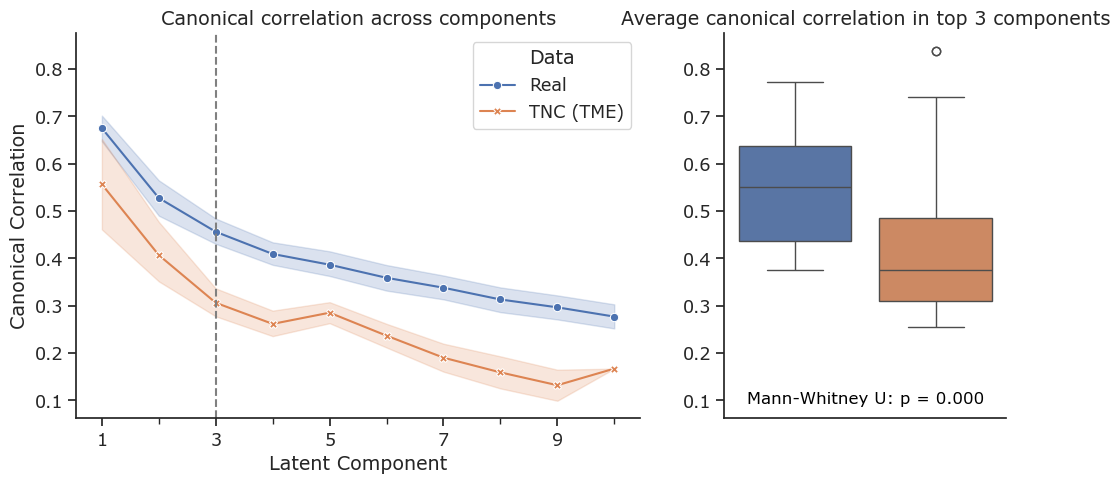

MannwhitneyuResult(statistic=1684.0, pvalue=2.4704116718772917e-06)


In [31]:
hist_comps = 3

sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
f, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True, width_ratios=[1, 0.5])
# f, axs = plt.subplots(1, 2, figsize=(15,5), sharey=True, width_ratios=[1, 1.25])

sns.lineplot(data=cc_df_long, x='Latent Component', y='Canonical Correlation', hue='Data', style='Data', markers=True, dashes=False, ax=axs[0])
axs[0].axvline(x=hist_comps, color='grey', linestyle='dashed')
axs[0].set_xticks(np.arange(1, 10, 2))
axs[0].xaxis.set_minor_locator(MultipleLocator(2))
axs[0].set_title('Canonical correlation across components')


# sns.histplot(data=cc_df_long[cc_df_long['Neural Mode'] <= 4], y='Canonical Correlation', hue='Data', binwidth=0.15, ax=axs[1])
# sns.histplot(data=cc_df_long[cc_df_long['Component'] <= hist_comps], y='Canonical Correlation', hue='Data', ax=axs[1])
# sns.histplot(data=cc_df_long[(cc_df_long['Latent Component'] <= hist_comps)].groupby(['Data', 'Patient 1', 'Patient 2']).mean().loc[cc_df_long['Data'].unique()], y='Canonical Correlation', hue='Data', ax=axs[1], element='step')
sns.boxplot(data=cc_df_long[cc_df_long['Latent Component'] <= hist_comps], x='Data', y='Canonical Correlation', hue='Data', ax=axs[1])
axs[1].set_title(f'Average canonical correlation in top {hist_comps} components')
axs[1].yaxis.set_tick_params(labelbottom=True)
axs[1].legend([],[], frameon=False)
axs[1].set_xticklabels([])
axs[1].set_xlabel('')
axs[1].set_xticks([])

mwu_res = stats.mannwhitneyu(cc_df_long[(cc_df_long['Data'] == 'Real') & (cc_df_long['Latent Component'] <= hist_comps)]['Canonical Correlation'],
                             cc_df_long[(cc_df_long['Data'] == 'TNC (TME)') & (cc_df_long['Latent Component'] <= hist_comps)]['Canonical Correlation'],
                             alternative='greater', nan_policy='omit')
# annotate p-value on box plot
axs[1].annotate(f'Mann-Whitney U: p = {mwu_res.pvalue:.3f}', xy=(0.5, 0.05), xycoords='axes fraction', ha='center', va='center', fontsize=12, color='black', backgroundcolor='white')

sns.despine()
plt.show()
print(mwu_res)

In [21]:
test_res = stats.mannwhitneyu(cc_df_long[(cc_df_long['Data'] == 'TN (TME)') & (cc_df_long['Latent Component'] <= hist_comps)]['Canonical Correlation'],
                             cc_df_long[(cc_df_long['Data'] == 'TNC (TME)') & (cc_df_long['Latent Component'] <= hist_comps)]['Canonical Correlation'],
                             alternative='greater', nan_policy='omit')
print(test_res)

ValueError: `x` and `y` must be of nonzero size.

In [ ]:
cc_df_long[(cc_df_long['Latent Component'] <= hist_comps)].groupby(['Data', 'Patient 1', 'Patient 2']).mean().loc[cc_df_long['Data'].unique()]

### TSNE with aligned data

In [35]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

#### Pt-Specific

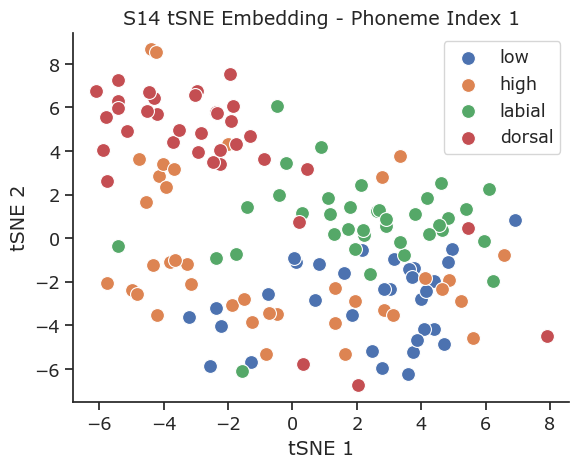

In [36]:
pt = 'S14'
curr_trace = all_pt_traces[pt]
curr_labels = all_pt_artic_labels[pt]
curr_label_names = artic_labels

t_pca_comp = 0.8
pt_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_trace.reshape(curr_trace.shape[0], -1))
pt_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(pt_time_pca)
# pt_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(curr_trace.reshape(curr_trace.shape[0], -1))

sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
plt.figure()
for lab in np.unique(curr_labels):
    sns.scatterplot(x=-pt_embed_time[np.where(curr_labels == lab)[0],1], y=-pt_embed_time[np.where(curr_labels == lab)[0],0], s=100)
    # plt.scatter([],[],label=curr_label_names[lab-1])
# sns.scatterplot(x=pt_embed_time[:,0], y=pt_embed_time[:,1], hue=curr_labels, palette='tab10', legend='full')
# plt.scatter(S14_embed_t0[:,0], S14_embed_t0[:,1], c=S14_artic_labels[:,0])
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title(f'{pt} tSNE Embedding - Phoneme Index {p_ind}')
plt.legend(labels=curr_label_names)

sns.despine()
plt.show()

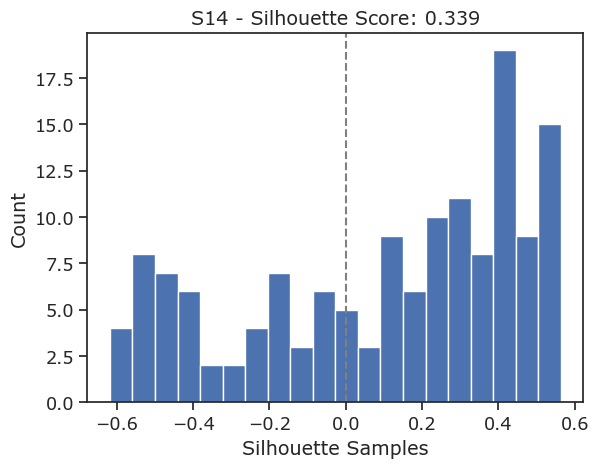

In [37]:
ps_sils = silhouette_samples(pt_embed_time, curr_labels)
ps_sil_score = np.mean(ps_sils[np.where(ps_sils > 0)])
plt.figure()
plt.hist(ps_sils, bins=20)
plt.axvline(0, color='grey', linestyle='dashed')
plt.xlabel('Silhouette Samples')
plt.ylabel('Count')
plt.title(f'{pt} - Silhouette Score: {ps_sil_score:.3f}')
plt.show()

In [175]:
n_iter = 50
ps_sil_scores = np.zeros(n_iter)
ps_sil_scores_shuf = np.zeros(n_iter)
for i in range(n_iter):

    pt_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_trace.reshape(curr_trace.shape[0], -1))
    pt_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(pt_time_pca)
    ps_sils = silhouette_samples(pt_embed_time, curr_labels)
    ps_sils_shuf = silhouette_samples(pt_embed_time, np.random.permutation(curr_labels))
    ps_score = np.mean(ps_sils[np.where(ps_sils > 0)])
    ps_score_shuf = np.mean(ps_sils_shuf[np.where(ps_sils_shuf > 0)])
    ps_sil_scores[i] = ps_score
    ps_sil_scores_shuf[i] = ps_score_shuf


In [177]:
sil_df_real_long = pd.DataFrame({'Silhouette Score': ps_sil_scores})
# sil_df_real_long = sil_df_real.melt(var_name='Data', value_name='Silhouette Score')
sil_df_shuf_long = pd.DataFrame({'Silhouette Score': ps_sil_scores_shuf})
# # sil_df_shuf_long = sil_df_shuf.melt(var_name='Data', value_name='Silhouette Score')
sil_df_real_long['Condition'] = 'Articulatory Features'
sil_df_shuf_long['Condition'] = 'Chance Distribution'
sil_df_long = pd.concat([sil_df_real_long, sil_df_shuf_long], ignore_index=True)
ps_sil_df_long = sil_df_real_long

In [178]:
ps_sil_df_long['Silhouette Score'].mean()

0.3133480778336525

In [62]:
fig = px.box(sil_df_long, color='Condition', y="Silhouette Score", points='all', width=600, height=500)
# fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text=f'S1 Clustering Strength of Articulatory Featrures',
    title_x=0.5,
    font=dict(size=17, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1],
    # range=[-0.5, 3.5],
    # ticktext=['Patient-Specific', 'Shared Neural<br>Latent Space'],
)
fig.update_yaxes(
    title='Silhouette Score',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[0, 0.42]
)
fig.show()

#### Unaligned

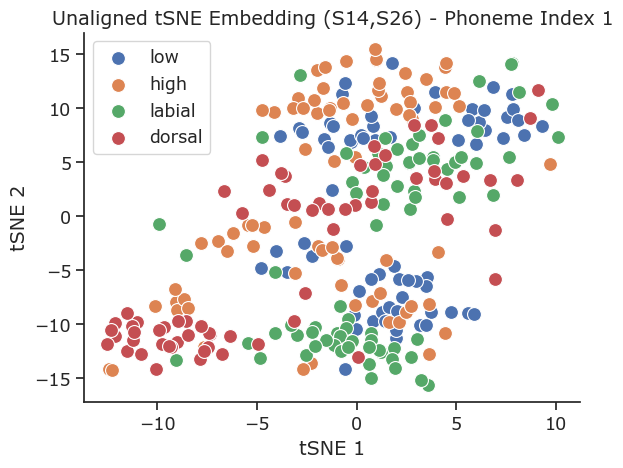

In [260]:
pts = ['S14', 'S26']

curr_unalgn = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
min_dim = min(u.shape[-1] for u in curr_unalgn)
curr_unalgn = np.vstack([curr_unalgn[i][:,:min_dim].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i,pt in enumerate(pts)])
curr_unalgn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])

t_pca_comp = 0.8
unalgn_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_unalgn.reshape(curr_unalgn.shape[0], -1))
unalgn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(unalgn_time_pca)

sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
plt.figure()
for lab in np.unique(curr_unalgn_labels):
    sns.scatterplot(x=-unalgn_embed_time[np.where(curr_unalgn_labels == lab)[0],1], y=-unalgn_embed_time[np.where(curr_unalgn_labels == lab)[0],0], s=100)
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title(f'Unaligned tSNE Embedding ({",".join(pts)}) - Phoneme Index {p_ind}')
plt.legend(labels=curr_label_names)

sns.despine()
plt.show()

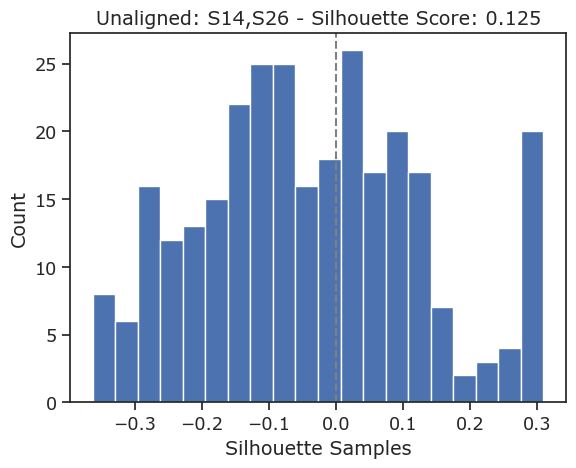

In [261]:
unalgn_sils = silhouette_samples(unalgn_embed_time, curr_unalgn_labels)
unalgn_sil_score = np.mean(unalgn_sils[np.where(unalgn_sils > 0)])
plt.figure()
plt.hist(unalgn_sils, bins=20)
plt.axvline(0, color='grey', linestyle='dashed')
plt.xlabel('Silhouette Samples')
plt.ylabel('Count')
plt.title(f'Unaligned: {",".join(pts)} - Silhouette Score: {unalgn_sil_score:.3f}')
plt.show()

#### CCA-Aligned

In [168]:
pts = ['S14', 'S26']
# aligner = AlignCCA(return_space='shared')
aligner = AlignCCA()
to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pts)]
# [x.shape for x in to_align]
to_align_seqs = [all_pt_phon_seqs[pt] for pt in pts]
aligner.fit(to_align[0], to_align[1], to_align_seqs[0], to_align_seqs[1])
# aligned_data = aligner.transform(to_align)
aligned_pt_data = aligner.transform(to_align[1])
aligned_data = [to_align[0], aligned_pt_data]

In [169]:
curr_algn = np.vstack(aligned_data)
curr_algn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])

t_pca_comp = 0.8
algn_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_algn.reshape(curr_algn.shape[0], -1))
algn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(algn_time_pca)
# algn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(curr_algn.reshape(curr_algn.shape[0], -1))

algn_tsne_df = pd.DataFrame(algn_embed_time, columns=['tSNE 1', 'tSNE 2'])
algn_tsne_df['Patient'] = [pts[0]]*all_pt_traces[pts[0]].shape[0] + [pts[1]]*all_pt_traces[pts[1]].shape[0]
algn_tsne_df['Label'] = curr_algn_labels
algn_tsne_df['Label'] = algn_tsne_df['Label'].apply(lambda x: curr_label_names[x-1])

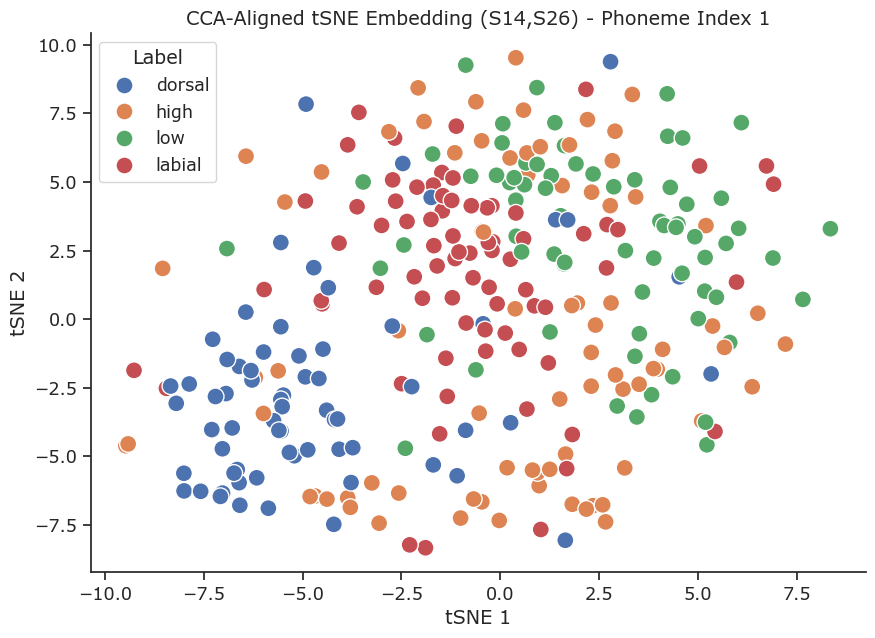

In [170]:


# sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
# plt.figure()
# for lab in np.unique(curr_algn_labels):
#     sns.scatterplot(x=-algn_embed_time[np.where(curr_algn_labels == lab)[0],1], y=-algn_embed_time[np.where(curr_algn_labels == lab)[0],0], s=100)
# plt.xlabel('tSNE 1')
# plt.ylabel('tSNE 2')
# plt.title(f'Aligned tSNE Embedding ({",".join(pts)}) - Phoneme Index {p_ind}')
# plt.legend(labels=curr_label_names)

# sns.despine()
# plt.show()


sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
f,ax = plt.subplots(1,1,figsize=(10,7))
# sns.scatterplot(data=algn_tsne_df, x='tSNE 1', y='tSNE 2', hue='Label', style='Patient', markers=True, s=150, ax=ax)
sns.scatterplot(data=algn_tsne_df, x='tSNE 1', y='tSNE 2', hue='Label', markers=True, s=150, ax=ax)
plt.title(f'CCA-Aligned tSNE Embedding ({",".join(pts)}) - Phoneme Index {p_ind}')
sns.despine()
plt.show()

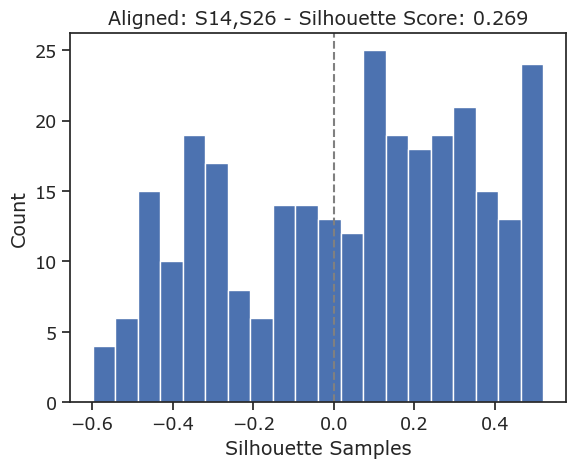

In [171]:
algn_sils = silhouette_samples(algn_embed_time, curr_algn_labels)
algn_sil_score = np.mean(algn_sils[np.where(algn_sils > 0)])
plt.figure()
plt.hist(algn_sils, bins=20)
plt.axvline(0, color='grey', linestyle='dashed')
plt.xlabel('Silhouette Samples')
plt.ylabel('Count')
plt.title(f'Aligned: {",".join(pts)} - Silhouette Score: {algn_sil_score:.3f}')
plt.show()

In [179]:
n_iter = 50
pts = ['S14', 'S26']
unalgn_sil_scores = np.zeros(n_iter)
unalgn_sil_scores_shuf = np.zeros(n_iter)
align_sil_scores = np.zeros(n_iter)
align_sil_scores_shuf = np.zeros(n_iter)
for i in range(n_iter):
    curr_unalgn = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
    min_dim = min(u.shape[-1] for u in curr_unalgn)
    curr_unalgn = np.vstack([curr_unalgn[i][:,:min_dim].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i,pt in enumerate(pts)])
    curr_unalgn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])
    unalgn_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_unalgn.reshape(curr_unalgn.shape[0], -1))
    unalgn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(unalgn_time_pca)
    unalgn_sils = silhouette_samples(unalgn_embed_time, curr_unalgn_labels)
    unalgn_sils_shuf = silhouette_samples(unalgn_embed_time, np.random.permutation(curr_unalgn_labels))
    unalgn_score = np.mean(unalgn_sils[np.where(unalgn_sils > 0)])
    unalgn_score_shuf = np.mean(unalgn_sils_shuf[np.where(unalgn_sils_shuf > 0)])
    unalgn_sil_scores[i] = unalgn_score
    unalgn_sil_scores_shuf[i] = unalgn_score_shuf
    
    aligner = AlignCCA()
    to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
    to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pts)]
    # [x.shape for x in to_align]
    to_align_seqs = [all_pt_phon_seqs[pt] for pt in pts]
    aligner.fit(to_align[0], to_align[1], to_align_seqs[0], to_align_seqs[1])
    # aligned_data = aligner.transform(to_align)
    aligned_pt_data = aligner.transform(to_align[1])
    aligned_data = [to_align[0], aligned_pt_data]
    curr_algn = np.vstack(aligned_data)
    curr_algn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])
    algn_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_algn.reshape(curr_algn.shape[0], -1))
    algn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(algn_time_pca)
    algn_sils = silhouette_samples(algn_embed_time, curr_algn_labels)
    algn_sils_shuf = silhouette_samples(algn_embed_time, np.random.permutation(curr_algn_labels))
    algn_score = np.mean(algn_sils[np.where(algn_sils > 0)])
    algn_score_shuf = np.mean(algn_sils_shuf[np.where(algn_sils_shuf > 0)])
    align_sil_scores[i] = algn_score
    align_sil_scores_shuf[i] = algn_score_shuf


In [184]:
sil_df_real = pd.DataFrame({'Unaligned': unalgn_sil_scores, 'Aligned': align_sil_scores})
sil_df_real_long = sil_df_real.melt(var_name='Data', value_name='Silhouette Score')
sil_df_shuf = pd.DataFrame({'Unaligned': unalgn_sil_scores_shuf, 'Aligned': align_sil_scores_shuf})
sil_df_shuf_long = sil_df_shuf.melt(var_name='Data', value_name='Silhouette Score')
sil_df_real_long['Condition'] = 'Articulatory Features'
sil_df_shuf_long['Condition'] = 'Chance Distribution'
sil_df_long = pd.concat([sil_df_real_long, sil_df_shuf_long], ignore_index=True)


In [190]:
fig = px.box(sil_df_long, color='Condition', y="Silhouette Score", x='Data', points='all', width=700, height=500)
fig.add_hline(y=ps_sil_df_long['Silhouette Score'].mean(), line_dash='dash', line_color='grey', annotation_text='Patient-Specific', annotation_position='bottom left')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text=f'Clustering with CCA Alignment - {",".join(pts)}',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1],
    # range=[-0.5, 3.5],
    # ticktext=['Patient-Specific', 'Shared Neural<br>Latent Space'],
)
fig.update_yaxes(
    title='Silhouette Score',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[0, 0.38]
)
fig.show()

### CCA Correlations

In [351]:
all_pt_phon_seqs.keys()
# print(all_pt_phon_seqs['S14'])
# print(all_pt_artic_seqs['S14'])
# print(all_pt_cv_labels['S14'])

dict_keys(['S14', 'S26', 'S23', 'S33', 'S22', 'S39', 'S58', 'S62'])

In [416]:
align_pt = 'S14'
align_pt_ind = pt_names.index(align_pt)

# setup CCA aligners for each condition and patient
aligners = {}
aligners_artic = {}
aligners_cv = {}
# aligners_all = {}
aligners_shuffle = {}
for i, pt in enumerate(pt_names):
    if i == align_pt_ind:
        continue
    aligners[pt] = AlignCCA()
    aligners_shuffle[pt] = AlignCCA()
    aligners_artic[pt] = AlignCCA()
    aligners_cv[pt] = AlignCCA()
    # aligners_all[pt] = AlignCCA()

# get patient-specific latent dynamics with PCA on channels
to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pts)]

# align patient-specific latent dynamics
aligned_data = {}
aligned_data_shuffle = {}
aligned_data_artic = {}
aligned_data_cv = {}
# aligned_data_all = {}

# aligning all patients to a single patient's space, so the align patient's latent dynamics are un-transformed
aligned_data[pt_names[align_pt_ind]] = to_align[align_pt_ind]
aligned_data_shuffle[pt_names[align_pt_ind]] = to_align[align_pt_ind]
aligned_data_artic[pt_names[align_pt_ind]] = to_align[align_pt_ind]
aligned_data_cv[pt_names[align_pt_ind]] = to_align[align_pt_ind]
# aligned_data_all[pt_names[align_pt_ind]] = to_align[align_pt_ind]
for i, pt in enumerate(pt_names):
    if i == align_pt_ind:
        continue
    
    # align by phoneme sequence
    to_align_seqs = [all_pt_phon_seqs[pt_names[align_pt_ind]], all_pt_phon_seqs[pt]]
    aligners[pt].fit(to_align[align_pt_ind], to_align[i], to_align_seqs[0], to_align_seqs[1])
    aligned_data[pt] = aligners[pt].transform(to_align[i])

    # align by shuffled phoneme sequence
    to_align_seqs_shuffle = [all_pt_phon_seqs[pt_names[align_pt_ind]], np.random.permutation(all_pt_phon_seqs[pt])]
    aligners_shuffle[pt].fit(to_align[align_pt_ind], to_align[i], to_align_seqs_shuffle[0], to_align_seqs_shuffle[1])
    aligned_data_shuffle[pt] = aligners_shuffle[pt].transform(to_align[i])

    # align by articulatory sequence
    to_align_seqs_artic = [all_pt_artic_seqs[pt_names[align_pt_ind]], all_pt_artic_seqs[pt]]
    aligners_artic[pt].fit(to_align[align_pt_ind], to_align[i], to_align_seqs_artic[0], to_align_seqs_artic[1])
    aligned_data_artic[pt] = aligners_artic[pt].transform(to_align[i])

    # align by syllable sequence
    to_align_seqs_cv = [all_pt_cv_labels[pt_names[align_pt_ind]], all_pt_cv_labels[pt]]
    aligners_cv[pt].fit(to_align[align_pt_ind], to_align[i], to_align_seqs_cv[0], to_align_seqs_cv[1])
    aligned_data_cv[pt] = aligners_cv[pt].transform(to_align[i])

    # to_align_seqs_all = [np.ones_like(all_pt_phon_seqs[pt_names[align_pt_ind]]), np.ones_like(all_pt_phon_seqs[pt])]
    # aligners_all[pt].fit(to_align[align_pt_ind], to_align[i], to_align_seqs_all[0], to_align_seqs_all[1])
    # aligned_data_all[pt] = aligners_all[pt].transform(to_align[i])

In [353]:
from scipy.stats import pearsonr

# def pt_corr(target, to_corr, target_labels, to_corr_labels, n_comp=25, t_range=[-0.25, 0.25]):
#     min_dim = np.min([target.shape[-1], to_corr.shape[-1], n_comp])
#     # get data only around speech onset
#     t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
#     target = target[:, t_inds]
#     to_corr = to_corr[:, t_inds]
#     cnd_avg_data = utils.extract_group_conditions([target, to_corr], [target_labels, to_corr_labels])
#     n_cnds = cnd_avg_data[0].shape[0]
#     cnd_r = np.zeros(n_cnds)
#     for i in range(cnd_avg_data[0].shape[0]):
#         target_avg = cnd_avg_data[0][i,:,:min_dim]
#         to_corr_avg = cnd_avg_data[1][i,:,:min_dim]

#         r_vals = np.zeros(min_dim)
#         for j in range(min_dim):
#             r_vals[j] = pearsonr(target_avg[:,j], to_corr_avg[:,j])[0]
#         cnd_r[i] = np.mean(r_vals)
#     return cnd_r

def pt_corr(target, to_corr, target_labels, to_corr_labels, n_comp=25, t_range=[-0.25, 0.25], n_iter=100):
    min_dim = np.min([target.shape[-1], to_corr.shape[-1], n_comp])
    min_trials = np.min([target.shape[0], to_corr.shape[0]])

    # get data only around speech onset
    t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
    target = target[:, t_inds]
    to_corr = to_corr[:, t_inds]
    
    # times = np.zeros(n_iter)
    trial_r = np.zeros(n_iter)
    for i in range(n_iter): # create correlation distribution over iterations
        # subselect an equal number of trials
        target_sample = target[np.random.choice(target.shape[0], min_trials, replace=False)]
        to_corr_sample = to_corr[np.random.choice(to_corr.shape[0], min_trials, replace=False)]

        # corrcoef returns a 2*min_trials by 2*min_trials matrix that is the correlation between each trial
        # (withing and across inputs), so we extract the upper right block of the matrix to get correlations between
        # target and to_corr trials. I'm just extracting the diagonal now to get a correlation value for each trial
        # but since trials are randomly selected I could also just use the whole upper right block probably
        # start = time.time()
        r_vals = np.array([np.diag(np.corrcoef(target_sample[:,:,j], to_corr_sample[:,:,j])[:min_trials,min_trials:]) for j in range(min_dim)])
        trial_r[i] = np.mean(r_vals)
        # times[i] = time.time() - start
    # print(f'Average time: {np.mean(times):.3f} s')
    return trial_r

def pt_corr_multi(target, to_corr_list, target_labels, to_corr_labels_list, n_comp=25, t_range=[-0.25, 0.25]):
    cnd_r = []
    for i, to_corr in enumerate(to_corr_list):
        cnd_r.append(pt_corr(target, to_corr, target_labels, to_corr_labels_list[i], n_comp=n_comp, t_range=t_range))
    return cnd_r


In [354]:
n_comp_corr = 10

# unalign_corrs = pt_corr_multi(to_align[0], to_align[1:], all_pt_phon_seqs[pts[0]], [all_pt_phon_seqs[pt] for pt in pts[1:]], n_comp=n_comp_corr)
# align_corrs = pt_corr_multi(aligned_data[0], aligned_data[1:], all_pt_phon_seqs[pts[0]], [all_pt_phon_seqs[pt] for pt in pts[1:]], n_comp=n_comp_corr)
# shuff_corrs = pt_corr_multi(shuff_aligned_data[0], shuff_aligned_data[1:], all_pt_phon_seqs[pts[0]], [all_pt_phon_seqs[pt] for pt in pts[1:]], n_comp=n_comp_corr)

other_pts = [pt for pt in pt_names if pt != align_pt]
unalign_corrs = pt_corr_multi(to_align[align_pt_ind], [to_align[pt_names.index(pt)] for pt in other_pts], all_pt_artic_labels[align_pt], [all_pt_artic_labels[pt] for pt in other_pts], n_comp=n_comp_corr)
align_corrs = pt_corr_multi(aligned_data[align_pt], [aligned_data[pt] for pt in other_pts], all_pt_artic_labels[align_pt], [all_pt_artic_labels[pt] for pt in other_pts], n_comp=n_comp_corr)
# shuff_corrs = pt_corr_multi(aligned_data_shuffle[align_pt], [aligned_data_shuffle[pt] for pt in other_pts], all_pt_artic_labels[align_pt], [all_pt_artic_labels[pt] for pt in other_pts], n_comp=n_comp_corr)
align_corrs_artic = pt_corr_multi(aligned_data_artic[align_pt], [aligned_data_artic[pt] for pt in other_pts], all_pt_artic_labels[align_pt], [all_pt_artic_labels[pt] for pt in other_pts], n_comp=n_comp_corr)
align_corrs_cv = pt_corr_multi(aligned_data_cv[align_pt], [aligned_data_cv[pt] for pt in other_pts], all_pt_cv_labels[align_pt], [all_pt_cv_labels[pt] for pt in other_pts], n_comp=n_comp_corr)
# align_corrs_all = pt_corr_multi(aligned_data_all[align_pt], [aligned_data_all[pt] for pt in other_pts], np.ones_like(all_pt_phon_seqs[align_pt]), [np.ones_like(all_pt_phon_seqs[pt]) for pt in other_pts], n_comp=n_comp_corr)
# align_corrs = pt_corr_multi(aligned_data[align_pt_ind], aligned_data[1:], all_pt_phon_labels[pts[0]], [all_pt_phon_labels[pt] for pt in pts[1:]], n_comp=n_comp_corr)
# align_corrs_artic = pt_corr_multi(aligned_data_artic[align_pt_ind], aligned_data_artic[1:], all_pt_artic_labels[pts[0]], [all_pt_artic_labels[pt] for pt in pts[1:]], n_comp=n_comp_corr)
# align_corrs_cv = pt_corr_multi(aligned_data_cv[align_pt_ind], aligned_data_cv[1:], all_pt_cv_labels[pts[0]], [all_pt_cv_labels[pt] for pt in pts[1:]], n_comp=n_comp_corr)
# align_corrs_all = pt_corr_multi(aligned_data_all[align_pt_ind], aligned_data_all[1:], np.ones_like(all_pt_phon_seqs[pts[0]]), [np.ones_like(all_pt_phon_seqs[pt]) for pt in pts[1:]], n_comp=n_comp_corr)
# shuff_corrs = pt_corr_multi(shuff_aligned_data[0], shuff_aligned_data[1:], all_pt_artic_labels[pts[0]], [all_pt_artic_labels[pt] for pt in pts[1:]], n_comp=n_comp_corr)

# unalign_corrs = pt_corr_multi(to_align[0], to_align[1:], np.zeros(all_pt_phon_seqs[pts[0]].shape[0]), [np.zeros(all_pt_phon_seqs[pt].shape[0]) for pt in pts[1:]], n_comp=n_comp_corr)
# align_corrs = pt_corr_multi(aligned_data[0], aligned_data[1:], np.zeros(all_pt_phon_seqs[pts[0]].shape[0]), [np.zeros(all_pt_phon_seqs[pt].shape[0]) for pt in pts[1:]], n_comp=n_comp_corr)

In [288]:
# combine unaligned and aligned correlations in dataframe for plotting
corr_df = pd.DataFrame()
corr_df_mean = pd.DataFrame()
for i, pt in enumerate(other_pts):
    # curr_pt = f'S{i+2}'
    curr_pt = pt
    pt_unalign_corr = pd.DataFrame({'Correlation': unalign_corrs[i]})
    pt_unalign_corr['Condition'] = 'Unaligned'
    pt_unalign_corr['Patient'] = curr_pt
    pt_unalign_corr['Error'] = 0

    pt_align_corr = pd.DataFrame({'Correlation': align_corrs[i]})
    pt_align_corr['Condition'] = 'Phoneme-aligned'
    pt_align_corr['Patient'] = curr_pt
    pt_align_corr['Error'] = 0

    # pt_align_corr_shuff = pd.DataFrame({'Correlation': shuff_corrs[i]})
    # pt_align_corr_shuff['Condition'] = 'Aligned to S1 - Shuffled'
    # pt_align_corr_shuff['Patient'] = curr_pt
    # pt_align_corr_shuff['Error'] = 0

    pt_align_corr_artic = pd.DataFrame({'Correlation': align_corrs_artic[i]})
    pt_align_corr_artic['Condition'] = 'Articulator-aligned'
    pt_align_corr_artic['Patient'] = curr_pt
    pt_align_corr_artic['Error'] = 0

    pt_align_corr_cv = pd.DataFrame({'Correlation': align_corrs_cv[i]})
    pt_align_corr_cv['Condition'] = 'Syllable-aligned'
    pt_align_corr_cv['Patient'] = curr_pt
    pt_align_corr_cv['Error'] = 0

    # pt_align_corr_all = pd.DataFrame({'Correlation': align_corrs_all[i]})
    # pt_align_corr_all['Condition'] = 'Single label'
    # pt_align_corr_all['Patient'] = curr_pt
    # pt_align_corr_all['Error'] = 0

    # corr_df_mean = pd.concat([corr_df_mean, pd.DataFrame({'Correlation': [np.mean(unalign_corrs[i]), np.mean(align_corrs[i])],
    #                                                     'Condition': ['Unaligned', f'Aligned to {align_pt}'],
    #                                                     'Patient': [curr_pt, curr_pt]})], ignore_index=True)

    # corr_df = pd.concat([corr_df, pt_unalign_corr, pt_align_corr], ignore_index=True) 

    corr_df_mean = pd.concat([corr_df_mean, pd.DataFrame({'Correlation': [np.mean(unalign_corrs[i]), np.mean(align_corrs[i]),
                                                                          np.mean(align_corrs_artic[i]), np.mean(align_corrs_cv[i])],
                                                          'Condition': ['Unaligned', f'Phoneme-aligned', 'Articulator-aligned','Syllable-aligned'],
                                                          'Patient': [curr_pt, curr_pt, curr_pt, curr_pt]})], ignore_index=True)
    corr_df = pd.concat([corr_df, pt_unalign_corr, pt_align_corr, pt_align_corr_artic, pt_align_corr_cv], ignore_index=True)

    # corr_df_mean = pd.concat([corr_df_mean, pd.DataFrame({'Correlation': [np.mean(unalign_corrs[i]), np.mean(align_corrs[i]), np.mean(shuff_corrs[i])],
    #                                                       'Condition': ['Unaligned', 'Aligned to S1', 'Aligned to S1 - Shuffled'],
    #                                                       'Patient': [curr_pt, curr_pt, curr_pt]})], ignore_index=True)
    # corr_df = pd.concat([corr_df, pt_unalign_corr, pt_align_corr, pt_align_corr_shuff], ignore_index=True) 

In [457]:
fig = px.line(corr_df_mean, x='Condition', y="Correlation", color='Patient', width=800, height=500, color_discrete_sequence=px.colors.qualitative.Plotly[1:])
# fig.update_traces(mode='lines')
fig.add_traces(px.box(corr_df_mean, x='Condition', y="Correlation").data)
# fig = px.box(corr_df, x='Condition', y="Correlation", width=800, height=500)
# fig.add_traces(px.line(corr_df, x='Condition', y="Correlation", color='Patient', error_y='Error').data)
# fig.update_traces(mode='markers+lines')
# fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text=f'Correlation with {align_pt} Latent Dynamics',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1],
    # range=[-0.35, 1.35],
    # ticktext=['Patient-Specific', 'Shared Neural<br>Latent Space'],
)
fig.update_yaxes(
    title='Pearson <i>r</i>',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[-0.025, 0.1]
)
fig.show()

In [290]:
import scipy.stats as stats

pvals = []

# test for significant difference between unaligned and aligned correlations
print('Unaligned vs. Phoneme Aligned')
res_un_phon = stats.wilcoxon(corr_df[corr_df['Condition'] == 'Unaligned']['Correlation'], corr_df[corr_df['Condition'] == 'Phoneme-aligned']['Correlation'], alternative='less')
print(res_un_phon)
pvals.append(res_un_phon.pvalue)

# print('Aligned vs. Shuffle-Aligned')
# res_shuf = stats.wilcoxon(corr_df[corr_df['Condition'] == 'Aligned to S1']['Correlation'], corr_df[corr_df['Condition'] == 'Aligned to S1 - Shuffled']['Correlation'], alternative='greater')
# print(res_shuf)
# pvals.append(res_shuf.pvalue)

print('Unaligned vs. Articulator Aligned')
res_un_artic = stats.wilcoxon(corr_df[corr_df['Condition'] == 'Unaligned']['Correlation'], corr_df[corr_df['Condition'] == 'Articulator-aligned']['Correlation'], alternative='less')
print(res_un_artic)
pvals.append(res_un_artic.pvalue)

print('Unaligned vs. Syllable Aligned')
res_un_cv = stats.wilcoxon(corr_df[corr_df['Condition'] == 'Unaligned']['Correlation'], corr_df[corr_df['Condition'] == 'Syllable-aligned']['Correlation'], alternative='less')
print(res_un_cv)
pvals.append(res_un_cv.pvalue)

print('Phoneme Aligned vs. Articulator Aligned')
res_phon_artic = stats.wilcoxon(corr_df[corr_df['Condition'] == 'Phoneme-aligned']['Correlation'], corr_df[corr_df['Condition'] == 'Articulator-aligned']['Correlation'], alternative='two-sided')
print(res_phon_artic)
pvals.append(res_phon_artic.pvalue)

print('Phoneme Aligned vs. Syllable Aligned')
res_phon_cv = stats.wilcoxon(corr_df[corr_df['Condition'] == 'Phoneme-aligned']['Correlation'], corr_df[corr_df['Condition'] == 'Syllable-aligned']['Correlation'], alternative='greater')
print(res_phon_cv)
pvals.append(res_phon_cv.pvalue)

print('Articulator Aligned vs. Syllable Aligned')
res_artic_cv = stats.wilcoxon(corr_df[corr_df['Condition'] == 'Articulator-aligned']['Correlation'], corr_df[corr_df['Condition'] == 'Syllable-aligned']['Correlation'], alternative='greater')
print(res_artic_cv)


from statsmodels.stats.multitest import fdrcorrection

p_vals_cor = fdrcorrection(pvals)[1]
print(p_vals_cor)


Unaligned vs. Phoneme Aligned
WilcoxonResult(statistic=1639.0, pvalue=1.5490488222959898e-113)
Unaligned vs. Articulator Aligned
WilcoxonResult(statistic=5874.0, pvalue=6.935680931840222e-106)
Unaligned vs. Syllable Aligned
WilcoxonResult(statistic=16528.0, pvalue=7.742277616753625e-88)
Phoneme Aligned vs. Articulator Aligned
WilcoxonResult(statistic=75450.0, pvalue=1.1074353175673362e-18)
Phoneme Aligned vs. Syllable Aligned
WilcoxonResult(statistic=208042.0, pvalue=1.4179184135761722e-57)
Articulator Aligned vs. Syllable Aligned
WilcoxonResult(statistic=175756.0, pvalue=1.7408416843791856e-23)
[7.74524411e-113 1.73392023e-105 1.29037960e-087 1.10743532e-018
 1.77239802e-057]


In [498]:
from scipy.stats import permutation_test

def statistic(a, b):
    return np.mean(a) - np.mean(b)
perm_type = 'samples'

stat_df = corr_df_mean

# test for significant difference between unaligned and aligned correlations
print('Unaligned vs. Phoneme Aligned')
un_corrs = stat_df[stat_df['Condition'] == 'Unaligned']['Correlation']
phon_corrs = stat_df[stat_df['Condition'] == 'Phoneme-aligned']['Correlation']
res_un_phon = permutation_test((un_corrs, phon_corrs), statistic, permutation_type=perm_type, alternative='less')
print(res_un_phon.pvalue)

print('Unaligned vs. Articulator Aligned')
artic_corrs = stat_df[stat_df['Condition'] == 'Articulator-aligned']['Correlation']
res_un_artic = permutation_test((un_corrs, artic_corrs), statistic, permutation_type=perm_type, alternative='less')
print(res_un_artic.pvalue)

print('Unaligned vs. Syllable Aligned')
cv_corrs = stat_df[stat_df['Condition'] == 'Syllable-aligned']['Correlation']
res_un_cv = permutation_test((un_corrs, cv_corrs), statistic, permutation_type=perm_type, alternative='less')
print(res_un_cv.pvalue)

print('Phoneme Aligned vs. Articulator Aligned')
res_phon_artic = permutation_test((phon_corrs, artic_corrs), statistic, permutation_type=perm_type, alternative='two-sided')
print(res_phon_artic.pvalue)

print('Phoneme Aligned vs. Syllable Aligned')
res_phon_cv = permutation_test((phon_corrs, cv_corrs), statistic, permutation_type=perm_type, alternative='greater')
print(res_phon_cv.pvalue)

print('Articulator Aligned vs. Syllable Aligned')
res_artic_cv = permutation_test((artic_corrs, cv_corrs), statistic, permutation_type=perm_type, alternative='greater')
print(res_artic_cv.pvalue)


Unaligned vs. Phoneme Aligned
0.0078125
Unaligned vs. Articulator Aligned
0.0078125
Unaligned vs. Syllable Aligned
0.0078125
Phoneme Aligned vs. Articulator Aligned
0.015625
Phoneme Aligned vs. Syllable Aligned
0.0078125
Articulator Aligned vs. Syllable Aligned
0.015625


### Clustering Strength by Alignment Type

In [479]:
all_pt_cv_labels_num = {}
for pt in pt_names:
    cv_num = np.zeros(all_pt_cv_labels[pt].shape, dtype=int)
    cv_num += np.array(all_pt_cv_labels[pt] == 'VCV', dtype=int)
    all_pt_cv_labels_num[pt] = cv_num

In [546]:
to_align[0].shape

(144, 200, 25)

In [548]:
# import tsne
from sklearn.manifold import TSNE

# curr_pts = ['S14', 'S33', 'S58', 'S62']
curr_pts = pt_names

curr_unalgn = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
min_dim = min(u.shape[-1] for u in curr_unalgn)
curr_unalgn = np.vstack([curr_unalgn[i][:,:min_dim].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i,pt in enumerate(pts)])
curr_unalgn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])
curr_label_names_artic = artic_labels

curr_algn_phon = np.vstack([aligned_data[pt] for pt in curr_pts])
curr_algn_labels_phon = np.hstack([all_pt_phon_labels[pt] for pt in curr_pts])
curr_label_names_phon = phon_labels

curr_algn_artic = np.vstack([aligned_data_artic[pt] for pt in curr_pts])
curr_algn_labels_artic = np.hstack([all_pt_artic_labels[pt] for pt in curr_pts])

curr_algn_cv = np.vstack([aligned_data_cv[pt] for pt in curr_pts])
curr_algn_labels_cv = np.hstack([all_pt_cv_labels_num[pt] for pt in curr_pts])
curr_label_names_cv = ['CVC', 'VCV']

t_pca_comp = 0.8
unalgn_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_unalgn.reshape(curr_unalgn.shape[0], -1))
algn_time_pca_phon = PCA(n_components=t_pca_comp).fit_transform(curr_algn_phon.reshape(curr_algn_phon.shape[0], -1))
algn_time_pca_artic = PCA(n_components=t_pca_comp).fit_transform(curr_algn_artic.reshape(curr_algn_artic.shape[0], -1))
algn_time_pca_cv = PCA(n_components=t_pca_comp).fit_transform(curr_algn_cv.reshape(curr_algn_cv.shape[0], -1))
# algn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(curr_algn.reshape(curr_algn.shape[0], -1))

In [608]:
from tqdm import tqdm

n_iter = 100
unalgn_scores = []
phon_scores = []
artic_scores = []
syl_scores = []
for i in tqdm(range(n_iter)):
    unalgn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(unalgn_time_pca)
    unalgn_sils = silhouette_samples(unalgn_embed_time, curr_unalgn_labels)
    unalgn_sil_score = np.mean(unalgn_sils[np.where(unalgn_sils > 0)])
    unalgn_scores.append(unalgn_sil_score)    

    algn_embed_time_phon = TSNE(n_components=2, perplexity=30).fit_transform(algn_time_pca_phon)
    phon_sils = silhouette_samples(algn_embed_time_phon, curr_algn_labels_phon)
    # phon_sils = silhouette_samples(algn_time_pca_phon, curr_algn_labels_phon)
    phon_sil_score = np.mean(phon_sils[np.where(phon_sils > 0)])
    phon_scores.append(phon_sil_score)

    algn_embed_time_artic = TSNE(n_components=2, perplexity=30).fit_transform(algn_time_pca_artic)
    artic_sils = silhouette_samples(algn_embed_time_artic, curr_algn_labels_artic)
    # artic_sils = silhouette_samples(algn_time_pca_artic, curr_algn_labels_artic)
    artic_sil_score = np.mean(artic_sils[np.where(artic_sils > 0)])
    artic_scores.append(artic_sil_score)

    algn_embed_time_cv = TSNE(n_components=2, perplexity=30).fit_transform(algn_time_pca_cv)
    cv_sils = silhouette_samples(algn_embed_time_cv, curr_algn_labels_cv)
    # cv_sils = silhouette_samples(algn_time_pca_cv, curr_algn_labels_cv)
    cv_sil_score = np.mean(cv_sils[np.where(cv_sils > 0)])
    syl_scores.append(cv_sil_score)

100%|██████████| 100/100 [1:01:02<00:00, 36.62s/it]


In [609]:
print(f'Unaligned: {np.mean(unalgn_scores):.3f} +/- {np.std(unalgn_scores):.3f}')
print(f'Phoneme Aligned: {np.mean(phon_scores):.3f} +/- {np.std(phon_scores):.3f}')
print(f'Articulator Aligned: {np.mean(artic_scores):.3f} +/- {np.std(artic_scores):.3f}')
print(f'Syllable Aligned: {np.mean(syl_scores):.3f} +/- {np.std(syl_scores):.3f}')

Unaligned: 0.030 +/- 0.006
Phoneme Aligned: 0.072 +/- 0.016
Articulator Aligned: 0.079 +/- 0.017
Syllable Aligned: 0.051 +/- 0.016


In [610]:
print(unalgn_scores)
print(phon_scores)
print(artic_scores)
print(syl_scores)

[0.034525525, 0.031808842, 0.035255305, 0.040803026, 0.026631152, 0.025279796, 0.03249629, 0.027822984, 0.03010814, 0.033941, 0.026204627, 0.023811938, 0.026563628, 0.030841582, 0.041262135, 0.02768879, 0.021653648, 0.031672418, 0.033905048, 0.018440168, 0.036602464, 0.037980974, 0.03004868, 0.031088626, 0.037748992, 0.032191735, 0.039086238, 0.02296294, 0.02127181, 0.03813351, 0.02320622, 0.027062293, 0.037707847, 0.031265195, 0.039616454, 0.028624116, 0.038467877, 0.031632375, 0.024561673, 0.030645441, 0.03817198, 0.024682837, 0.022260796, 0.027485609, 0.025882663, 0.017607301, 0.028072307, 0.026117742, 0.027450917, 0.036372326, 0.027207304, 0.02167758, 0.02711662, 0.022063177, 0.026633678, 0.021207418, 0.033534884, 0.024311772, 0.028264405, 0.03573319, 0.031916574, 0.026863901, 0.024821635, 0.02780682, 0.036596306, 0.052138314, 0.042572595, 0.035160407, 0.022727286, 0.034362935, 0.028589131, 0.020228466, 0.024508933, 0.034590926, 0.028878082, 0.02805025, 0.025994247, 0.02530854, 0.0

In [623]:
sil_df = pd.DataFrame({'Unaligned': unalgn_scores, 'Phoneme': phon_scores, 'Articulator': artic_scores, 'Syllable': syl_scores})
sil_df_long = sil_df.melt(var_name='Alignment Type', value_name='Silhouette Score')
sil_df_long

Alignment Type  Silhouette Score
0        Unaligned          0.034526
1        Unaligned          0.031809
2        Unaligned          0.035255
3        Unaligned          0.040803
4        Unaligned          0.026631
..             ...               ...
395       Syllable          0.047893
396       Syllable          0.049772
397       Syllable          0.057041
398       Syllable          0.026317
399       Syllable          0.050127

[400 rows x 2 columns]

In [641]:
sil_df = pd.DataFrame({'Unaligned': unalgn_scores, 'Phoneme': phon_scores, 'Articulator': artic_scores, 'Syllable': syl_scores})
sil_df_long = sil_df.melt(var_name='Alignment Type', value_name='Silhouette Score')
sil_df_long

Alignment Type  Silhouette Score
0        Unaligned          0.034526
1        Unaligned          0.031809
2        Unaligned          0.035255
3        Unaligned          0.040803
4        Unaligned          0.026631
..             ...               ...
395       Syllable          0.047893
396       Syllable          0.049772
397       Syllable          0.057041
398       Syllable          0.026317
399       Syllable          0.050127

[400 rows x 2 columns]

In [642]:
fig = px.box(sil_df_long, y="Silhouette Score", x='Alignment Type', points='all', width=700, height=500)
# fig.add_hline(y=ps_sil_df_long['Silhouette Score'].mean(), line_dash='dash', line_color='grey', annotation_text='Patient-Specific', annotation_position='bottom left')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text=f'Clustering Strength of Cross-Patient Data',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    # title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1],
    # range=[-0.5, 3.5],
    # ticktext=['Patient-Specific', 'Shared Neural<br>Latent Space'],
)
fig.update_yaxes(
    title='Silhouette Score',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[0, 0.15]
)
fig.show()

In [631]:
import scipy.stats as stats

pvals_sil = []

res_un_phon_sil = stats.mannwhitneyu(unalgn_scores, phon_scores, alternative='two-sided')
pvals_sil.append(res_un_phon_sil.pvalue)
res_un_artic_sil = stats.mannwhitneyu(unalgn_scores, artic_scores, alternative='two-sided')
pvals_sil.append(res_un_artic_sil.pvalue)
res_un_syl_sil = stats.mannwhitneyu(unalgn_scores, syl_scores, alternative='two-sided')
pvals_sil.append(res_un_syl_sil.pvalue)
res_phon_artic_sil = stats.mannwhitneyu(phon_scores, artic_scores, alternative='two-sided')
pvals_sil.append(res_phon_artic_sil.pvalue)
res_phon_syl_sil = stats.mannwhitneyu(phon_scores, syl_scores, alternative='two-sided')
pvals_sil.append(res_phon_syl_sil.pvalue)
res_artic_syl_sil = stats.mannwhitneyu(artic_scores, syl_scores, alternative='two-sided')
pvals_sil.append(res_artic_syl_sil.pvalue)


from statsmodels.stats.multitest import fdrcorrection
pvals_sil_cor = fdrcorrection(pvals_sil)[1]


print('Unaligned vs. Phoneme Aligned')
print(res_un_phon_sil)
print(pvals_sil_cor[0])
print()

print('Unaligned vs. Articulator Aligned')
print(res_un_artic_sil)
print(pvals_sil_cor[1])
print()

print('Unaligned vs. Syllable Aligned')
print(res_un_syl_sil)
print(pvals_sil_cor[2])
print()

print('Phoneme Aligned vs. Articulator Aligned')
print(res_phon_artic_sil)
print(pvals_sil_cor[3])
print()

print('Phoneme Aligned vs. Syllable Aligned')
print(res_phon_syl_sil)
print(pvals_sil_cor[4])
print()

print('Articulator Aligned vs. Syllable Aligned')
print(res_artic_syl_sil)
print(pvals_sil_cor[5])
print()


Unaligned vs. Phoneme Aligned
MannwhitneyuResult(statistic=101.0, pvalue=5.168440993868269e-33)
1.5505322981604808e-32

Unaligned vs. Articulator Aligned
MannwhitneyuResult(statistic=7.0, pvalue=3.1614009124474834e-34)
1.89684054746849e-33

Unaligned vs. Syllable Aligned
MannwhitneyuResult(statistic=1284.0, pvalue=1.1017102292291803e-19)
1.6525653438437704e-19

Phoneme Aligned vs. Articulator Aligned
MannwhitneyuResult(statistic=4089.0, pvalue=0.026101009323488487)
0.026101009323488487

Phoneme Aligned vs. Syllable Aligned
MannwhitneyuResult(statistic=8147.0, pvalue=1.4930908005160807e-14)
1.7917089606192966e-14

Articulator Aligned vs. Syllable Aligned
MannwhitneyuResult(statistic=8730.0, pvalue=8.04169146344994e-20)
1.608338292689988e-19



In [619]:
anova_res = stats.f_oneway(unalgn_scores, phon_scores, artic_scores, syl_scores)
print(anova_res)

F_onewayResult(statistic=229.57983064436, pvalue=2.836658030423861e-86)


In [621]:
tukey_res = stats.tukey_hsd(unalgn_scores, phon_scores, artic_scores, syl_scores)
print(tukey_res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.042     0.000    -0.048    -0.037
 (0 - 2)     -0.049     0.000    -0.054    -0.044
 (0 - 3)     -0.021     0.000    -0.027    -0.016
 (1 - 0)      0.042     0.000     0.037     0.048
 (1 - 2)     -0.006     0.011    -0.012    -0.001
 (1 - 3)      0.021     0.000     0.016     0.027
 (2 - 0)      0.049     0.000     0.044     0.054
 (2 - 1)      0.006     0.011     0.001     0.012
 (2 - 3)      0.028     0.000     0.022     0.033
 (3 - 0)      0.021     0.000     0.016     0.027
 (3 - 1)     -0.021     0.000    -0.027    -0.016
 (3 - 2)     -0.028     0.000    -0.033    -0.022



In [606]:
from scipy.stats import permutation_test

def statistic(a, b, axis):
    return np.mean(a, axis=axis) - np.mean(b, axis=axis)

# def statistic(a, b, axis):
#     return stats.ttest_ind(a,b, axis).statistic

# statistic = stats.ttest_ind

perm_type = 'independent'
n_resamples = 100000

pvals_sil_perm = []

res_un_phon_sil_perm = permutation_test((unalgn_scores, phon_scores), statistic, permutation_type=perm_type, alternative='less', n_resamples=n_resamples, vectorized=True)
pvals_sil_perm.append(res_un_phon_sil_perm.pvalue)
res_un_artic_sil_perm = permutation_test((unalgn_scores, artic_scores), statistic, permutation_type=perm_type, alternative='less', n_resamples=n_resamples, vectorized=True)
pvals_sil_perm.append(res_un_artic_sil_perm.pvalue)
res_un_syl_sil_perm = permutation_test((unalgn_scores, syl_scores), statistic, permutation_type=perm_type, alternative='less', n_resamples=n_resamples, vectorized=True)
pvals_sil_perm.append(res_un_syl_sil_perm.pvalue)
res_phon_artic_sil_perm = permutation_test((phon_scores, artic_scores), statistic, permutation_type=perm_type, alternative='two-sided', n_resamples=n_resamples, vectorized=True)
pvals_sil_perm.append(res_phon_artic_sil_perm.pvalue)
res_phon_syl_sil_perm = permutation_test((phon_scores, syl_scores), statistic, permutation_type=perm_type, alternative='greater', n_resamples=n_resamples, vectorized=True)
pvals_sil_perm.append(res_phon_syl_sil_perm.pvalue)
res_artic_syl_sil_perm = permutation_test((artic_scores, syl_scores), statistic, permutation_type=perm_type, alternative='greater', n_resamples=n_resamples, vectorized=True)
pvals_sil_perm.append(res_artic_syl_sil_perm.pvalue)

pvals_sil_perm_cor = fdrcorrection(pvals_sil_perm)[1]

print('Unaligned vs. Phoneme Aligned')
print(res_un_phon_sil_perm.pvalue)
print(pvals_sil_perm_cor[0])

print('Unaligned vs. Articulator Aligned')
print(res_un_artic_sil_perm.pvalue)
print(pvals_sil_perm_cor[1])

print('Unaligned vs. Syllable Aligned')
print(res_un_syl_sil_perm.pvalue)
print(pvals_sil_perm_cor[2])

print('Phoneme Aligned vs. Articulator Aligned')
print(res_phon_artic_sil_perm.pvalue)
print(pvals_sil_perm_cor[3])

print('Phoneme Aligned vs. Syllable Aligned')
print(res_phon_syl_sil_perm.pvalue)
print(pvals_sil_perm_cor[4])

print('Articulator Aligned vs. Syllable Aligned')
print(res_artic_syl_sil_perm.pvalue)
print(pvals_sil_perm_cor[5])

Unaligned vs. Phoneme Aligned
9.99990000099999e-06
1.1999880001199989e-05
Unaligned vs. Articulator Aligned
9.99990000099999e-06
1.1999880001199989e-05
Unaligned vs. Syllable Aligned
9.99990000099999e-06
1.1999880001199989e-05
Phoneme Aligned vs. Articulator Aligned
0.016559834401655982
0.016559834401655982
Phoneme Aligned vs. Syllable Aligned
9.99990000099999e-06
1.1999880001199989e-05
Articulator Aligned vs. Syllable Aligned
9.99990000099999e-06
1.1999880001199989e-05


In [594]:
algn_tsne_df = pd.DataFrame(algn_embed_time_artic, columns=['tSNE 1', 'tSNE 2'])
# algn_tsne_df['Patient'] = [pts[0]]*all_pt_traces[pts[0]].shape[0] + [pts[1]]*all_pt_traces[pts[1]].shape[0]
algn_tsne_df['Patient'] = sum([[pt]*all_pt_traces[pt].shape[0] for pt in curr_pts], [])
algn_tsne_df['Label'] = curr_algn_labels_artic
algn_tsne_df['Label'] = algn_tsne_df['Label'].apply(lambda x: curr_label_names_artic[x-1])

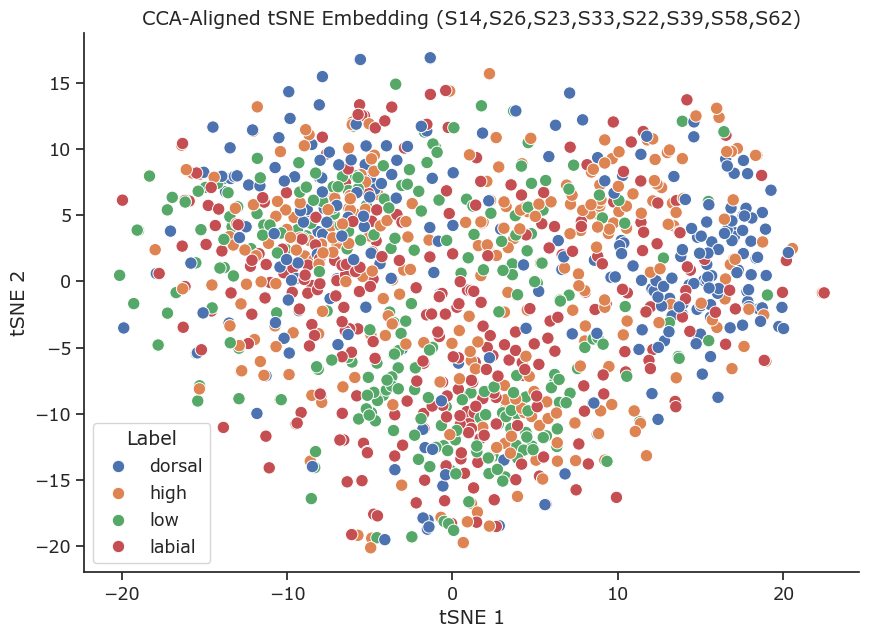

In [595]:
sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
f,ax = plt.subplots(1,1,figsize=(10,7))
# sns.scatterplot(data=algn_tsne_df, x='tSNE 1', y='tSNE 2', hue='Label', style='Patient', markers=True, s=150, ax=ax)
sns.scatterplot(data=algn_tsne_df, x='tSNE 1', y='tSNE 2', hue='Label', markers=True, s=80, ax=ax)
plt.title(f'CCA-Aligned tSNE Embedding ({",".join(curr_pts)})')
sns.despine()
plt.show()

In [484]:
from sklearn.metrics import silhouette_samples

ps_sils = silhouette_samples(algn_embed_time, curr_algn_labels)
ps_sil_score = np.mean(ps_sils[np.where(ps_sils > 0)])
print(ps_sil_score)

0.14573388


### CCA component investigation

In [267]:
pts = ['S14', 'S26']
aligner = AlignCCA(return_space='shared')
to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pts)]
# [x.shape for x in to_align]
to_align_seqs = [all_pt_phon_seqs[pt] for pt in pts]
aligner.fit(to_align[0], to_align[1], to_align_seqs[0], to_align_seqs[1])
aligned_data = aligner.transform(to_align)

In [271]:
t = np.linspace(-0.5, 0.5 - 1/aligned_data[0].shape[1], aligned_data[0].shape[1])

In [283]:
wide_dfs = []
long_dfs = []
for i, pt in enumerate(pts):
    d = aligned_data[i]
    n_tr = d.shape[0]
    d = d.reshape(-1, d.shape[-1])
    df = pd.DataFrame(d, columns=[f'CC {i+1}' for i in range(d.shape[-1])])
    df['Time'] = np.tile(t, n_tr)
    df['Patient'] = [pt] * d.shape[0]
    df['Phoneme IDs'] = np.repeat(all_pt_phon_seqs_str[pt], t.shape[0])
    df['Vowel Sequence'] = df['Phoneme IDs'].apply(labels2cv)
    df['Phoneme Sequence'] = df['Phoneme IDs'].apply(lambda x: ''.join([phon_labels[int(i)-1] for i in x]))
    df['Articulator Sequence'] = df['Phoneme IDs'].apply(phon2artic_seq)
    # cols = df.columns.tolist()
    # cols = cols[-3:] + cols[:-3]
    # df = df[cols]
    wide_dfs.append(df)
    df = df.melt(id_vars=['Time', 'Patient', 'Phoneme IDs', 'Vowel Sequence', 'Phoneme Sequence', 'Articulator Sequence'], var_name='CC', value_name='Value')
    df['CC'] = df['CC'].apply(lambda x: int(x.split(' ')[-1]))
    # df['PC'] = df['PC'] + 1
    # df = df[['Patient', 'Phoneme IDs', 'Time', 'PC', 'Value']]
    long_dfs.append(df)
algn_wide_df = pd.concat(wide_dfs)
algn_long_df = pd.concat(long_dfs)

In [285]:
algn_long_df

Time Patient Phoneme IDs Vowel Sequence Phoneme Sequence  \
0      -0.500     S14         915            CVC              kab   
1      -0.495     S14         915            CVC              kab   
2      -0.490     S14         915            CVC              kab   
3      -0.485     S14         915            CVC              kab   
4      -0.480     S14         915            CVC              kab   
...       ...     ...         ...            ...              ...   
739995  0.475     S26         152            VCV             abae   
739996  0.480     S26         152            VCV             abae   
739997  0.485     S26         152            VCV             abae   
739998  0.490     S26         152            VCV             abae   
739999  0.495     S26         152            VCV             abae   

       Articulator Sequence  CC     Value  
0         dorsal_low_labial   1 -0.011810  
1         dorsal_low_labial   1 -0.011327  
2         dorsal_low_labial   1 -0.010994  
3         dorsal_low_labial   1 -0.010892  
4         dorsal_low_labial   1 -0.010777  
...                     ...  ..       ...  
739995       low_labial_low  25 -0.008787  
739996       low_labial_low  25 -0.010515  
739997       low_labial_low  25 -0.011291  
739998       low_labial_low  25 -0.011332  
739999       low_labial_low  25 -0.010193  

[1460000 rows x 8 columns]

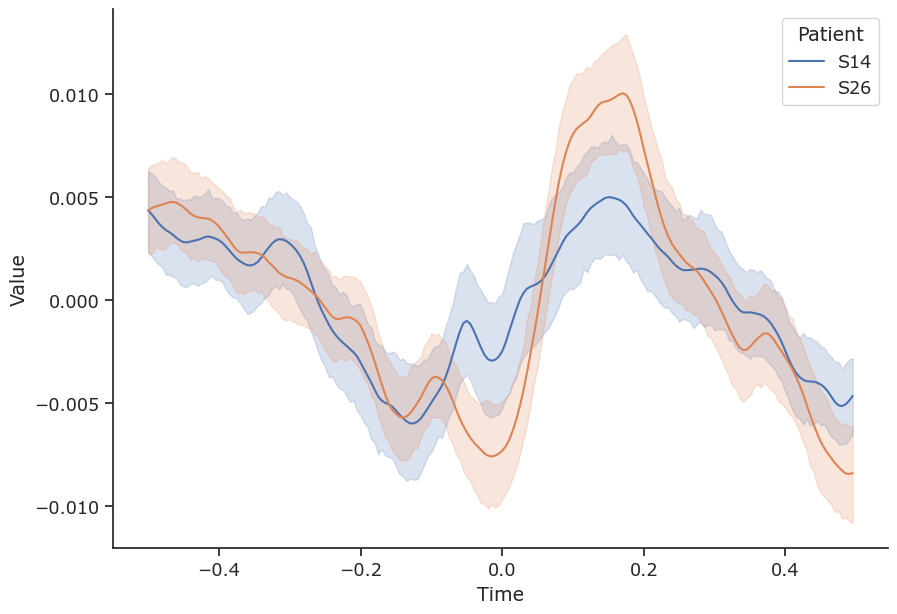

In [295]:
sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
f,ax = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(data=algn_long_df[algn_long_df['CC'] == 5], x='Time', y='Value', hue='Patient', markers=False, dashes=False, ax=ax)
sns.despine()
plt.show()

### CCA Cross-Patient Reconstruction

#### Reconstruction Setup

In [315]:
all_pt_elec_data = [np.transpose(all_pt_dict[pt]['X1_map'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1, all_pt_dict[pt]['X1_map'].shape[-1]), axes=(0,2,1)) for pt in pt_names]
all_pt_good_chans = []
for i, (pt, d) in enumerate(zip(pt_names, all_pt_elec_data)):
    d[d == 0] = np.nan
    all_pt_good_chans.append(np.where(~np.isnan(d)[0,0,:])[0])
    all_pt_elec_data[i] = d[np.where(~np.isnan(d))].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1)

# all_pt_surr_elec_data = [np.transpose(all_pt_surrMap_dict[pt]['TNC'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1, all_pt_dict[pt]['X1_map'].shape[-1]), axes=(0,2,1)) for pt in pt_names]
# all_pt_surr_good_chans = []
# for i, (pt, d) in enumerate(zip(pt_names, all_pt_surr_elec_data)):
#     d[d == 0] = np.nan
#     all_pt_surr_good_chans.append(np.where(~np.isnan(d)[0,0,:])[0])
#     all_pt_surr_elec_data[i] = d[np.where(~np.isnan(d))].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1)

In [316]:
def get_pt_map_from_flat(pt):
    if pt in ['S14', 'S22']:
        chan_map = np.arange(128).reshape(8,16).T+1
    elif pt in ['S23', 'S26']:
        chan_map = np.flipud(np.arange(128).reshape(8,16).T)+1
    elif pt == 'S33':
        chan_map = np.fliplr(np.flipud(np.arange(288).reshape(12,24)))+1
    elif pt == 'S39':
        chan_map = np.arange(288).reshape(24,12).T+1
    else:
        chan_map = np.flipud(np.arange(288).reshape(24,12).T)+1
    return chan_map

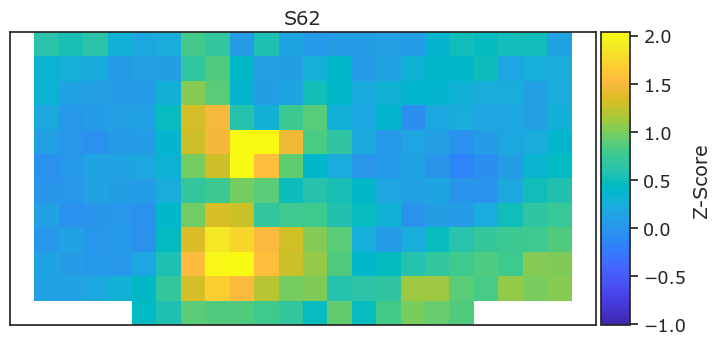

In [317]:
# chan_map = np.arange(128).reshape(8,16).T+1
pt = 'S62'
pt_ind = pt_names.index(pt)
d = np.full((all_pt_traces[pt].shape[0],
                                 all_pt_traces[pt].shape[1],
                                 np.prod(all_pt_chan_data[pt]['map'].shape)),
                                 np.nan)
d[:,:,all_pt_good_chans[pt_ind]] = all_pt_elec_data[pt_ind]

# d_surr = np.full((all_pt_traces[pt].shape[0],
#                                 all_pt_traces[pt].shape[1],
#                                 np.prod(all_pt_chan_data[pt]['map'].shape)),
#                                 np.nan)
# d_surr[:,:,all_pt_surr_good_chans[1]] = all_pt_surr_elec_data[1]

chan_map = get_pt_map_from_flat(pt)
# chan_map = np.arange(128).reshape(8,16).T+1
# chan_map = np.fliplr(np.flipud(np.arange(288).reshape(12,24)))+1 # S33
# chan_map = np.arange(288).reshape(24,12).T+1 # S39
chan_disp(np.mean(d, axis=(0,1)), chan_map, pt, 'Z-Score')
# chan_disp(d_surr[0,0,:], chan_map, pt, 'Z-Score')

In [345]:
from tqdm import tqdm

alignDict_allPts = {}
for recon_pt in tqdm(pt_names, desc='Patients'):
    # recon_pt = 'S14'
    recon_ind = pt_names.index(recon_pt)

    aligners = {}
    aligners_shuffle = {}
    for i, pt in enumerate(pt_names):
        if i == recon_ind:
            continue
        aligners[pt] = AlignCCA()
        aligners_shuffle[pt] = AlignCCA()
                    
    # pcas = [PCA(n_components=0.9) for _ in pt_names]
    # pcas = [PCA(n_components=30) for _ in pt_names]
    # to_align = [pcas[i].fit_transform(all_pt_elec_data[i].reshape(-1, all_pt_elec_data[i].shape[-1])) for i, _ in enumerate(pt_names)]
    # to_align = [to_align[i].reshape(all_pt_elec_data[i].shape[0], all_pt_elec_data[i].shape[1], -1) for i, _ in enumerate(pt_names)]
    pcas = {}
    to_align = {}
    for pt in pt_names:
        # pcas[pt] = PCA(n_components=0.9)
        pcas[pt] = PCA(n_components=30)
        to_align[pt] = pcas[pt].fit_transform(all_pt_elec_data[pt_names.index(pt)].reshape(-1, all_pt_elec_data[pt_names.index(pt)].shape[-1]))
        to_align[pt] = to_align[pt].reshape(all_pt_elec_data[pt_names.index(pt)].shape[0], all_pt_elec_data[pt_names.index(pt)].shape[1], -1)

    aligned_data = {}
    aligned_data_shuffle = {}
    aligned_data_null = {}
    aligned_data[recon_pt] = to_align[recon_pt]
    aligned_data_shuffle[recon_pt] = to_align[recon_pt]
    aligned_data_null[recon_pt] = to_align[recon_pt]
    for i, pt in enumerate(pt_names):
        if i == recon_ind:
            continue
        # print(pt)
        to_align_seqs = [all_pt_phon_seqs[recon_pt], all_pt_phon_seqs[pt]]
        aligners[pt].fit(to_align[recon_pt], to_align[pt], to_align_seqs[0], to_align_seqs[1])
        aligned_data[pt] = aligners[pt].transform(to_align[pt])
        
        to_align_seqs_shuffle = [all_pt_phon_seqs[recon_pt], np.random.permutation(all_pt_phon_seqs[pt])]
        aligners_shuffle[pt].fit(to_align[recon_pt], to_align[pt], to_align_seqs_shuffle[0], to_align_seqs_shuffle[1])
        aligned_data_shuffle[pt] = aligners_shuffle[pt].transform(to_align[pt])

        # aligned_data_null[pt] = to_align[i] @ np.linalg.pinv(aligners[pt].M_a)
        aligned_data_null[pt] = to_align[pt]
    alignDict_allPts[recon_pt] = {
        'pcas': pcas,
        'aligners': aligners,
        'aligners_shuffle': aligners_shuffle,
        'dr_data': to_align,
        'aligned_data': aligned_data,
        'aligned_data_shuffle': aligned_data_shuffle,
        'aligned_data_null': aligned_data_null}


### for surrogate data with TME ###
# surr_aligners = {}
# for i, pt in enumerate(pt_names):
#     if i == recon_ind:
#         continue
#     surr_aligners[pt] = AlignCCA()

# surr_pcas = [PCA(n_components=0.9) for _ in pt_names]
# to_align_surr = [surr_pcas[i].fit_transform(all_pt_surr_elec_data[i].reshape(-1, all_pt_surr_elec_data[i].shape[-1])) for i, _ in enumerate(pt_names)]
# to_align_surr = [to_align_surr[i].reshape(all_pt_surr_elec_data[i].shape[0], all_pt_surr_elec_data[i].shape[1], -1) for i, _ in enumerate(pt_names)]

# aligned_surr_data = {}
# aligned_surr_data[pt_names[recon_ind]] = to_align_surr[recon_ind]
# for i, pt in enumerate(pt_names):
#     if i == recon_ind:
#         continue
#     # print(pt)
#     to_align_seqs = [all_pt_phon_seqs[pt_names[recon_ind]], all_pt_phon_seqs[pt]]
#     # aliging surrogate data to real data to see how well it reconstructs
#     surr_aligners[pt].fit(to_align[recon_ind], to_align_surr[i], to_align_seqs[0], to_align_seqs[1])
#     aligned_surr_data[pt] = surr_aligners[pt].transform(to_align_surr[i])

Patients: 100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Map data from other patients aligned to S14 up to S14's channel space

In [347]:
reconDict_allPts = {}
for recon_pt in pt_names:

    pcas = alignDict_allPts[recon_pt]['pcas']
    aligned_data = alignDict_allPts[recon_pt]['aligned_data']
    aligned_data_shuffle = alignDict_allPts[recon_pt]['aligned_data_shuffle']
    aligned_data_null = alignDict_allPts[recon_pt]['aligned_data_null']

    recons = {}
    recons_shuffle = {}
    recons_null = {}
    for i, pt in enumerate(pt_names):
        recons[pt] = pcas[recon_pt].inverse_transform(aligned_data[pt])
        recons_shuffle[pt] = pcas[recon_pt].inverse_transform(aligned_data_shuffle[pt])
        recons_null[pt] = pcas[recon_pt].inverse_transform(aligned_data_null[pt])
        
    reconDict_allPts[recon_pt] = {
        'recons': recons,
        'recons_shuffle': recons_shuffle,
        'recons_null': recons_null
    }
    # recons = [pcas[recon_ind].inverse_transform(aligned_data[i]) for i in range(len(aligned_data))]
    print(f'Recon Pt: {recon_pt}: {[(k, v.shape) for k,v in recons.items()]}')
    # print([(k, v.shape) for k,v in recons_shuffle.items()])
    # print([(k, v.shape) for k,v in recons_null.items()])

# surr_recons = {}
# for i, pt in enumerate(pt_names):
#     if i == recon_ind: # for self reconstruction
#         surr_recons[pt] = surr_pcas[recon_ind].inverse_transform(aligned_surr_data[pt])
#     else:
#         surr_recons[pt] = pcas[recon_ind].inverse_transform(aligned_surr_data[pt])
# print([(k, v.shape) for k,v in surr_recons.items()])

Recon Pt: S14: [('S14', (144, 200, 128)), ('S26', (148, 200, 128)), ('S23', (151, 200, 128)), ('S33', (46, 200, 128)), ('S22', (151, 200, 128)), ('S39', (137, 200, 128)), ('S58', (141, 200, 128)), ('S62', (178, 200, 128))]
Recon Pt: S26: [('S14', (144, 200, 128)), ('S26', (148, 200, 128)), ('S23', (151, 200, 128)), ('S33', (46, 200, 128)), ('S22', (151, 200, 128)), ('S39', (137, 200, 128)), ('S58', (141, 200, 128)), ('S62', (178, 200, 128))]
Recon Pt: S23: [('S14', (144, 200, 128)), ('S26', (148, 200, 128)), ('S23', (151, 200, 128)), ('S33', (46, 200, 128)), ('S22', (151, 200, 128)), ('S39', (137, 200, 128)), ('S58', (141, 200, 128)), ('S62', (178, 200, 128))]
Recon Pt: S33: [('S14', (144, 200, 256)), ('S26', (148, 200, 256)), ('S23', (151, 200, 256)), ('S33', (46, 200, 256)), ('S22', (151, 200, 256)), ('S39', (137, 200, 256)), ('S58', (141, 200, 256)), ('S62', (178, 200, 256))]
Recon Pt: S22: [('S14', (144, 200, 128)), ('S26', (148, 200, 128)), ('S23', (151, 200, 128)), ('S33', (46, 2

#### Reconstructed Timeseries Maps

In [72]:
recons_map = {}
recons_map_shuffle = {}
recons_map_null = {}
for i, pt in enumerate(pt_names):
    d = np.full((all_pt_traces[pt].shape[0],
                                 all_pt_traces[recon_pt].shape[1],
                                    np.prod(all_pt_chan_data[recon_pt]['map'].shape)),
                                    np.nan)
    d_shuffle = d.copy()
    d_null = d.copy()
    d[:,:,all_pt_good_chans[recon_ind]] = recons[pt] - pcas[recon_ind].mean_
    # d[:,:,all_pt_good_chans[recon_ind]] = recons[pt]
    d_shuffle[:,:,all_pt_good_chans[recon_ind]] = recons_shuffle[pt] - pcas[recon_ind].mean_
    d_null[:,:,all_pt_good_chans[recon_ind]] = recons_null[pt] - pcas[recon_ind].mean_
    recons_map[pt] = d
    recons_map_shuffle[pt] = d_shuffle
    recons_map_null[pt] = d_null


# surr_recons_map = {}
# for i, pt in enumerate(pt_names):
#     d = np.full((all_pt_traces[pt].shape[0],
#                                  all_pt_traces[recon_pt].shape[1],
#                                     np.prod(all_pt_chan_data[recon_pt]['map'].shape)),
#                                     np.nan)
#     if i == recon_ind:
#         d[:,:,all_pt_surr_good_chans[recon_ind]] = surr_recons[pt] - surr_pcas[recon_ind].mean_
#     else:
#         d[:,:,all_pt_good_chans[recon_ind]] = surr_recons[pt] - pcas[recon_ind].mean_
#     surr_recons_map[pt] = d

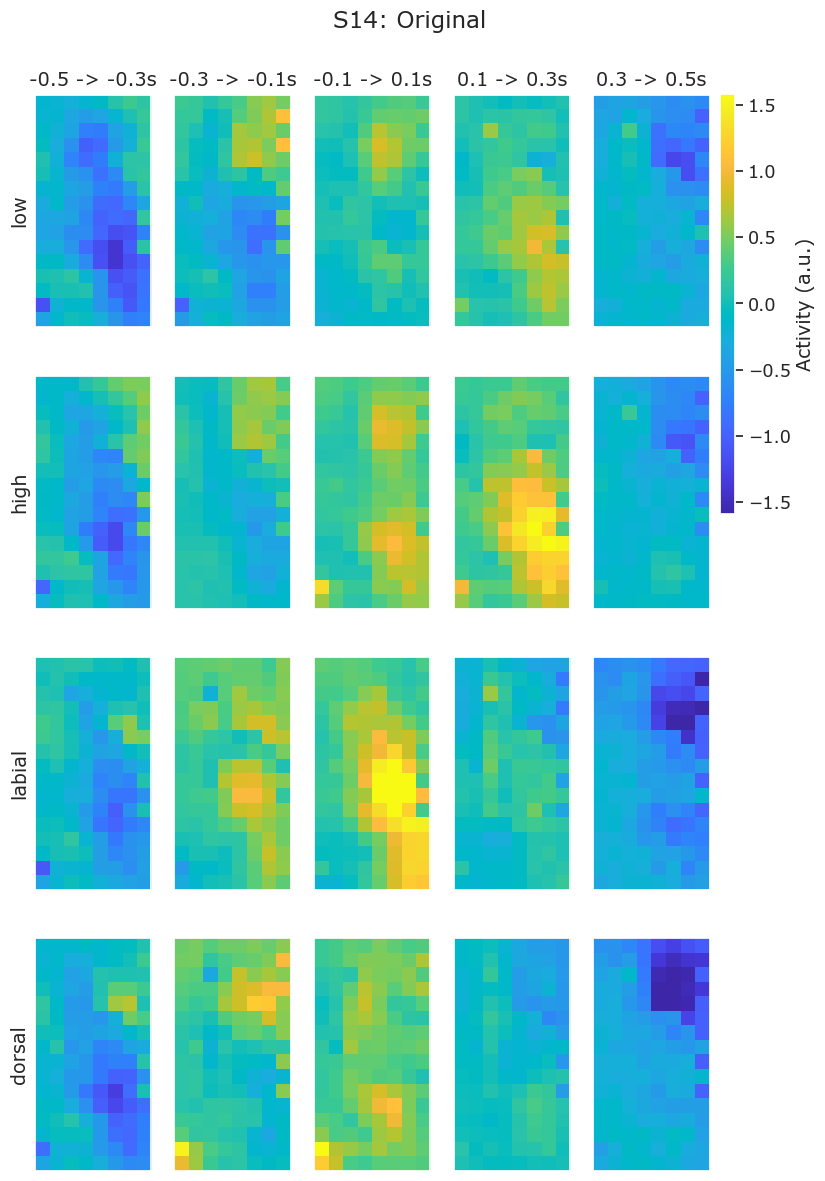

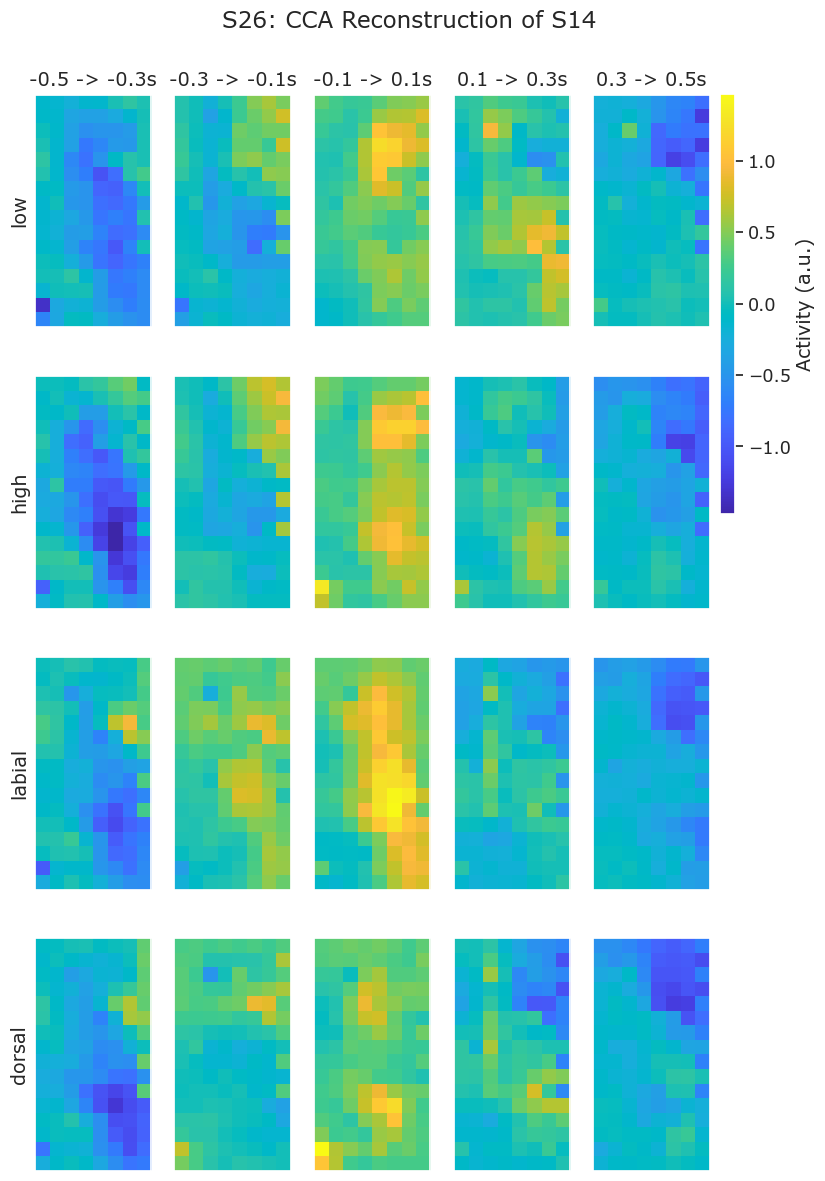

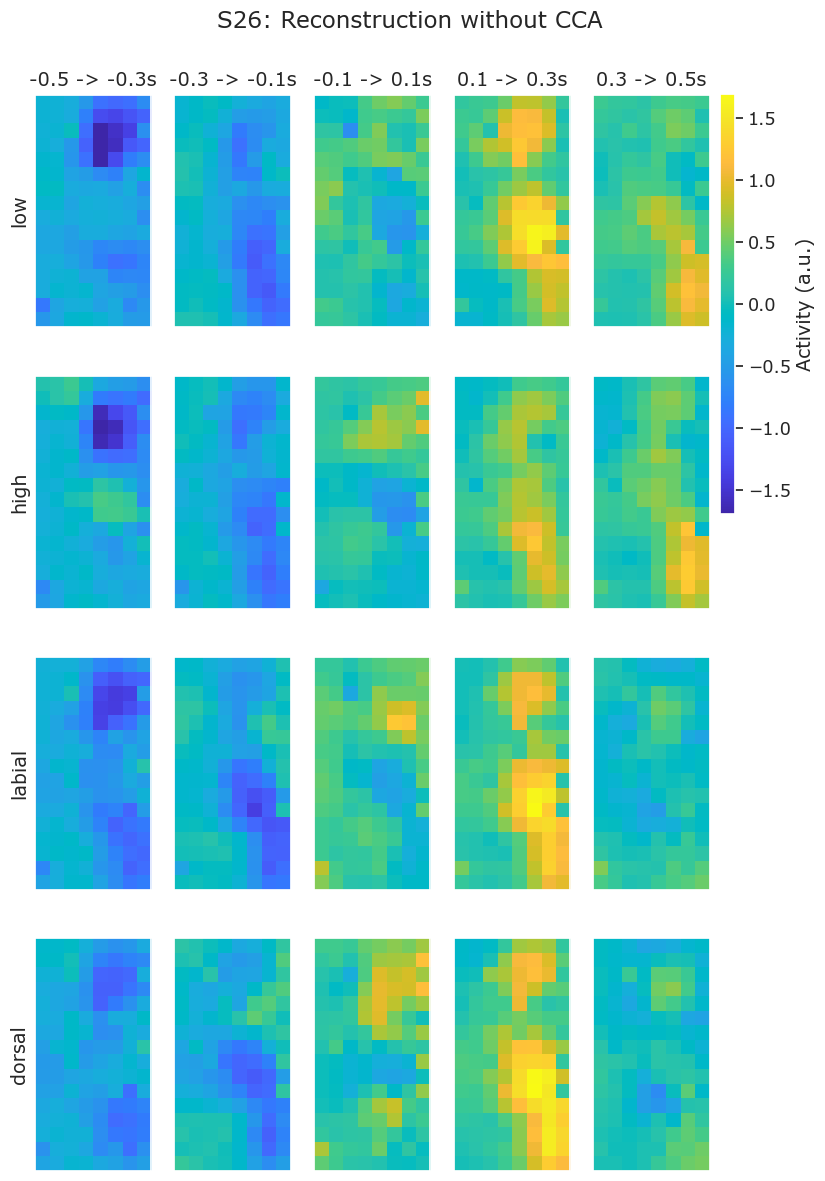

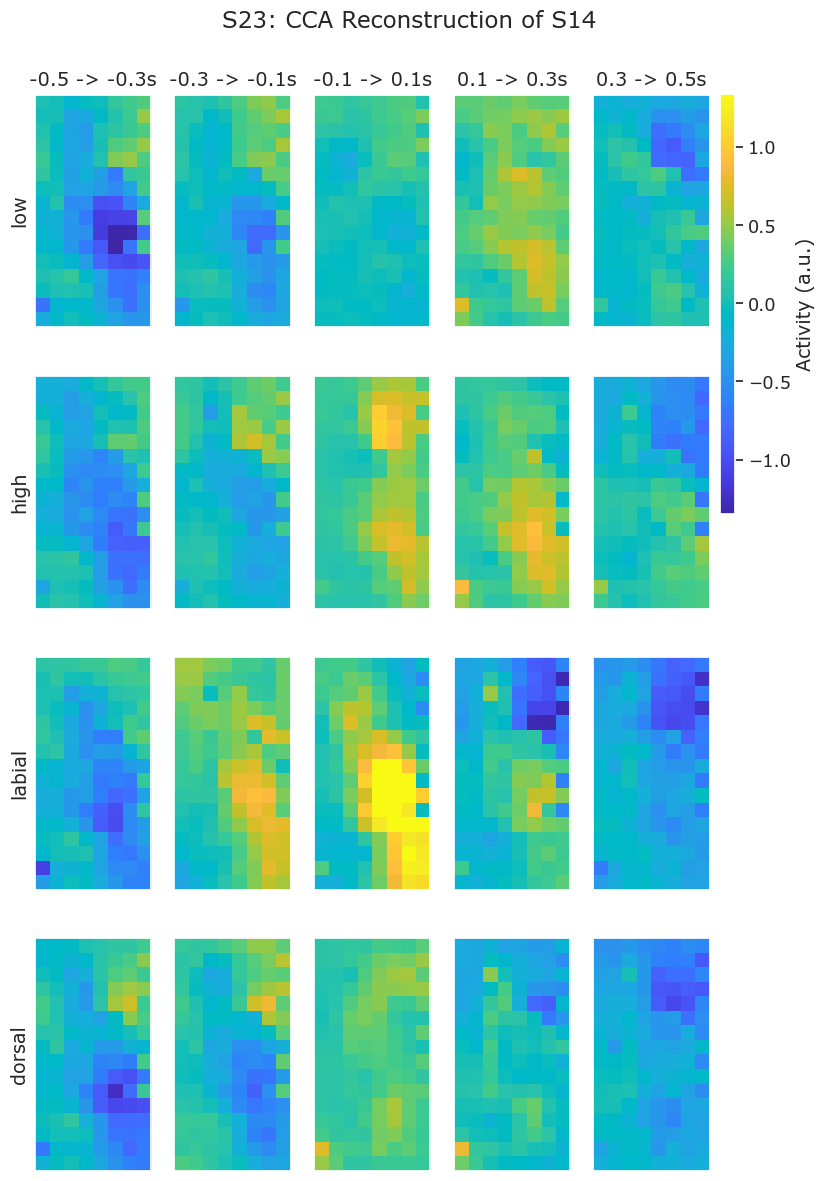

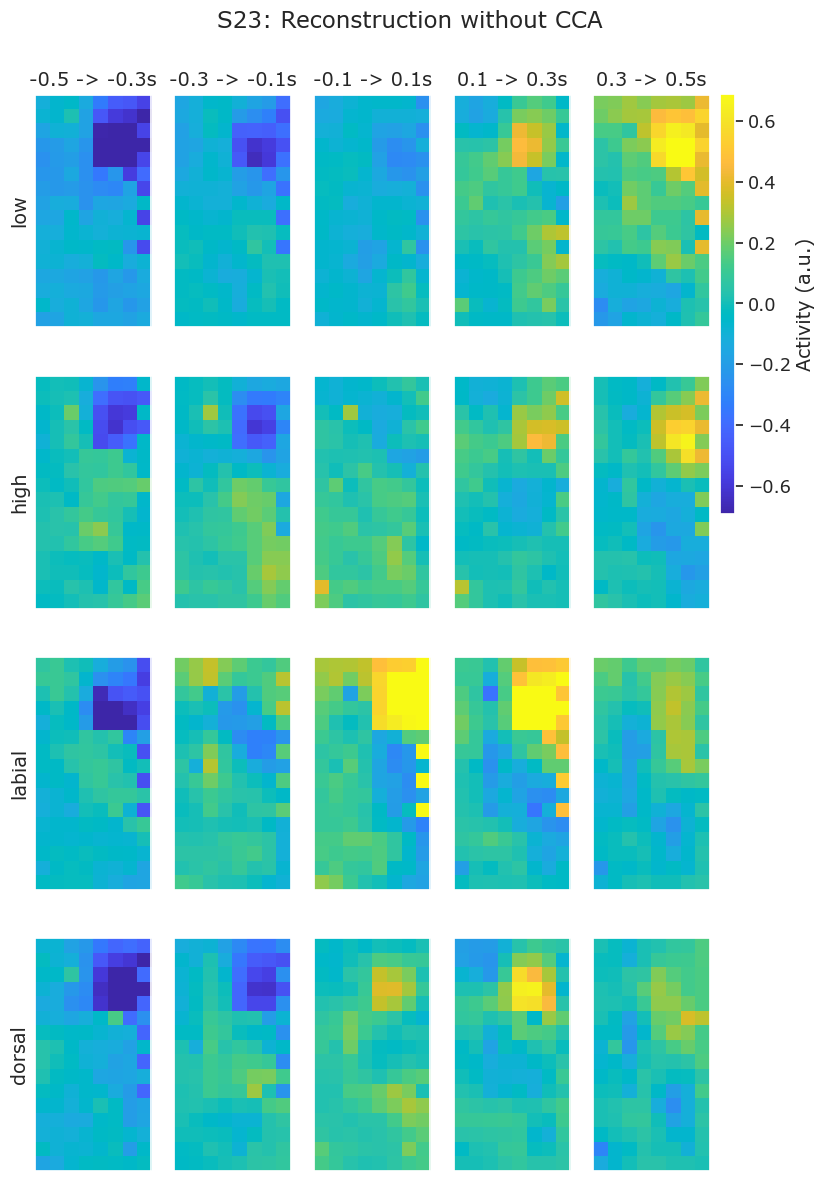

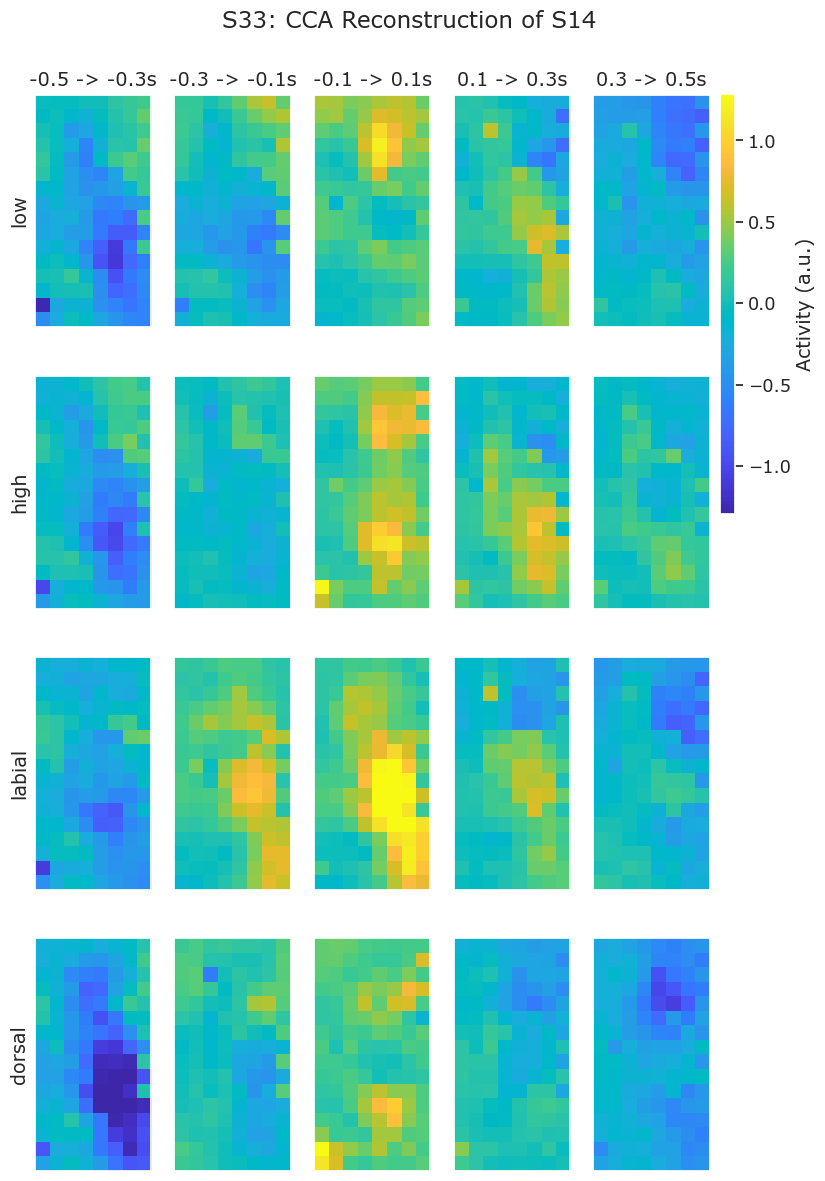

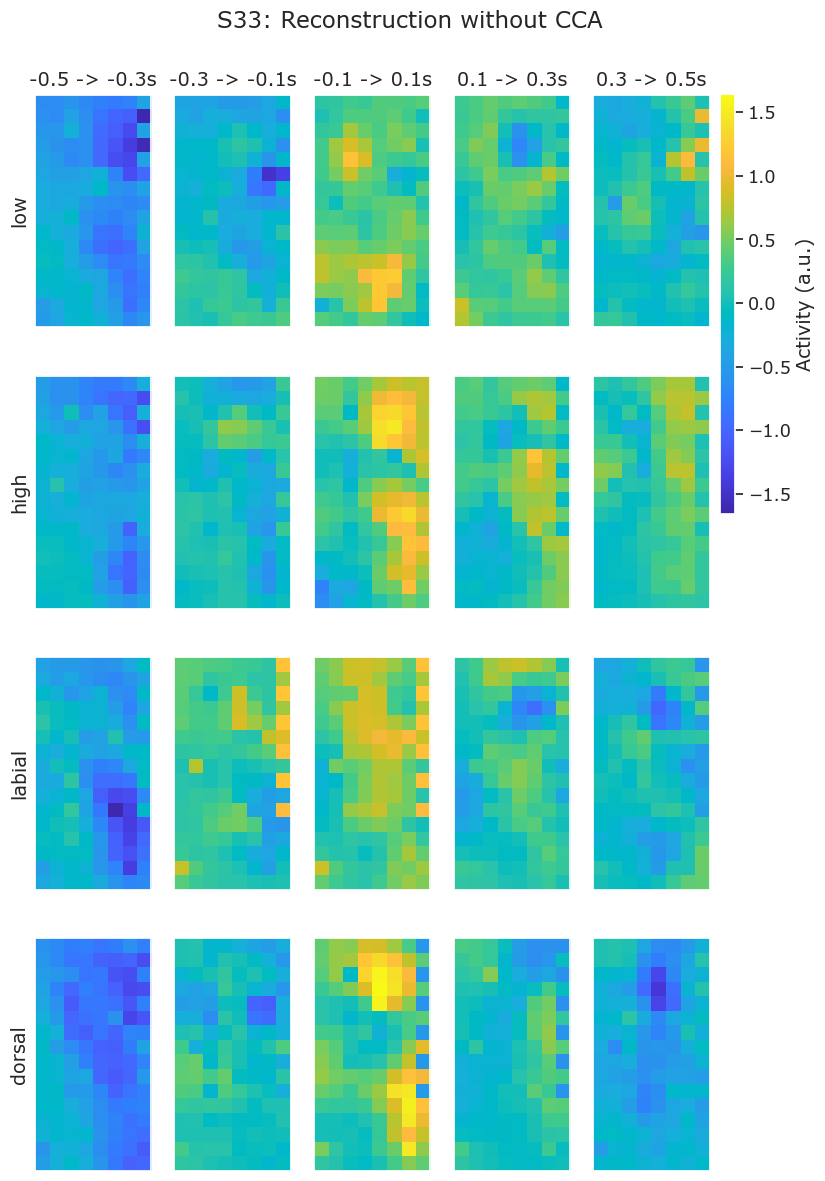

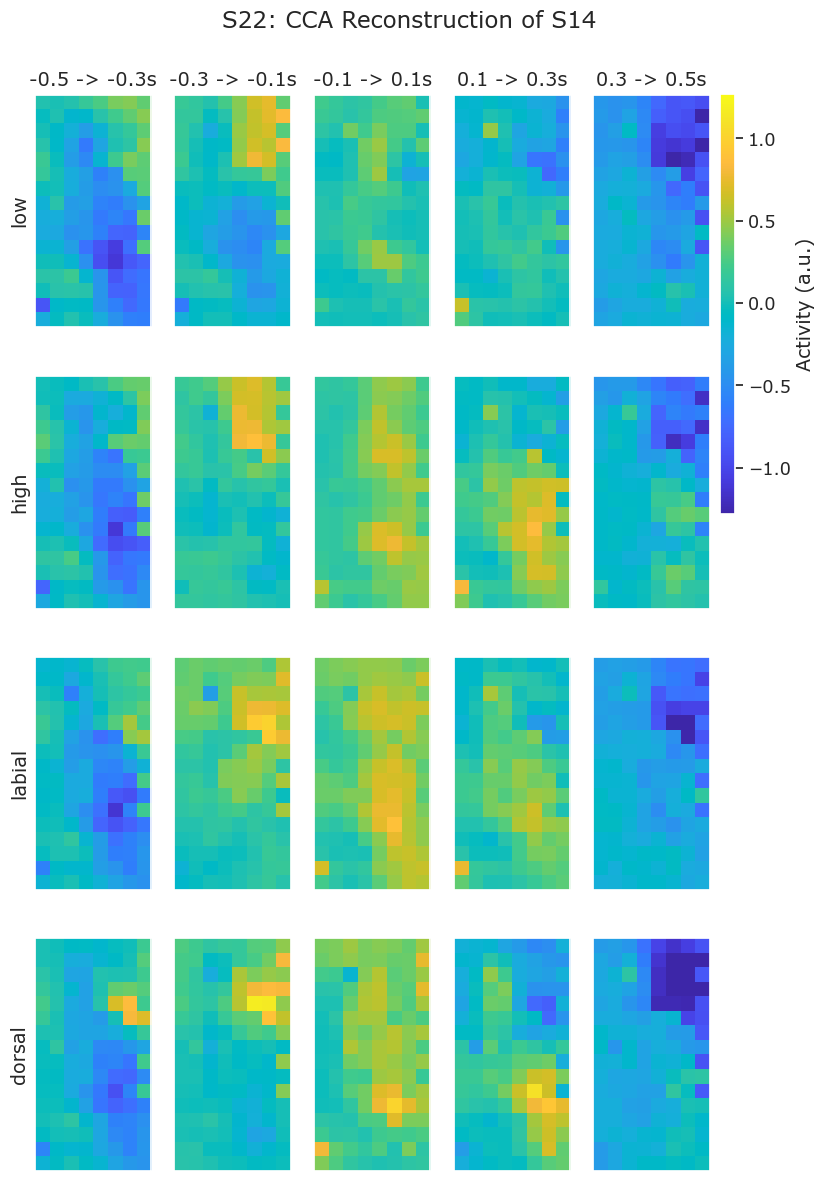

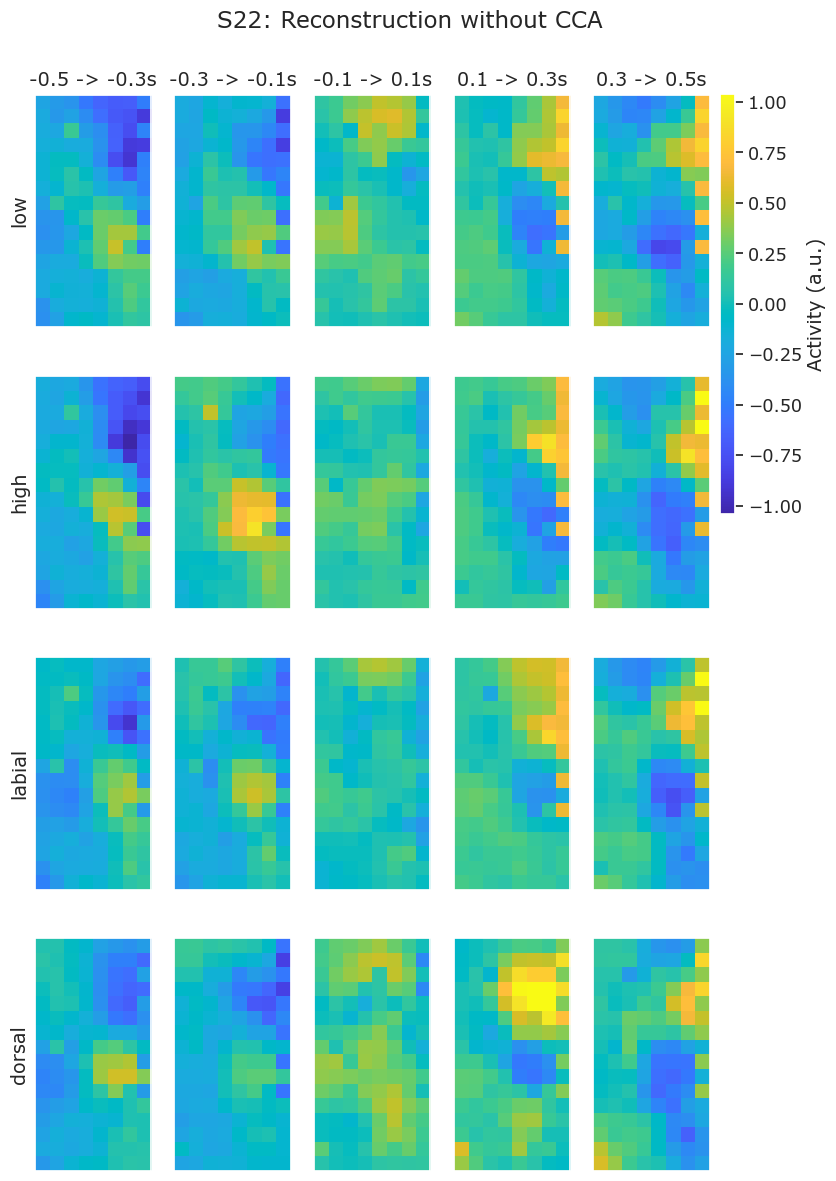

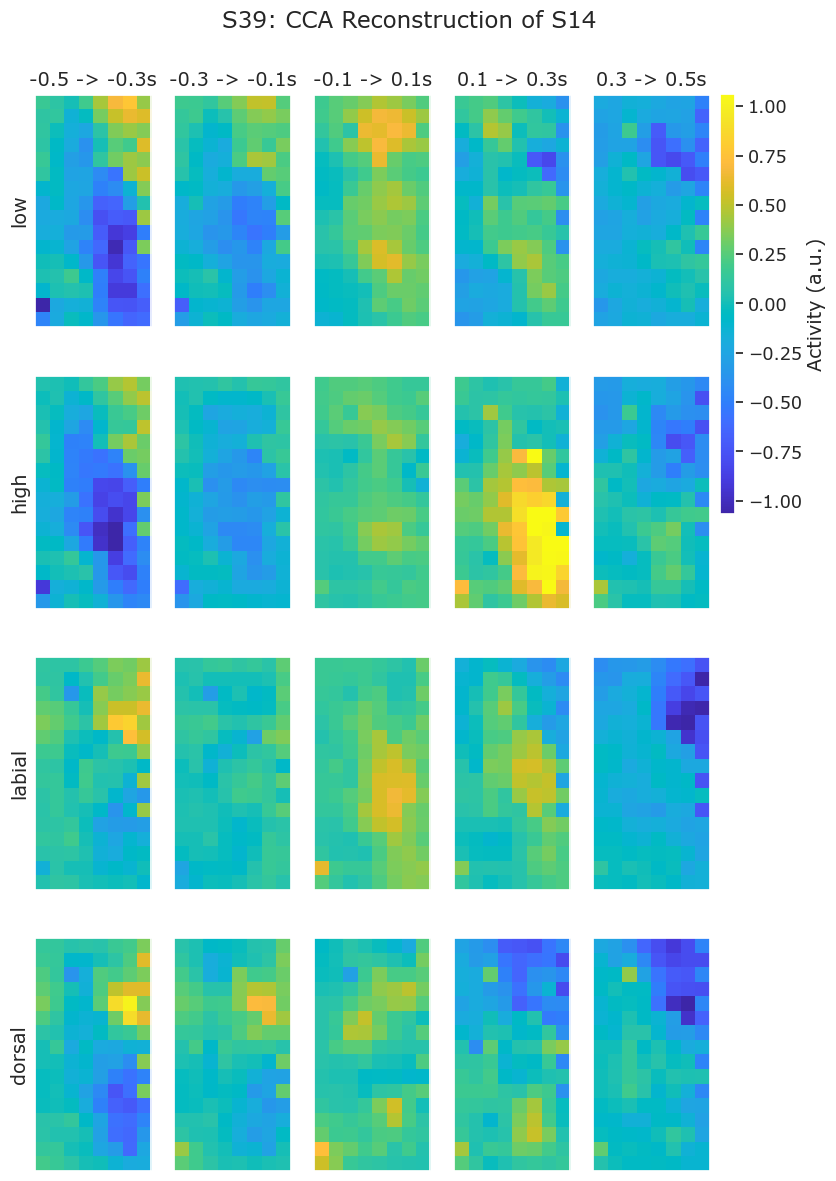

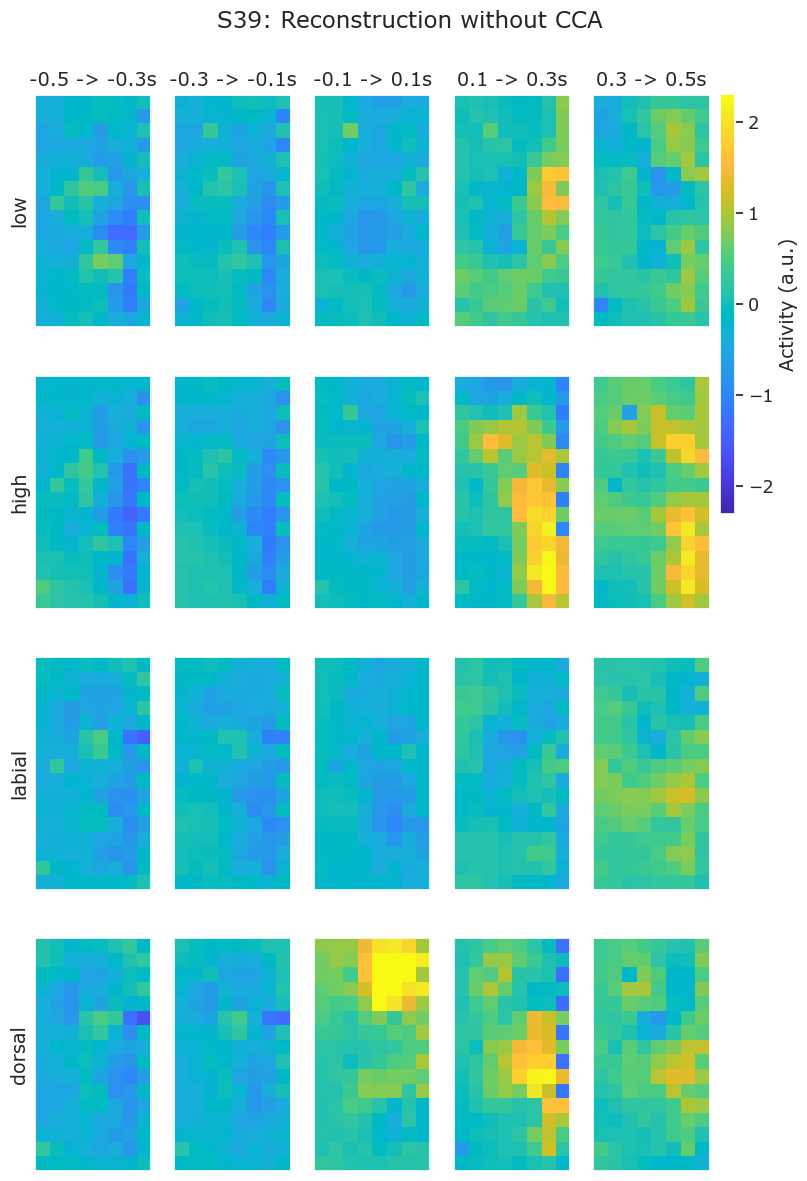

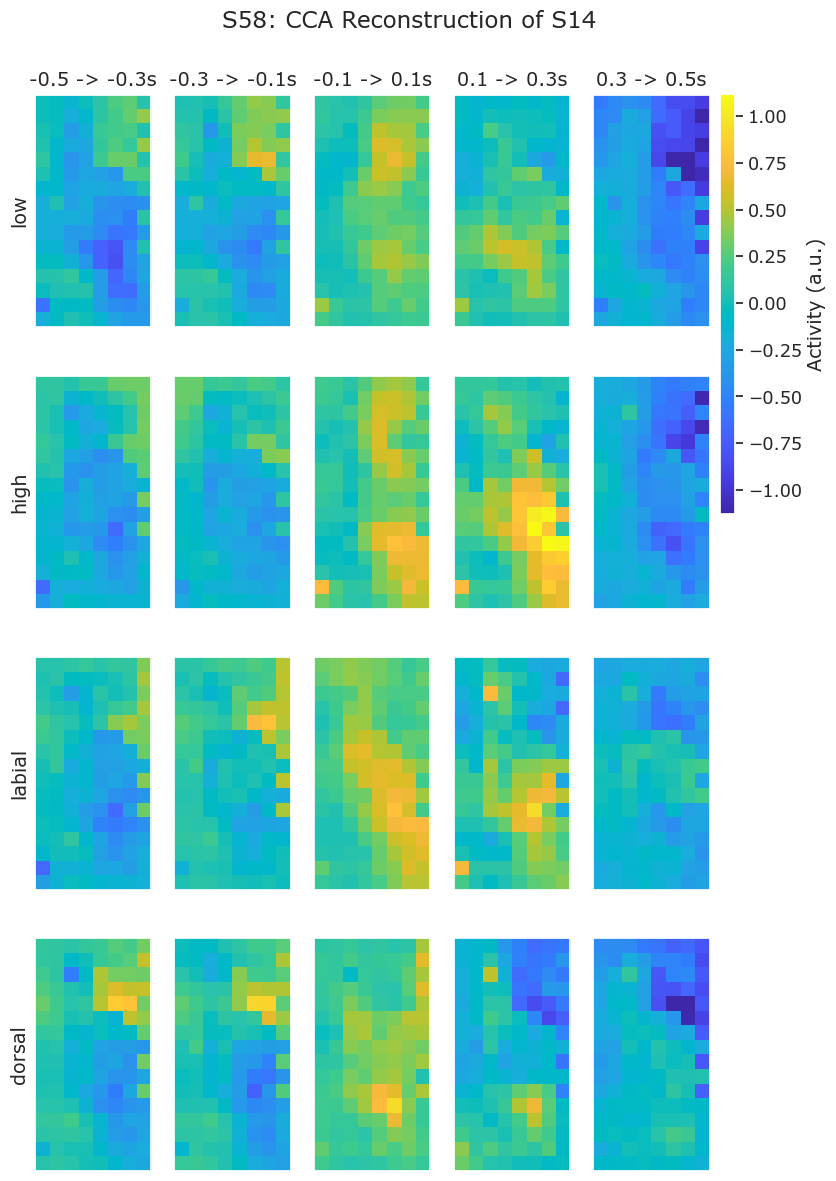

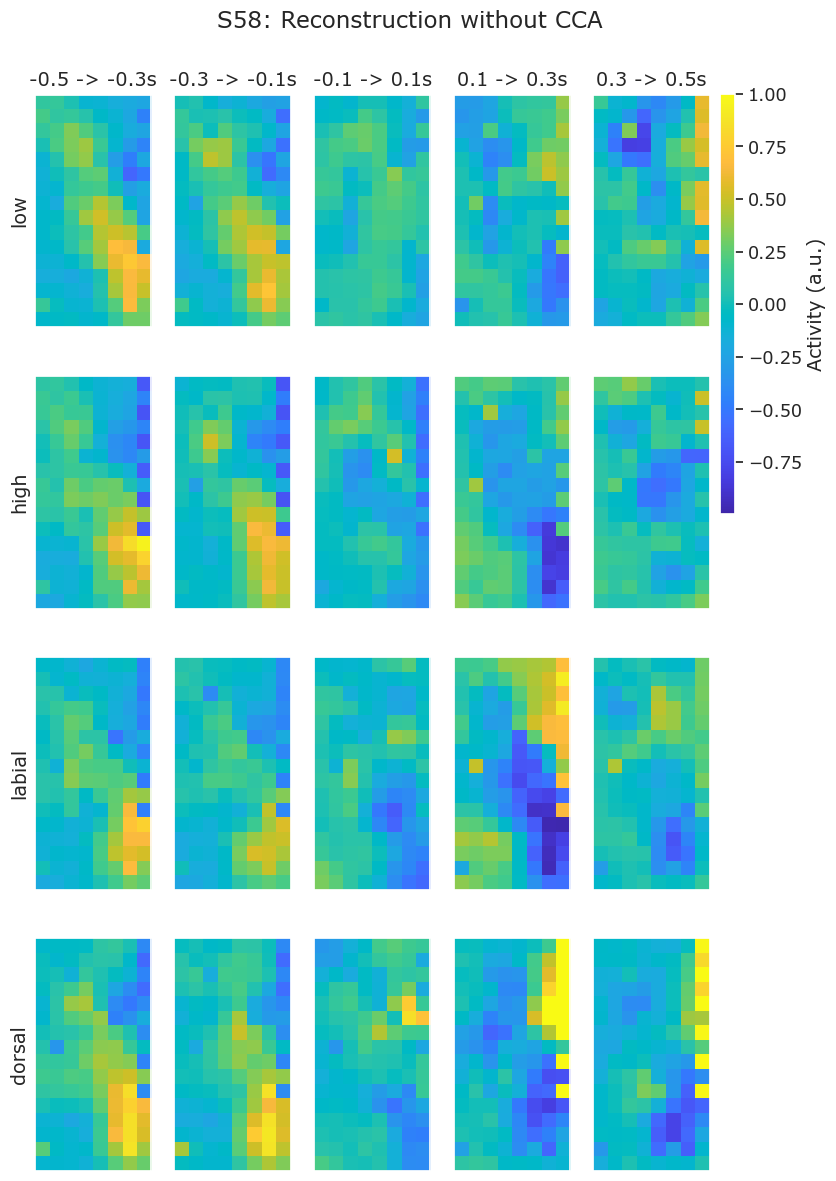

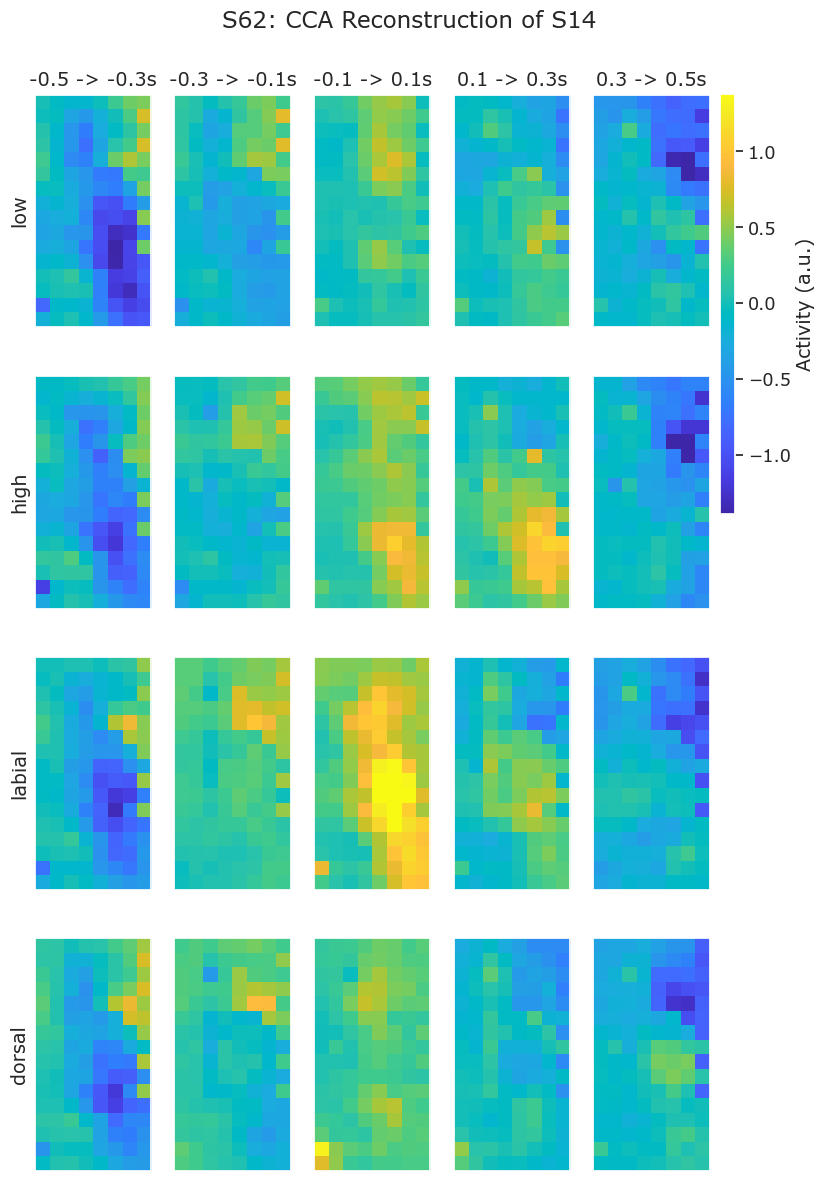

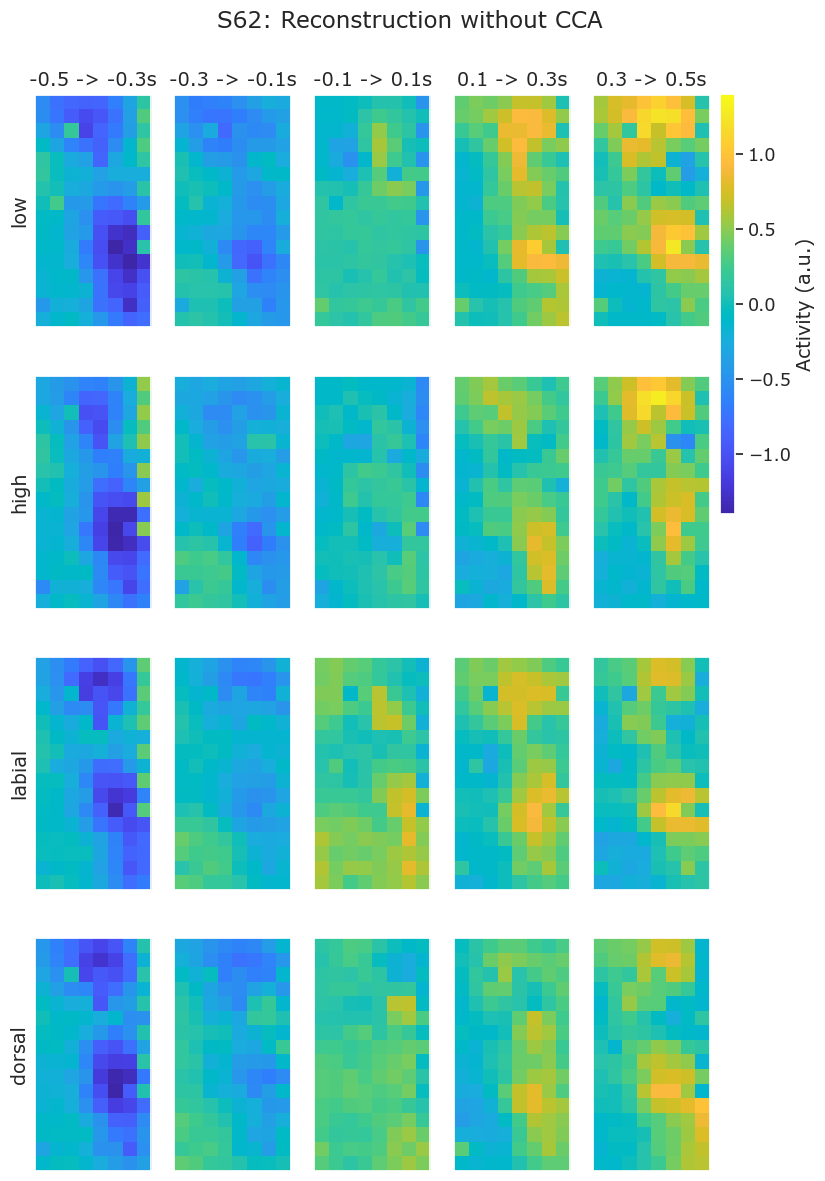

In [74]:
sns.set_theme(context='notebook', font='Verdana', font_scale=1.15)

avg_recons = {}
pt_names_recon_order = [recon_pt] + [pt for pt in pt_names if pt != recon_pt]
for pt in pt_names_recon_order:
# for pt in ['S62', 'S33', 'S58']:
    # cnd_labels = all_pt_phon_labels[pt]; lab_names = phon_labels
    cnd_labels = all_pt_artic_labels[pt]; lab_names = artic_labels
    # cnd_labels = all_pt_cv_labels[pt]; lab_names = ['CVC', 'VCV']
    # cnd_labels = np.ones(all_pt_cv_labels[pt].shape); lab_names = ['All Trials']
    data_avg = cnd_avg(recons_map[pt], cnd_labels)
    shuffle_avg = cnd_avg(recons_map_shuffle[pt], cnd_labels)
    null_avg = cnd_avg(recons_map_null[pt], cnd_labels)
    # reg_avg = cnd_avg(pt_cca_timeseries[pt]['Reg'], cnd_labels)


    t_ranges = [[-0.5, -0.3], [-0.3, -0.1], [-0.1, 0.1], [0.1, 0.3], [0.3, 0.5]]
    # t_ranges = [[-0.5, 0.5], [-0.5, 0.5]]

    if all_pt_chan_data[recon_pt]['map'].size == 128:
        # chan_map = all_pt_chan_data[pt]['map'].T
        chan_map = np.arange(128).reshape(8,16).T+1
        figsize=(2,3.5)
        cbar_pos = [0.81, 0.58, 0.015, 0.3]
        sup_pos = 0.94
    else:
        # chan_map = np.flipud(all_pt_chan_data[pt]['map'])-1
        if recon_pt == 'S33':
            chan_map = np.fliplr(np.flipud(np.arange(288).reshape(12,24)))+1
        elif recon_pt == 'S39':
            chan_map = np.arange(288).reshape(24,12).T+1
        else:
            chan_map = np.flipud(np.arange(288).reshape(24,12).T)+1
        figsize=(4,2)
        cbar_pos = [0.81, 0.56, 0.01, 0.3]
        sup_pos = 0.98

    avg_recons[pt] = data_avg

    # if all_pt_chan_data[pt]['map'].size == 128:
    #     # chan_map = all_pt_chan_data[pt]['map'].T
    #     chan_map = np.arange(128).reshape(8,16).T+1
    #     figsize=(2,3.5)
    #     cbar_pos = [0.81, 0.58, 0.015, 0.3]
    #     sup_pos = 0.94
    # else:
    #     # chan_map = np.flipud(all_pt_chan_data[pt]['map'])-1
    #     if pt == 'S33':
    #         chan_map = np.fliplr(np.flipud(np.arange(288).reshape(12,24)))+1
    #     elif pt == 'S39':
    #         chan_map = np.arange(288).reshape(24,12).T+1
    #     else:
    #         chan_map = np.flipud(np.arange(288).reshape(24,12).T)+1
    #     figsize=(4,2)
    #     cbar_pos = [0.81, 0.56, 0.01, 0.3]
    #     sup_pos = 0.98
    if pt == recon_pt:
        recon_title = f'{pt}: Original'
    else:
        recon_title = f'{pt}: CCA Reconstruction of {recon_pt}'
    chan_disp_seq(data_avg, chan_map, t, t_ranges, lab_names, recon_title, 'Activity (a.u.)', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos)
    # chan_disp_seq(shuffle_avg, chan_map, t, t_ranges, lab_names, f'{pt}: Reconstruction with Shuffled CCA Labels', 'HG Z-score', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos)
    if pt != recon_pt:
        chan_disp_seq(null_avg, chan_map, t, t_ranges, lab_names, f'{pt}: Reconstruction without CCA', 'Activity (a.u.)', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos)

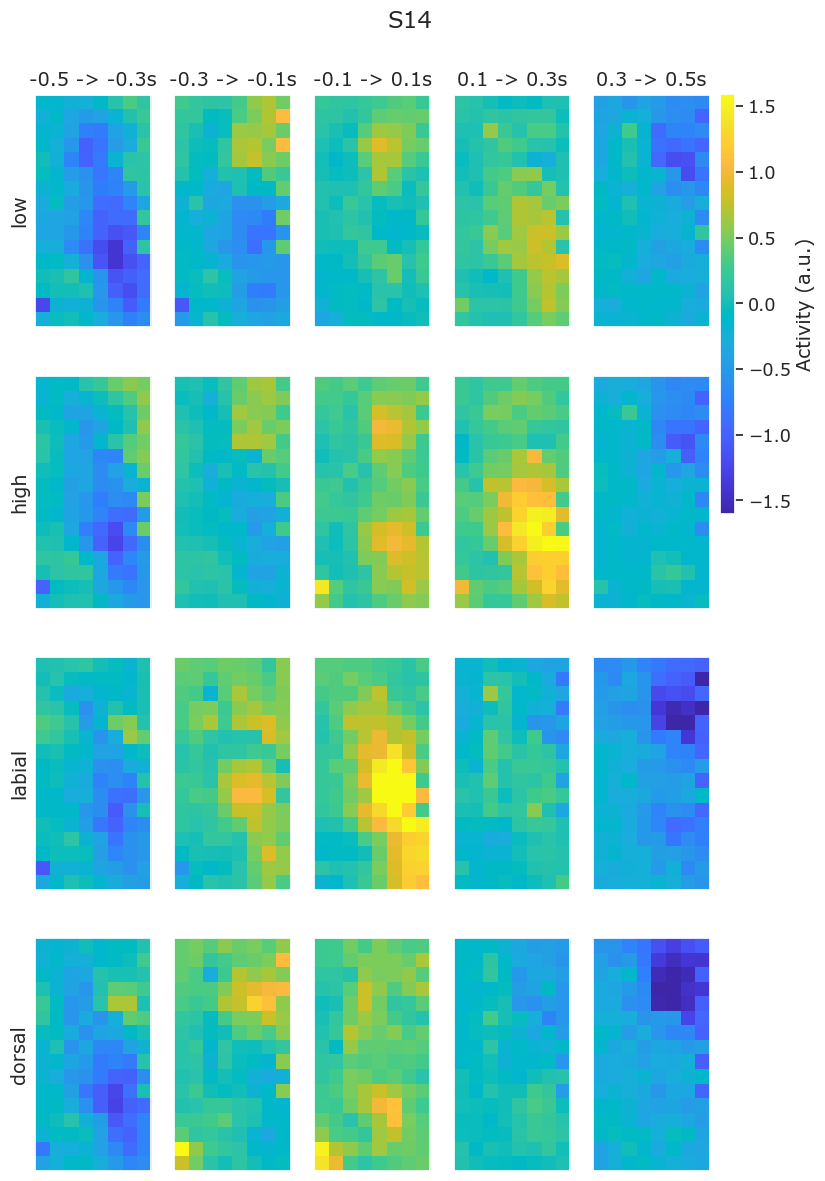

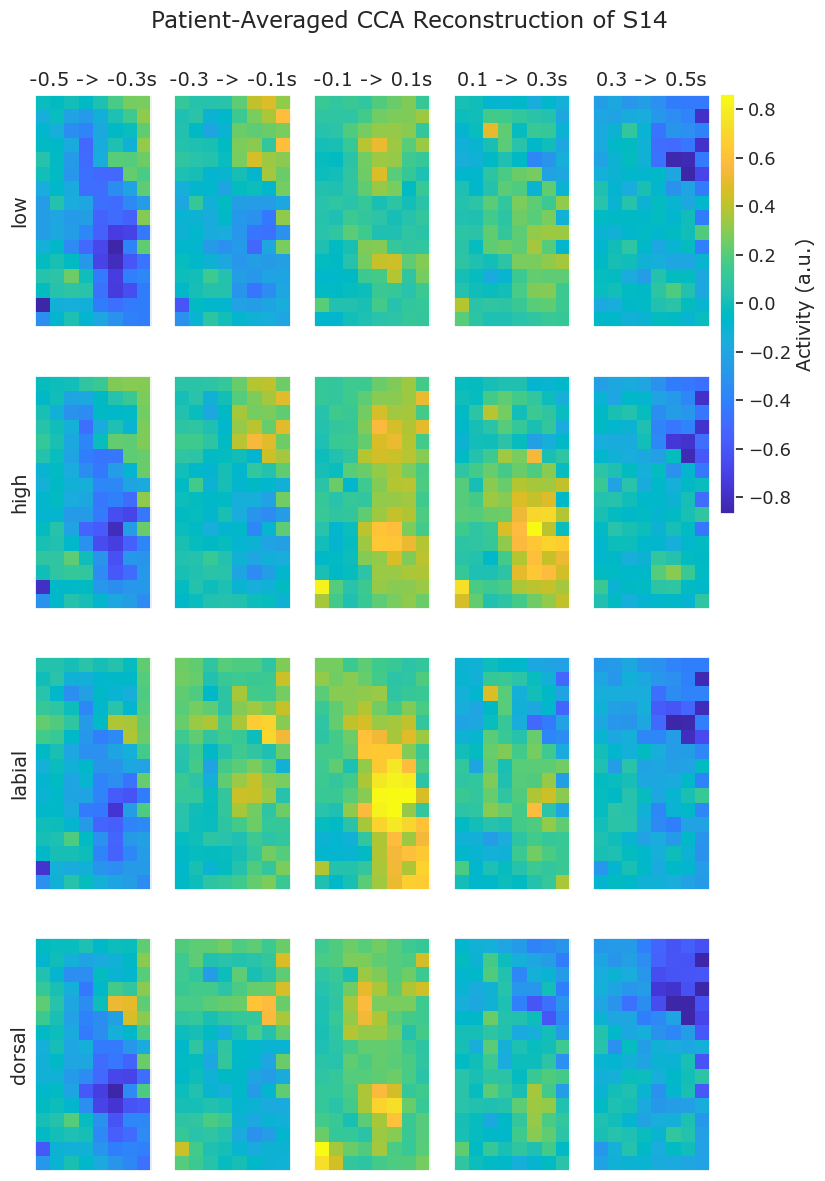

In [299]:
avg_recons_pts = np.mean(np.array([avg_recons[pt] for pt in pt_names_recon_order[1:]]),axis=0)

chan_disp_seq(avg_recons[recon_pt], chan_map, t, t_ranges, lab_names, f'{recon_pt}', 'Activity (a.u.)', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos)
chan_disp_seq(avg_recons_pts, chan_map, t, t_ranges, lab_names, f'Patient-Averaged CCA Reconstruction of {recon_pt}', 'Activity (a.u.)', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos)

In [300]:
# from sklearn import root_mean_squared_error as rmse
t_range = [-0.2, 0.2]

mse_vals_time = {}
mse_vals = {}
for pt in pt_names:
    if pt == recon_pt:
        continue
    mse_vals_time[pt] = np.nanmean((avg_recons[recon_pt] - avg_recons[pt])**2, axis=(0,2))
    mse_vals[pt] = np.mean(mse_vals_time[pt][(t >= t_range[0]) & (t <= t_range[1])])


In [301]:
hg_zscores = {}
for pt in pt_names:
    if pt == recon_pt:
        continue
    hg_zscores[pt] = np.mean(all_pt_dict[pt]['X1'][:,(t >= t_range[0]) & (t <= t_range[1]),:])

In [302]:
from scipy.stats import linregress

res = linregress(list(hg_zscores.values()), list(mse_vals.values()))
res

LinregressResult(slope=-0.11986516158794393, intercept=0.23357447259258945, rvalue=-0.4016473532042933, pvalue=0.37178340813363714, stderr=0.12222528328264572, intercept_stderr=0.08630434246466734)

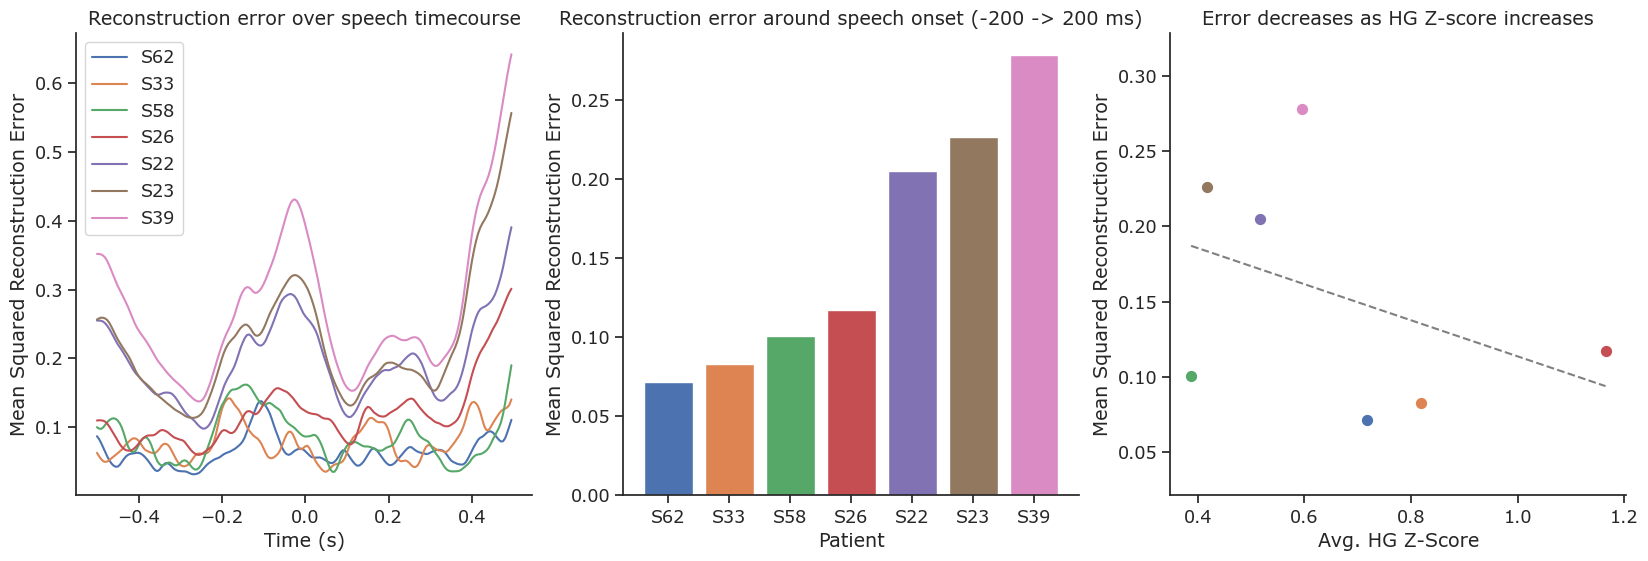

In [303]:
sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')

sorted_mses = {k: v for k, v in sorted(mse_vals.items(), key=lambda item: item[1])}
pt_names_bar = list(sorted_mses.keys())


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
for pt in pt_names_bar:
    ax1.plot(t, mse_vals_time[pt], label=pt)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Mean Squared Reconstruction Error')
ax1.set_title('Reconstruction error over speech timecourse')
ax1.legend()

sorted_mses = {k: v for k, v in sorted(mse_vals.items(), key=lambda item: item[1])}
pt_names_bar = list(sorted_mses.keys())
for pt in pt_names_bar:
    ax2.bar(pt, mse_vals[pt])
# ax2.bar(pt_names_bar, [mse_vals[pt] for pt in pt_names_bar])
ax2.set_xlabel('Patient')
ax2.set_ylabel('Mean Squared Reconstruction Error')
ax2.set_title(f'Reconstruction error around speech onset ({int(t_range[0]*1000)} -> {int(t_range[1]*1000)} ms)')


for pt in pt_names_bar:
    ax3.scatter(hg_zscores[pt], mse_vals[pt], label=pt, s=50)
ax3.plot(np.linspace(min(hg_zscores.values()), max(hg_zscores.values()), 100), res.intercept + res.slope*np.linspace(min(hg_zscores.values()), max(hg_zscores.values()), 100), color='grey', linestyle='dashed')
ax3.set_ylim([min(mse_vals.values())-0.05, max(mse_vals.values())+0.05])
# ax3.scatter([hg_zscores[pt] for pt in pt_names], [mse_vals[pt] for pt in pt_names], s=50)
ax3.set_xlabel('Avg. HG Z-Score')
ax3.set_ylabel('Mean Squared Reconstruction Error')
ax3.set_title('Error decreases as HG Z-score increases')

sns.despine()
plt.show()

#### Articulator Map Reconstruction

In [253]:
# artic_maps_S33 = sio.loadmat('../data/articulator_maps/S33/S33_articulator_maps.mat')
# low_map_S33 = np.fliplr(artic_maps_S33['lowMap'])
# high_map_S33 = np.fliplr(artic_maps_S33['highMap'])
# labial_map_S33 = np.fliplr(artic_maps_S33['labialMap'])
# dorsal_map_S33 = np.fliplr(artic_maps_S33['dorsalMap'])
# artic_maps_S33 = [low_map_S33, high_map_S33, labial_map_S33, dorsal_map_S33]

# artic_maps_S14 = sio.loadmat('../data/articulator_maps/S14/S14_articulator_maps.mat')
# low_map_S14 = artic_maps_S14['lowMap'].T
# high_map_S14 = artic_maps_S14['highMap'].T
# labial_map_S14 = artic_maps_S14['labialMap'].T
# dorsal_map_S14 = artic_maps_S14['dorsalMap'].T
# artic_maps_S14 = [low_map_S14, high_map_S14, labial_map_S14, dorsal_map_S14]

import h5py

pt_artic_maps = {}
for pt in pt_names:
    h5_fname = f'../data/articulator_maps/new/{pt}/{pt}_artic_elec_weights.h5'
    with h5py.File(h5_fname, 'r') as f:
        weights = f['weights'][()]
        weight_map = f['weight_map'][()]
    pt_artic_maps[pt] = {}
    pt_artic_maps[pt]['weights'] = weights
    pt_artic_maps[pt]['weight_map'] = weight_map
    

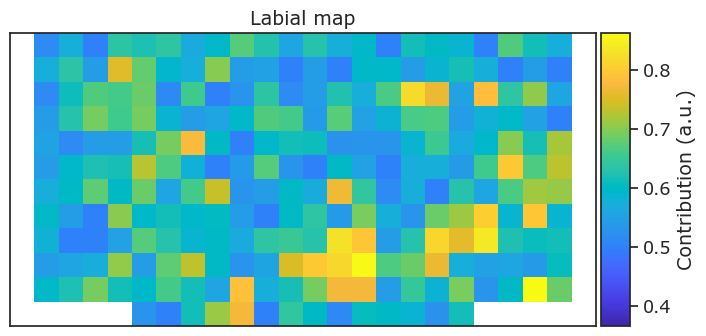

In [254]:
# chan_disp(dorsal_map_S33.flatten(), np.fliplr(np.flipud(np.arange(288).reshape(12,24)))+1, 'Dorsal map', 'Contribution (a.u.)')
chan_disp(pt_artic_maps['S33']['weights'][2], pt_artic_maps['S33']['weight_map'], 'Labial map', 'Contribution (a.u.)')

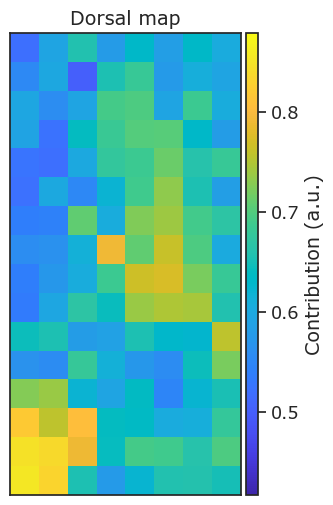

In [255]:
# chan_disp(dorsal_map_S14.flatten(), np.arange(128).reshape(8,16).T+1, 'Dorsal map', 'Contribution (a.u.)')
chan_disp(pt_artic_maps['S14']['weights'][3], pt_artic_maps['S14']['weight_map'], 'Dorsal map', 'Contribution (a.u.)')

In [223]:
from sklearn.preprocessing import MinMaxScaler

# scale mean from pca to work in articulator map space for S33
sc_S33 = MinMaxScaler(feature_range=(np.nanmin(pt_artic_maps['S33']['weights'][2]), np.nanmax(pt_artic_maps['S33']['weights'][2])))
# sc_S33 = MinMaxScaler(feature_range=(0.5, 1))
sc_S33.fit(all_pt_elec_data[3].reshape(-1, all_pt_elec_data[3].shape[-1]))
sc_mean_S33 = np.squeeze(sc_S33.transform(pcas[3].mean_[None,:]))

# scale mean for mapping back up to S14 space
# sc_S14 = MinMaxScaler(feature_range=(np.nanmin(labial_map.flatten()), np.nanmax(labial_map.flatten())))
# sc_S14.fit(all_pt_elec_data[0].reshape(-1, all_pt_elec_data[0].shape[-1]))
# sc_mean_S14 = np.squeeze(sc_S14.transform(pcas[0].mean_[None,:]))

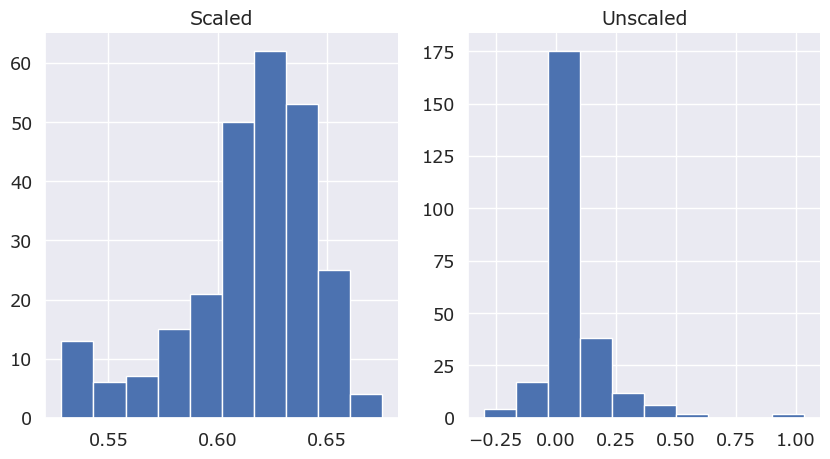

In [224]:
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(sc_mean_S33)
plt.title('Scaled')
plt.subplot(1,2,2)
plt.hist(pcas[3].mean_)
plt.title('Unscaled')
sns.despine()
plt.show()

In [ ]:
def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def mse(a,b):
    return np.mean((a-b)**2)

In [362]:
all_pt_elec_data[3].shape

(46, 200, 256)

In [374]:
artic_map_sims = {}
artic_map_sims_null = {}
for target_pt in pt_names:
# for target_pt in ['S14']:
    print(f'##### {target_pt} #####')

    # target_pt = 'S14'
    target_maps = pt_artic_maps[target_pt]['weights']
    target_pt_ind = pt_names.index(target_pt)
    target_dr = alignDict_allPts[target_pt]['pcas'][target_pt]
    # target_chan_map = np.arange(128).reshape(8,16).T+1 # S14
    # target_chan_map = np.fliplr(np.flipud(np.arange(288).reshape(12,24)))+1 # S33
    target_chan_map = pt_artic_maps[target_pt]['weight_map']
    artic_map_sims[target_pt] = {}
    artic_map_sims_null[target_pt] = {}

    pt_names_artic_recon = [target_pt] + [pt for pt in pt_names if pt != target_pt]
    # pt_names_artic_recon = [target_pt] + ['S33', 'S58', 'S62']

    sim_values = []
    sim_values_null = []
    artic_recons = np.zeros((target_maps.shape[0], len(pt_names_artic_recon[1:]), all_pt_elec_data[pt_names.index(target_pt)].shape[-1]))
    artic_nulls = np.zeros((target_maps.shape[0], len(pt_names_artic_recon[1:]), all_pt_elec_data[pt_names.index(target_pt)].shape[-1]))
    # artic_recons = np.zeros((target_maps.shape[0], 1, target_maps.shape[1]))
    for i_artic, lab in enumerate(artic_labels):
        map_target = target_maps[i_artic]
        # sim_pts = []
        # sim_null_pts = []
        for i_pt, input_pt in enumerate(pt_names_artic_recon[1:]):
        # for i_pt, input_pt in enumerate(['S26']):
            # input_pt = 'S33'
            
            map_input = pt_artic_maps[input_pt]['weights'][i_artic]
            input_pt_ind = pt_names.index(input_pt)
            # input_dr = pcas[input_pt_ind]
            # align = aligners[input_pt]
            input_dr = alignDict_allPts[target_pt]['pcas'][input_pt]
            align = alignDict_allPts[target_pt]['aligners'][input_pt]

            # shuff_align = aligners_shuffle['S33']

            map_flat = map_input.flatten()[~np.isnan(map_input.flatten())]
            map_flat = map_flat[None, :] # expand dims for compatibility with transformations below

            # scale the mean of the pca to the articulator map space
            sc_input = MinMaxScaler(feature_range=(np.nanmin(map_flat), np.nanmax(map_flat)))
            sc_input.fit(all_pt_elec_data[input_pt_ind].reshape(-1, all_pt_elec_data[input_pt_ind].shape[-1]))
            sc_mean_input = np.squeeze(sc_input.transform(input_dr.mean_[None,:]))

            map_target_flat = map_target.flatten()[~np.isnan(map_target.flatten())]
            sc_target = MinMaxScaler(feature_range=(np.nanmin(map_target.flatten()), np.nanmax(map_target.flatten())))
            sc_target.fit(all_pt_elec_data[target_pt_ind].reshape(-1, all_pt_elec_data[target_pt_ind].shape[-1]))
            sc_mean_target = np.squeeze(sc_target.transform(target_dr.mean_[None,:]))

            # map_dr = dr.transform(map_flat)
            map_dr = (map_flat - sc_mean_input) @ input_dr.components_.T
            # map_dr = (map_flat - sc_mean_input) @ np.random.rand(*input_dr.components_.shape).T
            # print(map_dr.shape)
            M_a = align.M_a
            M_b = align.M_b
            map_align = map_dr @ M_b @ np.linalg.pinv(M_a)
            # map_align = map_dr @ M_a @ np.linalg.pinv(M_b)
            map_recon = map_align @ target_dr.components_
            map_null = map_dr @ target_dr.components_
            # artic_recons.append(map_recon.squeeze())
            artic_recons[i_artic, i_pt, :] = map_recon.squeeze()
            artic_nulls[i_artic, i_pt, :] = map_null.squeeze()

            # sim = cos_sim(map_recon, map_target_flat - sc_mean_target)
            # sim_pts.append(sim)
            # sim_null = cos_sim(map_null, map_target_flat - sc_mean_target)
            # sim_null_pts.append(sim_null)
            

            ### chance null distribution
            # null_dist = []
            # for _ in range(10000):
            #     # null matrices are random-normal values
            #     # M_a_null = np.random.randn(*align.M_a.shape)
            #     # M_b_null = np.random.randn(*align.M_b.shape)

            #     # null matrices are randomly permuted versions of the original matrices
            #     M_a_null = np.random.permutation(align.M_a[n_comp_drop:,n_comp_drop:].copy())
            #     M_b_null = np.random.permutation(align.M_b[n_comp_drop:,n_comp_drop:].copy())

            #     map_align_null = map_dr @ M_b_null @ np.linalg.pinv(M_a_null)
            #     # map_align_null = map_dr @ M_a_null @ np.linalg.pinv(M_b_null)
            #     map_recon_null = map_align_null @ target_dr.components_[n_comp_drop:,:]

            #     sim_null = cos_sim(map_recon_null.squeeze(), map_target_flat - sc_mean_target)
            #     null_dist.append(sim_null)
            # sim_null = np.array(null_dist)
            # sim_values_null.append(sim_null)
        
            ### shuffled label CCA null distribution
            # null_dist = []
            # for _ in range(50):
            #     # start = time.time()
            #     shuff_align = AlignCCA()
            #     to_align_seqs = [all_pt_phon_seqs[target_pt], np.random.permutation(all_pt_phon_seqs[input_pt])]
            #     shuff_align.fit(to_align[target_pt_ind], to_align[input_pt_ind], to_align_seqs[0], np.random.permutation(to_align_seqs[1]))

            #     M_a_null = shuff_align.M_a[n_comp_drop:,n_comp_drop:]
            #     M_b_null = shuff_align.M_b[n_comp_drop:,n_comp_drop:]
            #     map_align_null = map_dr @ M_b_null @ np.linalg.pinv(M_a_null)
            #     map_recon_null = map_align_null @ target_dr.components_[n_comp_drop:,:]
            #     sim_null = cos_sim(map_recon_null.squeeze(), map_target_flat - sc_mean_target)
            #     null_dist.append(sim_null)
            #     # print(time.time() - start)
            # sim_null = np.array(null_dist)
            # sim_values_null.append(sim_null)

            # M_a_null = shuff_align.M_a[n_comp_drop:,n_comp_drop:]
            # M_b_null = shuff_align.M_b[n_comp_drop:,n_comp_drop:]
            # map_align_null = map_dr @ M_b_null @ np.linalg.pinv(M_a_null)
            # map_recon_null = map_align_null @ target_dr.components_[n_comp_drop:,:]
            # sim_null = cos_sim(map_recon_null.squeeze(), map_target_flat - sc_mean_target)
            # sim_values_null.append(sim_null) 
    
        
        # print(f'Null: {np.mean(sim_null)}')
        avg_recon_map = np.mean(artic_recons[i_artic], axis=0)
        avg_null_map = np.mean(artic_nulls[i_artic], axis=0)

        # sim = cos_sim(map_recon.squeeze(), map_target_flat - sc_mean_target)
        sim = cos_sim(avg_recon_map, map_target_flat - sc_mean_target)
        sim_values.append(sim)
        print(f'Cosine similarity between {lab} map reconstruction: {sim}')
        # sim_values.append(sim_pts)
        # print(f'Cosine similarity between {lab} map reconstruction: {np.mean(sim_values)} +/- {np.std(sim_values)}')

        sim_null = cos_sim(avg_null_map, map_target_flat - sc_mean_target)
        sim_values_null.append(sim_null)
        print(f'Cosine similarity between {lab} map null reconstruction: {sim_null}')
        # sim_values_null.append(sim_null_pts)
        # print(f'Cosine similarity between {lab} map null reconstruction: {np.mean(sim_values_null)} +/- {np.std(sim_values_null)}')

        artic_map_sims[target_pt][lab] = sim
        artic_map_sims_null[target_pt][lab] = sim_null

        # map_target_full = np.full(np.prod(map_target.shape), np.nan)
        # map_target_full[all_pt_good_chans[target_pt_ind]] = map_target_flat - sc_mean_target

        # map_recon_full = np.full(np.prod(map_target.shape), np.nan)
        # map_recon_full[all_pt_good_chans[target_pt_ind]] = avg_recon_map

        # map_null_full = np.full(np.prod(map_target.shape), np.nan)
        # map_null_full[all_pt_good_chans[target_pt_ind]] = avg_null_map

        # chan_disp(map_target_full, target_chan_map, f'Original - {lab}', 'Contribution (a.u.)')
        # # chan_disp(np.abs(map_target.flatten()), np.arange(128).reshape(8,16).T+1, f'Original - {lab}', 'Contribution (a.u.)', cbar_lower=0.5)
        # chan_disp(map_recon_full, target_chan_map, f'Reconstructed - {lab}', 'Contribution (a.u.)')
        # chan_disp(map_null_full, target_chan_map, f'Null - {lab}', 'Contribution (a.u.)')

##### S14 #####
Cosine similarity between low map reconstruction: 0.6706321568220244
Cosine similarity between low map null reconstruction: -0.04271136145621701
Cosine similarity between high map reconstruction: 0.3465821982611812
Cosine similarity between high map null reconstruction: 0.16614065382364432
Cosine similarity between labial map reconstruction: 0.7095805509574565
Cosine similarity between labial map null reconstruction: -0.08587312031416132
Cosine similarity between dorsal map reconstruction: 0.5258065466194144
Cosine similarity between dorsal map null reconstruction: -0.065400584087818
##### S26 #####
Cosine similarity between low map reconstruction: 0.0495059759573917
Cosine similarity between low map null reconstruction: -0.02540922760920568
Cosine similarity between high map reconstruction: 0.20092183110367018
Cosine similarity between high map null reconstruction: -0.06103622373930063
Cosine similarity between labial map reconstruction: -0.17253134246553464
Cosine sim

In [396]:
artic_sim_df = pd.DataFrame(artic_map_sims).T
artic_sim_df['Patient'] = artic_sim_df.index
artic_sim_df = artic_sim_df.reset_index(drop=True)
artic_sim_df = pd.melt(artic_sim_df, id_vars=['Patient'], var_name='Articulator', value_name='Cosine Similarity')

artic_sim_null_df = pd.DataFrame(artic_map_sims_null).T
artic_sim_null_df['Patient'] = artic_sim_null_df.index
artic_sim_null_df = artic_sim_null_df.reset_index(drop=True)
artic_sim_null_df = pd.melt(artic_sim_null_df, id_vars=['Patient'], var_name='Articulator', value_name='Cosine Similarity')

artic_sim_df['Type'] = 'Reconstruction'
artic_sim_null_df['Type'] = 'Null'
artic_sim_full_df = pd.concat([artic_sim_df, artic_sim_null_df])
artic_sim_full_df['Articulator'] = artic_sim_full_df['Articulator'].str.capitalize()
artic_sim_full_df = artic_sim_full_df[['Patient', 'Articulator', 'Type', 'Cosine Similarity']]
artic_sim_full_df

Patient Articulator            Type  Cosine Similarity
0      S14         Low  Reconstruction           0.670632
1      S26         Low  Reconstruction           0.049506
2      S23         Low  Reconstruction           0.590881
3      S33         Low  Reconstruction           0.177949
4      S22         Low  Reconstruction           0.325656
..     ...         ...             ...                ...
27     S33      Dorsal            Null           0.024888
28     S22      Dorsal            Null           0.031496
29     S39      Dorsal            Null           0.040749
30     S58      Dorsal            Null          -0.160110
31     S62      Dorsal            Null          -0.059703

[64 rows x 4 columns]

In [430]:
# fig = px.box(artic_sim_full_df, x='Articulator', y="Cosine Similarity", color='Type', width=800, height=600, color_discrete_sequence=px.colors.qualitative.Plotly)
fig = px.box(artic_sim_full_df, x='Type', y="Cosine Similarity", width=800, height=600, color_discrete_sequence=px.colors.qualitative.Plotly)

# fig.update_traces(mode='lines')
# fig.add_traces(px.box(recon_acc_df, x='Condition', y="Decoding Accuracy").data)
# fig = px.box(corr_df, x='Condition', y="Correlation", width=800, height=500)
# fig.add_traces(px.line(corr_df, x='Condition', y="Correlation", color='Patient', error_y='Error').data)
# fig.update_traces(mode='markers+lines')
fig.add_hline(y=0, line_dash='dash', line_color='grey')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text='Cosine Similarity of Articulator Map Reconstruction',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='Articulator Type',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1],
    # range=[-0.45, 2.65],
    # ticktext=['Patient-Specific', 'Shared Neural<br>Latent Space'],
)
fig.update_yaxes(
    # title='Pearson <i>r</i>',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # range=[-0.3, 0.85],
    range=[-0.4, 0.85],
)
fig.show()

In [420]:
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection

def mean_stat(a, b, axis=0):
    return np.mean(a, axis=axis) - np.mean(b, axis=axis)

artic_sim_pvals = []

low = artic_sim_df[artic_sim_df['Articulator'] == 'low']['Cosine Similarity']
low_null = artic_sim_null_df[artic_sim_null_df['Articulator'] == 'low']['Cosine Similarity']
low_res = stats.permutation_test((low, low_null), mean_stat, n_resamples=np.inf, vectorized=True)
artic_sim_pvals.append(low_res.pvalue)

high = artic_sim_df[artic_sim_df['Articulator'] == 'high']['Cosine Similarity']
high_null = artic_sim_null_df[artic_sim_null_df['Articulator'] == 'high']['Cosine Similarity']
high_res = stats.permutation_test((high, high_null), mean_stat, n_resamples=np.inf, vectorized=True)
artic_sim_pvals.append(high_res.pvalue)

labial = artic_sim_df[artic_sim_df['Articulator'] == 'labial']['Cosine Similarity']
labial_null = artic_sim_null_df[artic_sim_null_df['Articulator'] == 'labial']['Cosine Similarity']
labial_res = stats.permutation_test((labial, labial_null), mean_stat, n_resamples=np.inf, vectorized=True)
artic_sim_pvals.append(labial_res.pvalue)

dorsal = artic_sim_df[artic_sim_df['Articulator'] == 'dorsal']['Cosine Similarity']
dorsal_null = artic_sim_null_df[artic_sim_null_df['Articulator'] == 'dorsal']['Cosine Similarity']
dorsal_res = stats.permutation_test((dorsal, dorsal_null), mean_stat, n_resamples=np.inf, vectorized=True)
artic_sim_pvals.append(dorsal_res.pvalue)

artic_sim_pvals_corr = fdrcorrection(artic_sim_pvals)
print('Low Articulator:')
print(artic_sim_pvals_corr[1][0])

print('High Articulator:')
print(artic_sim_pvals_corr[1][1])

print('Labial Articulator:')
print(artic_sim_pvals_corr[1][2])

print('Dorsal Articulator:')
print(artic_sim_pvals_corr[1][3])


Low Articulator:
0.010567210567210567
High Articulator:
0.1637917637917638
Labial Articulator:
0.0861952861952862
Dorsal Articulator:
0.010567210567210567


In [437]:
recon = artic_sim_full_df[artic_sim_full_df['Type'] == 'Reconstruction']['Cosine Similarity']
recon_null = artic_sim_full_df[artic_sim_full_df['Type'] == 'Null']['Cosine Similarity']
artic_sim_res = stats.permutation_test((recon, recon_null), mean_stat, n_resamples=10000, vectorized=True, permutation_type='samples')
# artic_sim_res = stats.wilcoxon(recon, recon_null)
print('Articulator Map Reconstruction vs Null p-value:')
print(artic_sim_res.pvalue)

Articulator Map Reconstruction vs Null p-value:
0.00019998000199980003


#### Reconstruction Decoding

In [213]:
from sklearn.metrics import confusion_matrix

def cmat_acc(y_true, y_pred):
    cmat = confusion_matrix(y_true, y_pred)
    acc_cmat = np.trace(cmat) / np.sum(cmat)
    return acc_cmat

def cmat_wrap(y_true_iter, y_pred_iter):
    accs = []
    for y_true, y_pred in zip(y_true_iter, y_pred_iter):
        accs.append(cmat_acc(y_true, y_pred))
    return np.array(accs)

In [214]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from tqdm import tqdm
from sklearn.base import clone

from decomposition.DimRedReshape import DimRedReshape


def recon_decode(X, y, model):
    # extract data for patient
    # X = recons[pt].reshape(recons[pt].shape[0], -1)
    # y = all_pt_artic_labels[pt]

    y_pred = model.predict(X)
    acc = cmat_acc(y, y_pred)
    return acc

def pt_decode(pt, save_models=False, do_cv=False, n_folds=20):
    X = all_pt_elec_data[pt_names.index(pt)].reshape(all_pt_elec_data[pt_names.index(pt)].shape[0], -1)
    y = all_pt_artic_labels[pt]

    return PCA_decode(X, y, pt, save_models=save_models, do_cv=do_cv, n_folds=n_folds)


def PCA_decode(X, y, pt, save_models=False, do_cv=False, n_folds=20):
    
    ### Setup ###
    dim_red = PCA
    decoder = SVC(
            kernel='rbf',
            class_weight='balanced',
            )
    clf = make_pipeline(
                DimRedReshape(dim_red),
                BaggingClassifier(
                    estimator=decoder,
                    # n_estimators=10,
                    n_jobs=-1,
                    )
                )

    if do_cv:
        param_grid = {
            'dimredreshape__n_components': np.arange(0.1, 1, 0.1),
                    }
    else:
        param_grid = {
            'dimredreshape__n_components': 0.8,
                    }


    # use stratified kfold if possible
    try:
        cv = StratifiedKFold(n_splits=n_folds, shuffle=True)
        splits = list(cv.split(X, y))
    except ValueError:
        cv = KFold(n_splits=n_folds, shuffle=True)
        splits = list(cv.split(X, y))


    y_test_folds = []
    y_pred_folds = []
    fold_models = [clone(clf) for _ in range(n_folds)]
    for i in tqdm(range(len(splits)), desc=pt):
        train_idx, test_idx = splits[i]
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if do_cv:
            grid = GridSearchCV(clf, param_grid, cv=n_folds, n_jobs=-1)
            grid.fit(X_train, y_train)
            print(f'Best Params: {grid.best_params_}')
            best_params = grid.best_params_
        else:
            best_params = param_grid

        model = fold_models[i]
        model.set_params(**best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_test_folds.extend(y_test)
        y_pred_folds.extend(y_pred)

    acc = cmat_acc(y_test_folds, y_pred_folds)

    if save_models:
        return acc, fold_models
    else:
        return acc

In [320]:
# get S14 accuracy and save models to apply to reconstruction data
recon_acc, recon_models = pt_decode(recon_pt, save_models=True, do_cv=False)
print(f'{recon_pt} Accuracy: {recon_acc}')

# get non-reconstruction accuracies for comparison
ps_accs = {}
other_pts = [pt for pt in pt_names if pt != recon_pt]
for pt in other_pts:
    pt_acc = pt_decode(pt, do_cv=False)
    ps_accs[pt] = pt_acc
    print(f'{pt} Accuracy: {pt_acc}')

S14: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


S14 Accuracy: 0.6388888888888888


S26: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


S26 Accuracy: 0.6756756756756757


S23: 100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


S23 Accuracy: 0.41721854304635764


S33: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


S33 Accuracy: 0.2826086956521739


S22: 100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


S22 Accuracy: 0.26490066225165565


S39: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


S39 Accuracy: 0.22627737226277372


S58: 100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


S58 Accuracy: 0.24113475177304963


S62: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]

S62 Accuracy: 0.5224719101123596


In [321]:
recon_accs = {}
for pt in other_pts:
    model_accs = []
    for model in recon_models:
        X_curr = recons[pt].reshape(recons[pt].shape[0], -1)
        y_curr = all_pt_artic_labels[pt]
        acc_curr = recon_decode(X_curr, y_curr, model)
        model_accs.append(acc_curr)
    print(f'{pt} Reconstruction Accuracy: {np.mean(model_accs)} +/- {np.std(model_accs)}')
    recon_accs[pt] = np.mean(model_accs)

    # y_pred_curr = grid.predict(X_curr)
    # y_pred_curr = clf.predict(X_curr)
    # acc_curr = cmat_acc(y_curr, y_pred_curr)
    # print(f'{pt} Reconstruction Accuracy: {acc_curr}')
    # recon_accs[pt] = acc_curr

S26 Reconstruction Accuracy: 0.4871621621621622 +/- 0.01494144891047026
S23 Reconstruction Accuracy: 0.46589403973509935 +/- 0.016919849392107583
S33 Reconstruction Accuracy: 0.5467391304347826 +/- 0.0390548787461341
S22 Reconstruction Accuracy: 0.42384105960264895 +/- 0.017893054418683836
S39 Reconstruction Accuracy: 0.3397810218978102 +/- 0.01672074626124863
S58 Reconstruction Accuracy: 0.3046099290780142 +/- 0.008532772635117716
S62 Reconstruction Accuracy: 0.4525280898876404 +/- 0.017539880073875466


In [322]:
null_accs = {}
for pt in other_pts:
    model_accs = []
    for model in recon_models:
        X_curr = recons_null[pt].reshape(recons_null[pt].shape[0], -1)
        y_curr = all_pt_artic_labels[pt]
        acc_curr = recon_decode(X_curr, y_curr, model)
        model_accs.append(acc_curr)
    print(f'{pt} Null Reconstruction Accuracy: {np.mean(model_accs)} +/- {np.std(model_accs)}')
    null_accs[pt] = np.mean(model_accs)

S26 Null Reconstruction Accuracy: 0.22263513513513516 +/- 0.0069153680711009176
S23 Null Reconstruction Accuracy: 0.2231788079470199 +/- 0.0066555467689542284
S33 Null Reconstruction Accuracy: 0.2630434782608696 +/- 0.027412000462866282
S22 Null Reconstruction Accuracy: 0.23278145695364238 +/- 0.006377933868959672
S39 Null Reconstruction Accuracy: 0.22189781021897814 +/- 0.005839416058394159
S58 Null Reconstruction Accuracy: 0.2046099290780142 +/- 0.01682436335358363
S62 Null Reconstruction Accuracy: 0.27415730337078653 +/- 0.012761591788315214


In [323]:
recon_acc_df = pd.DataFrame()
for i, pt in enumerate(other_pts):
    recon_acc_df = pd.concat([recon_acc_df, pd.DataFrame({'Patient': pt, 'Within-Patient': ps_accs[pt], 'Reconstruction in S14<br>Space (Aligned)': recon_accs[pt], 'Reconstruction in S14<br>Space (Unaligned)': null_accs[pt]}, index=[i])])

recon_acc_df = recon_acc_df.melt(id_vars='Patient', var_name='Condition', value_name='Decoding Accuracy')

In [324]:
fig = px.line(recon_acc_df, x='Condition', y="Decoding Accuracy", color='Patient', width=800, height=600, color_discrete_sequence=px.colors.qualitative.Plotly[1:])
# fig.update_traces(mode='lines')
fig.add_traces(px.box(recon_acc_df, x='Condition', y="Decoding Accuracy").data)
# fig = px.box(corr_df, x='Condition', y="Correlation", width=800, height=500)
# fig.add_traces(px.line(corr_df, x='Condition', y="Correlation", color='Patient', error_y='Error').data)
# fig.update_traces(mode='markers+lines')
fig.add_hline(y=1/4, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='top right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text='Articulator Decoding on Cross-Patient Reconstructions',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1],
    range=[-0.45, 2.65],
    # ticktext=['Patient-Specific', 'Shared Neural<br>Latent Space'],
)
fig.update_yaxes(
    # title='Pearson <i>r</i>',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[-0.025, 0.85]
)
fig.show()

In [ ]:
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection

def mean_stat(a, b, axis=0):
    return np.mean(a, axis=axis) - np.mean(b, axis=axis)

recon_acc_pvals = []

wp = recon_acc_df[recon_acc_df['Condition'] == 'Within-Patient']['Decoding Accuracy']
recon_algn = recon_acc_df[recon_acc_df['Condition'] == 'Reconstruction in S14<br>Space (Aligned)']['Decoding Accuracy']
wp_recon_res = stats.permutation_test((wp, recon_algn), mean_stat, n_resamples=np.inf, vectorized=True)
recon_acc_pvals.append(wp_recon_res.pvalue)

recon_null = recon_acc_df[recon_acc_df['Condition'] == 'Reconstruction in S14<br>Space (Unaligned)']['Decoding Accuracy']
algn_null_res = stats.permutation_test((recon_algn, recon_null), mean_stat, n_resamples=np.inf, vectorized=True)
recon_acc_pvals.append(algn_null_res.pvalue)

recon_acc_pvals_corr = fdrcorrection(recon_acc_pvals)

print('Within-Patient vs. Reconstruction in S14 Space (Aligned):')
print(recon_acc_pvals_corr[1][0])

print('Reconstruction in S14 Space (Aligned) vs. Reconstruction in S14 Space (Unaligned):')
print(recon_acc_pvals_corr[1][1])


Within-Patient vs. Reconstruction in S14 Space (Aligned):
0.44813519813519814
Reconstruction in S14 Space (Aligned) vs. Reconstruction in S14 Space (Unaligned):
0.0011655011655011655


### (M)CCA Maps

In [29]:
from alignment.alignment_utils import extract_group_conditions
from alignment.AlignMCCA import n_components_var
from mvlearn.embed import MCCA

In [30]:
all_pt_data = [all_pt_traces[pt] for pt in pt_names]
all_pt_pseqs = [all_pt_phon_seqs[pt] for pt in pt_names]

#### MCCA fitting (significant electrodes)

In [90]:
n_comp = 25
pca_var = 0.9
ranks = [n_components_var(x.reshape(-1, x.shape[-1]), pca_var) for x in all_pt_data]

cnd_avg_data = extract_group_conditions(all_pt_data, all_pt_pseqs)
cnd_avg_data = [d.reshape(-1, d.shape[-1]) for d in cnd_avg_data]

mcca = MCCA(n_components=n_comp, regs=0.5, signal_ranks=ranks)
mcca_scores = mcca.fit_transform(cnd_avg_data)

In [91]:
mcca_corrs = mcca.canon_corrs(mcca_scores)
print(mcca_corrs.shape)
# print(mcca_corrs)

# average across non diagonal elements in correlation matrices
weights = (mcca_corrs != 1).astype(int)
pt_corrs = np.average(mcca_corrs, weights=weights, axis=1).T
print(pt_corrs.shape)

(25, 8, 8)
(8, 25)


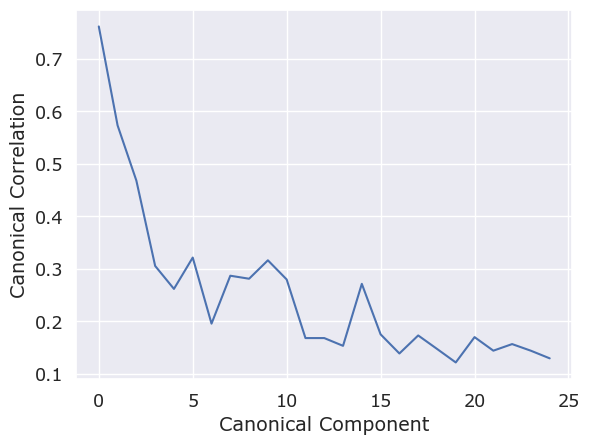

In [92]:
plt.figure()
plt.plot(pt_corrs[0])
plt.xlabel('Canonical Component')
plt.ylabel('Canonical Correlation')
plt.show()

#### Propagate MCCA correlations up

In [126]:
prop_comps = 2
pt_mcca_elecs = {}
for i, (corrs, pt) in enumerate(zip(pt_corrs, pt_names)):
    # print(i, pt)
    pt_loading = mcca.loadings_[i]
    loading_inv = np.linalg.pinv(pt_loading)
    corr_elecs = np.dot(corrs[:prop_comps], loading_inv[:prop_comps, :])
    pt_mcca_elecs[pt] = np.full(np.prod(all_pt_chan_data[pt]['map'].shape), np.nan)
    pt_mcca_elecs[pt][all_pt_chan_data[pt]['sig'].flatten()] = corr_elecs
    print(pt_mcca_elecs[pt].shape)

(128,)
(128,)
(128,)
(288,)
(128,)
(288,)
(288,)
(288,)


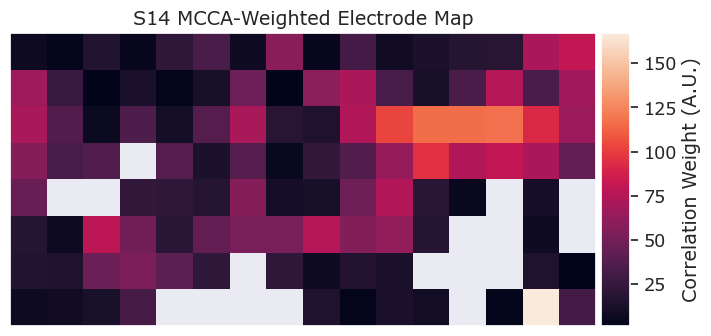

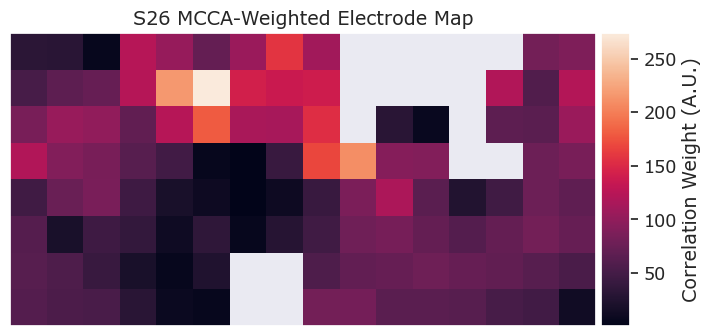

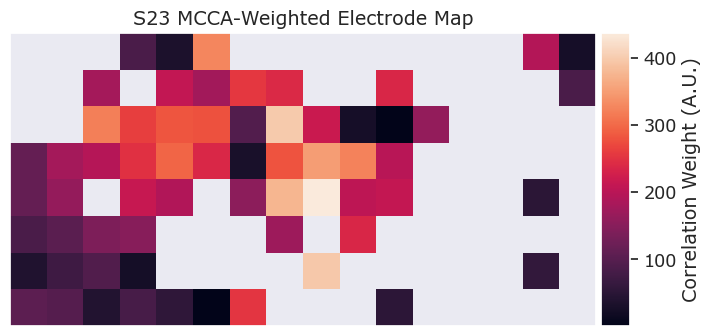

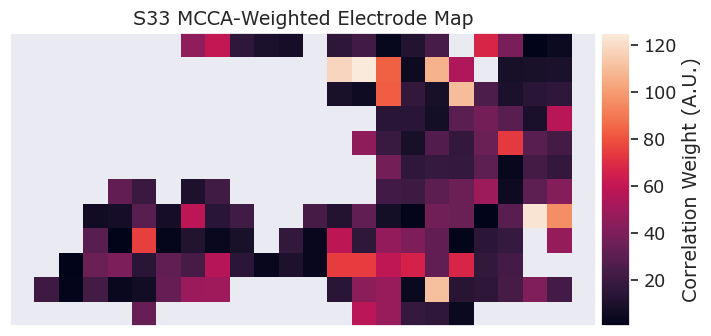

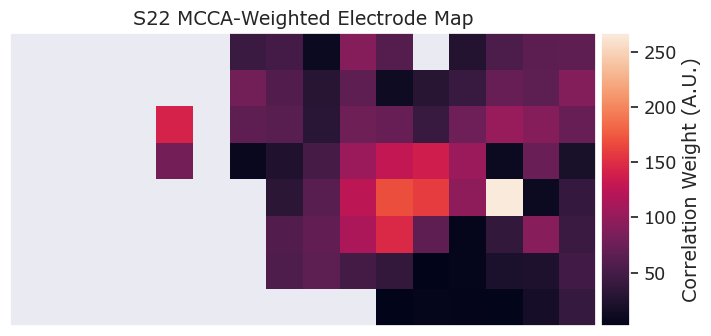

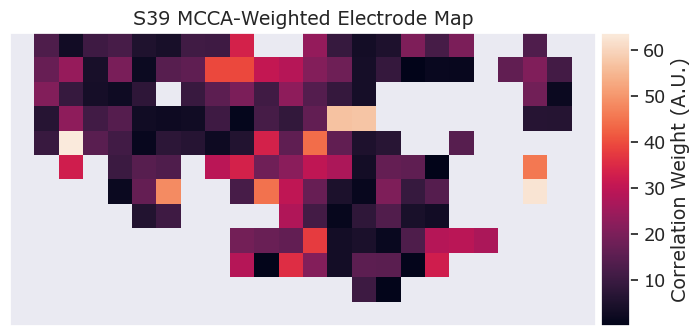

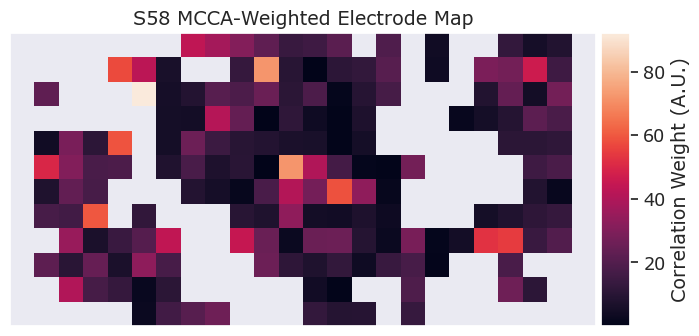

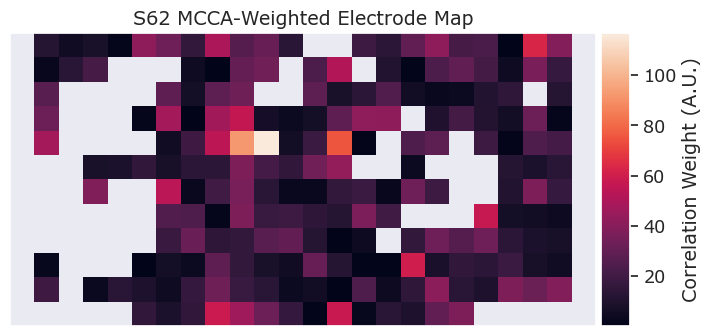

In [138]:
for pt, elecs in pt_mcca_elecs.items():
    chan_disp(np.abs(elecs), np.flipud(all_pt_chan_data[pt]['map']), f'{pt} MCCA-Weighted Electrode Map', 'Correlation Weight (A.U.)', figsize=(8,6))

In [128]:
sig_mcca_elecs = 0
sig_total_elecs = 0
for pt, elecs in pt_mcca_elecs.items():
    # count number of electrodes with correlation weights above 10th percentile
    # sig_mcca_elecs += np.sum(elecs >= np.nanpercentile(elecs, 10))
    thresh = 0.2 * np.nanmax(elecs)
    sig_mcca_elecs += np.sum(elecs >= thresh)
    # print(np.nanmean(elecs), np.nanpercentile(elecs, 10))
    sig_total_elecs += elecs.shape[0]
print(f'{sig_mcca_elecs} significant aligned electrodes out of {sig_total_elecs} total electrodes ({sig_mcca_elecs/sig_total_elecs:.2f})')

383 significant aligned electrodes out of 1664 total electrodes (0.23)


#### MCCA fitting (all electrodes)

In [20]:
all_pt_elec_data = [np.transpose(all_pt_dict[pt]['X1_map'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1, all_pt_dict[pt]['X1_map'].shape[-1]), axes=(0,2,1)) for pt in pt_names]
all_pt_good_idx = []
for i, (pt, d) in enumerate(zip(pt_names, all_pt_elec_data)):
    d[d == 0] = np.nan
    all_pt_good_idx.append(np.where(~np.isnan(d)))
    all_pt_elec_data[i] = d[np.where(~np.isnan(d))].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1)
# all_pt_elec_data = [x[~np.isnan(x).all(axis=(12))] for x in all_pt_elec_data]
print([x.shape for x in all_pt_elec_data])
print([x[0].shape for x in all_pt_good_idx])

[(144, 200, 128), (148, 200, 128), (151, 200, 128), (46, 200, 256), (151, 200, 128), (137, 200, 256), (141, 200, 256), (178, 200, 256)]
[(3686400,), (3788800,), (3865600,), (2355200,), (3865600,), (7014400,), (7219200,), (9113600,)]


In [25]:
n_comp = 25
pca_var = 0.9
ranks = [n_components_var(x.reshape(-1, x.shape[-1]), pca_var) for x in all_pt_data]

cnd_avg_data_all = extract_group_conditions(all_pt_elec_data, all_pt_pseqs)
# print([d.shape for d in cnd_avg_data])
cnd_avg_data_all = [d.reshape(-1, d.shape[-1]) for d in cnd_avg_data_all]

mcca_all = MCCA(n_components=n_comp, regs=0.5, signal_ranks=ranks)
mcca_all_scores = mcca_all.fit_transform(cnd_avg_data_all)

In [26]:
mcca_all_corrs = mcca_all.canon_corrs(mcca_all_scores)
print(mcca_all_corrs.shape)
# print(mcca_corrs)

# average across non diagonal elements in correlation matrices
weights_all = (mcca_all_corrs != 1).astype(int)
pt_corrs_all = np.average(mcca_all_corrs, weights=weights_all, axis=1).T
print(pt_corrs_all.shape)

(25, 8, 8)
(8, 25)


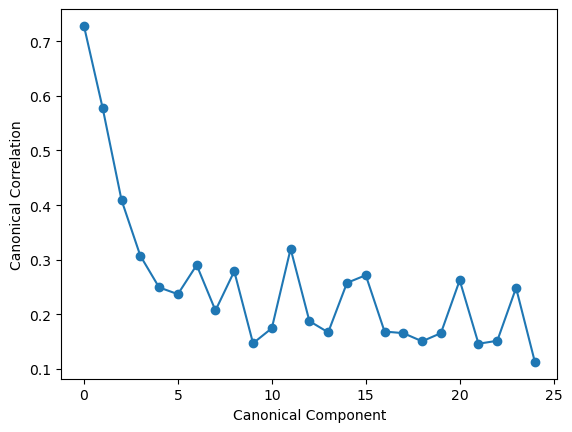

In [27]:
plt.figure()

plt.plot(pt_corrs_all[0], '-o')
plt.xlabel('Canonical Component')
plt.ylabel('Canonical Correlation')
plt.show()

#### Propagate MCCA-weighted activity up

In [28]:
prop_comps = [1,2]

# pt_mcca_timeseries = {}
# for i, (corrs, pt) in enumerate(zip(pt_corrs, pt_names)):
#     # print(i, pt)
#     # calcuate mcca projection
#     to_transform = all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])
#     mcca_data = mcca.transform_view(to_transform, i)
#     # weight activity by canonical correlation
#     corr_activ = mcca_data * corrs

#     # get mapping back to electrode space
#     pt_loading = mcca.loadings_[i]
#     loading_inv = np.linalg.pinv(pt_loading)

#     # map correlation weighted activity back to electrode space
#     corr_elecs = np.dot(corr_activ[:, prop_comps[0]:prop_comps[1]], loading_inv[prop_comps[0]:prop_comps[1], :])
#     corr_elecs = corr_elecs.reshape(all_pt_traces[pt].shape[0],
#                                     all_pt_traces[pt].shape[1],
#                                     -1)
#     pt_mcca_timeseries[pt] = {}
#     pt_mcca_timeseries[pt]['MCCA'] = np.full((all_pt_traces[pt].shape[0],
#                                  all_pt_traces[pt].shape[1],
#                                  np.prod(all_pt_chan_data[pt]['map'].shape)),
#                                  np.nan)
#     pt_mcca_timeseries[pt]['MCCA'][:,:,all_pt_chan_data[pt]['sig'].flatten()] = corr_elecs
    
#     pt_mcca_timeseries[pt]['MCCA'] = np.nan_to_num(pt_mcca_timeseries[pt]['MCCA'], nan=0)

#     pt_mcca_timeseries[pt]['Reg'] = np.full((all_pt_traces[pt].shape[0],
#                                  all_pt_traces[pt].shape[1],
#                                  np.prod(all_pt_chan_data[pt]['map'].shape)),
#                                  np.nan)
#     pt_mcca_timeseries[pt]['Reg'][:,:,all_pt_chan_data[pt]['sig'].flatten()] = all_pt_traces[pt]
#     pt_mcca_timeseries[pt]['Reg'] = np.nan_to_num(pt_mcca_timeseries[pt]['Reg'], nan=0)

#     print(pt_mcca_timeseries[pt]['MCCA'].shape, pt_mcca_timeseries[pt]['Reg'].shape)

elec_data_full = [np.transpose(all_pt_dict[pt]['X1_map'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1, all_pt_dict[pt]['X1_map'].shape[-1]), axes=(0,2,1)) for pt in pt_names]

pt_mcca_timeseries = {}
for i, (corrs, pt) in enumerate(zip(pt_corrs_all, pt_names)):
    # print(i, pt)
    # calcuate mcca projection
    to_transform = all_pt_elec_data[i].reshape(-1, all_pt_elec_data[i].shape[-1])
    mcca_data = mcca_all.transform_view(to_transform, i)
    # weight activity by canonical correlation
    corr_activ = mcca_data * corrs

    # get mapping back to electrode space
    pt_loading = mcca_all.loadings_[i]
    loading_inv = np.linalg.pinv(pt_loading)

    # map correlation weighted activity back to electrode space
    corr_elecs = np.dot(corr_activ[:,prop_comps[0]:prop_comps[1]], loading_inv[prop_comps[0]:prop_comps[1], :])
    corr_elecs = corr_elecs.reshape(all_pt_traces[pt].shape[0],
                                    all_pt_traces[pt].shape[1],
                                    -1)
    pt_mcca_timeseries[pt] = {}
    pt_mcca_timeseries[pt]['MCCA'] = np.full((all_pt_traces[pt].shape[0],
                                 all_pt_traces[pt].shape[1],
                                 np.prod(all_pt_chan_data[pt]['map'].shape)),
                                 np.nan)
    pt_mcca_timeseries[pt]['MCCA'][all_pt_good_idx[i]] = corr_elecs.flatten()
    # pt_mcca_timeseries[pt]['MCCA'] = np.nan_to_num(pt_mcca_timeseries[pt]['MCCA'], nan=0)

    temp = elec_data_full[i]
    temp[temp == 0] = np.nan
    pt_mcca_timeseries[pt]['Reg'] = temp

    print(pt_mcca_timeseries[pt]['MCCA'].shape, pt_mcca_timeseries[pt]['Reg'].shape)

(144, 200, 128) (144, 200, 128)
(148, 200, 128) (148, 200, 128)
(151, 200, 128) (151, 200, 128)
(46, 200, 288) (46, 200, 288)
(151, 200, 128) (151, 200, 128)
(137, 200, 288) (137, 200, 288)
(141, 200, 288) (141, 200, 288)
(178, 200, 288) (178, 200, 288)


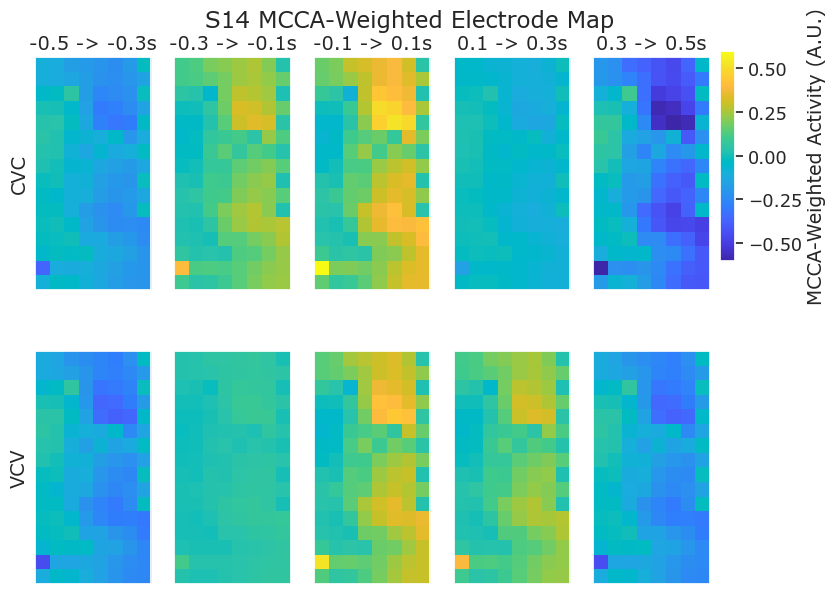

In [32]:
sns.set_theme(context='notebook', font='Verdana', font_scale=1.15)

pt = 'S14'
# cnd_labels = all_pt_phon_labels[pt]
# lab_names = phon_labels
# cnd_labels = all_pt_artic_labels[pt]
# lab_names = artic_labels
cnd_labels = all_pt_cv_labels[pt]
lab_names = ['CVC', 'VCV']
mcca_avg = cnd_avg(pt_mcca_timeseries[pt]['MCCA'], cnd_labels)
reg_avg = cnd_avg(pt_mcca_timeseries[pt]['Reg'], cnd_labels)


t_ranges = [[-0.5, -0.3], [-0.3, -0.1], [-0.1, 0.1], [0.1, 0.3], [0.3, 0.5]]

if all_pt_chan_data[pt]['map'].size == 128:
    # chan_map = all_pt_chan_data[pt]['map'].T
    chan_map = np.arange(128).reshape(8,16).T+1
    figsize=(2,3.5)
    cbar_pos = [0.81, 0.58, 0.015, 0.3]
    sup_pos = 0.94
else:
    # chan_map = np.flipud(all_pt_chan_data[pt]['map'])
    chan_map = np.fliplr(np.flipud(np.arange(288).reshape(12,24)))+1
    figsize=(4,2)
    cbar_pos = [0.81, 0.56, 0.01, 0.3]
    sup_pos = 0.98
chan_disp_seq(mcca_avg, chan_map, t, t_ranges, lab_names, f'{pt} MCCA-Weighted Electrode Map', 'MCCA-Weighted Activity (A.U.)', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos)
# chan_disp_seq(np.abs(reg_avg), chan_map, t, t_ranges, lab_names, f'{pt} Regular Electrode Map', 'HG Z-score', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos)


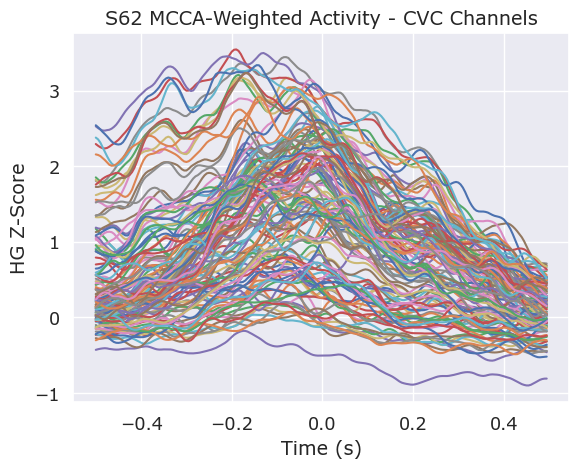

In [96]:
plt.figure()

# plt.plot(t, mcca_avg[0])
# plt.ylabel('MCCA-Weighted Activity')

plt.plot(t, reg_avg[0])
plt.ylabel('HG Z-Score')

plt.xlabel('Time (s)')
plt.title(f'{pt} MCCA-Weighted Activity - CVC Channels')
plt.show()

#### MCCA correlation with HG Z-score

In [338]:
t_range = [-0.1, 0.1]
t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
mcca_corr_data = []
reg_corr_data = []
# for pt in ['S14', 'S26', 'S23', 'S33']:
for pt in pt_names:
    d_mcca = np.mean(np.mean(pt_mcca_timeseries[pt]['MCCA'][:,t_inds,:], axis=1), axis=0).flatten()
    # d_mcca = np.mean(pt_mcca_timeseries[pt]['MCCA'][:,t_inds,:], axis=1).flatten()

    # remove nans
    d_mcca = d_mcca[~np.isnan(d_mcca)]
    

    d_reg = np.mean(np.mean(pt_mcca_timeseries[pt]['Reg'][:,t_inds,:], axis=1), axis=0).flatten()
    # d_reg = np.mean(pt_mcca_timeseries[pt]['Reg'][:,t_inds,:], axis=1).flatten()

    # remove nans
    d_reg = d_reg[~np.isnan(d_reg)]

    # # remove reg outliers (3 standard deviations from mean)
    # d_reg = d_reg[np.abs(d_reg - np.nanmean(d_reg)) < 3*np.nanstd(d_reg)]

    # remove mcca outliers (3 standard deviations from mean)
    outlier_idx_mcca = np.abs(d_mcca - np.mean(d_mcca)) >= 3*np.std(d_mcca)
    outlier_idx_reg = np.abs(d_reg - np.mean(d_reg)) >= 3*np.std(d_reg)
    outlier_idx = np.logical_or(outlier_idx_mcca, outlier_idx_reg)
    d_mcca = d_mcca[~outlier_idx]
    d_reg = d_reg[~outlier_idx]

    # mcca_corr_data.append(d_mcca[d_mcca != 0])
    mcca_corr_data.append(d_mcca)

    # reg_corr_data.append(d_reg[d_reg != 0])
    reg_corr_data.append(d_reg)

# mcca_corr_data = np.array(mcca_corr_data)
# reg_corr_data = np.array(reg_corr_data)

print([x.shape for x in mcca_corr_data])
print([x.shape for x in reg_corr_data])



[(110,), (109,), (62,), (145,), (71,), (143,), (170,), (196,)]
[(110,), (109,), (62,), (145,), (71,), (143,), (170,), (196,)]


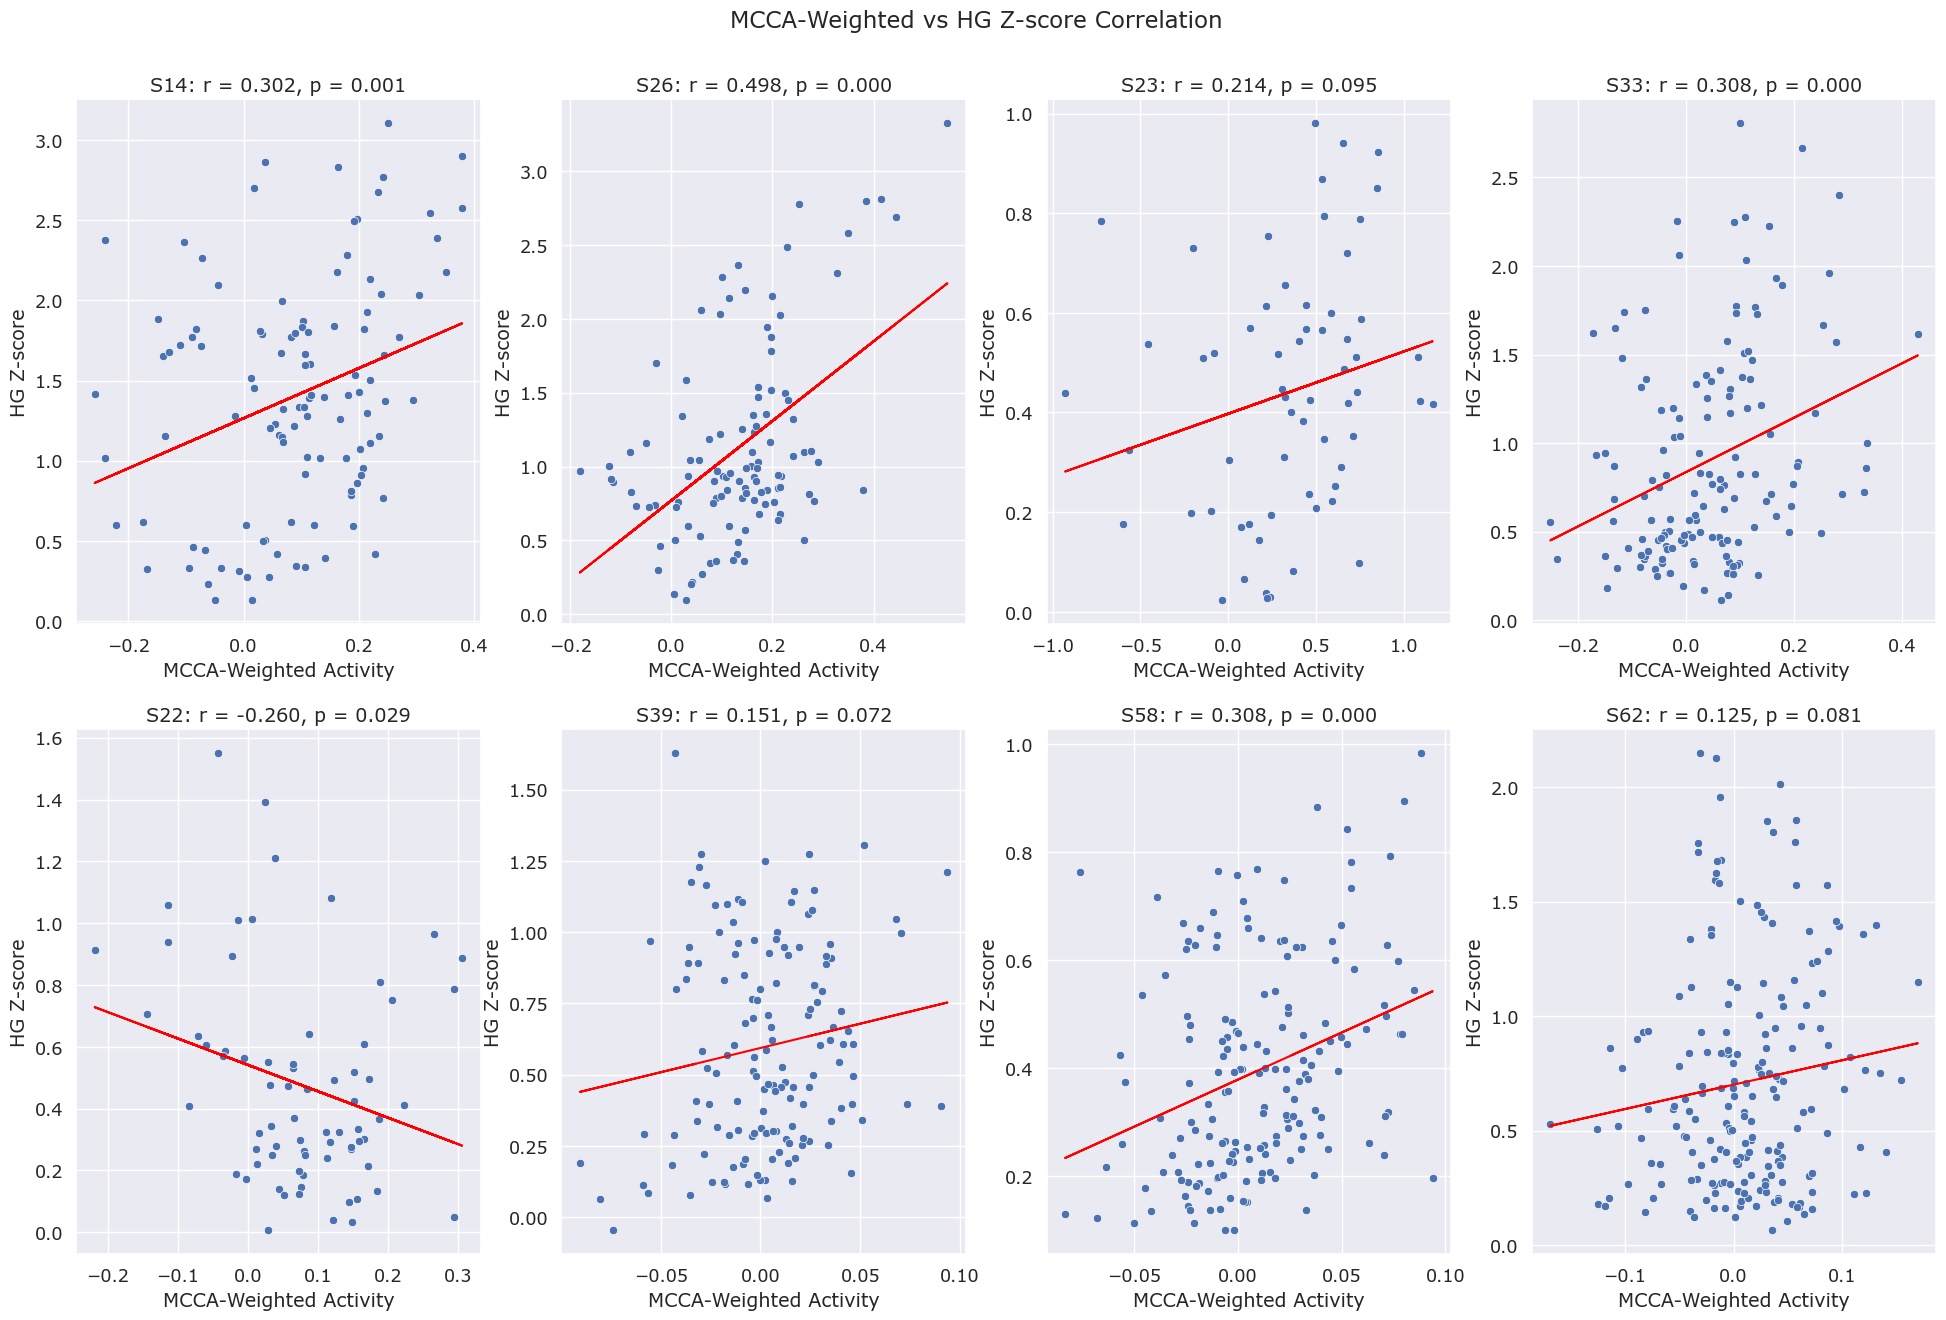

In [328]:
from scipy.stats import linregress

f, axs = plt.subplots(2, int(len(pt_names)/2), figsize=(6*len(pt_names)/2, 15))
axs = axs.flatten()
for i, pt in enumerate(pt_names):
    # calculate relationship between MCCA-Weighted and Regular HG Z-score
    slope, intercept, r_value, p_value, std_err = linregress(mcca_corr_data[i], reg_corr_data[i])
    # print(slope, intercept, r_value, p_value, std_err)
    sns.scatterplot(x=mcca_corr_data[i], y=reg_corr_data[i], ax=axs[i])
    axs[i].plot(mcca_corr_data[i], slope*mcca_corr_data[i] + intercept, color='red')
    axs[i].set_xlabel('MCCA-Weighted Activity')
    axs[i].set_ylabel('HG Z-score')
    axs[i].set_title(f'{pt}: r = {r_value:.3f}, p = {p_value:.3f}')
plt.suptitle('MCCA-Weighted vs HG Z-score Correlation', y=0.94)
plt.show()

In [340]:
mcca_time_data = []
reg_time_data = []
# for pt in ['S14', 'S26', 'S23', 'S33']:
for pt in pt_names:
    d_mcca = pt_mcca_timeseries[pt]['MCCA']
    # remove nans
    d_mcca = d_mcca[~np.isnan(d_mcca)].reshape(all_pt_traces[pt].shape)

    d_mcca = np.mean(np.mean(d_mcca, axis=0), axis=1).flatten()
    # d_mcca = np.mean(pt_mcca_timeseries[pt]['MCCA'][:,t_inds,:], axis=1).flatten()

    d_reg = pt_mcca_timeseries[pt]['Reg']
    # remove nans
    d_reg = d_reg[~np.isnan(d_reg)].reshape(all_pt_traces[pt].shape)
    
    d_reg = np.mean(np.mean(d_reg, axis=0), axis=1).flatten()
    # d_reg = np.mean(pt_mcca_timeseries[pt]['Reg'][:,t_inds,:], axis=1).flatten()

    # mcca_corr_data.append(d_mcca[d_mcca != 0])
    mcca_time_data.append(d_mcca)

    # reg_corr_data.append(d_reg[d_reg != 0])
    reg_time_data.append(d_reg)

# mcca_corr_data = np.array(mcca_corr_data)
# reg_corr_data = np.array(reg_corr_data)

print([x.shape for x in mcca_time_data])
print([x.shape for x in reg_time_data])

[(200,), (200,), (200,), (200,), (200,), (200,), (200,), (200,)]
[(200,), (200,), (200,), (200,), (200,), (200,), (200,), (200,)]


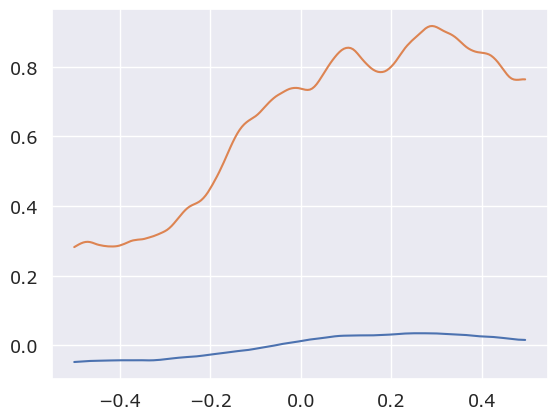

In [352]:
plt.figure()
plt.plot(t, mcca_time_data[7])
plt.plot(t, reg_time_data[7])
plt.show()

#### CCA fitting (All electrodes)

In [23]:
all_pt_elec_data = [np.transpose(all_pt_dict[pt]['X1_map'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1, all_pt_dict[pt]['X1_map'].shape[-1]), axes=(0,2,1)) for pt in pt_names]
all_pt_good_idx = []
for i, (pt, d) in enumerate(zip(pt_names, all_pt_elec_data)):
    d[d == 0] = np.nan
    all_pt_good_idx.append(np.where(~np.isnan(d)))
    all_pt_elec_data[i] = d[np.where(~np.isnan(d))].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1)
# all_pt_elec_data = [x[~np.isnan(x).all(axis=(12))] for x in all_pt_elec_data]
print([x.shape for x in all_pt_elec_data])
print([x[0].shape for x in all_pt_good_idx])

[(144, 200, 128), (148, 200, 128), (151, 200, 128), (46, 200, 256), (151, 200, 128), (137, 200, 256), (141, 200, 256), (178, 200, 256)]
[(3686400,), (3788800,), (3865600,), (2355200,), (3865600,), (7014400,), (7219200,), (9113600,)]


In [25]:
def pt_corr_comp(target, to_corr, target_labels, to_corr_labels, n_comp=25):
    min_dim = min(target.shape[-1], to_corr.shape[-1], n_comp)
    
    # Extract condition-averaged data
    cnd_avg_data = utils.extract_group_conditions([target, to_corr], [target_labels, to_corr_labels])
    
    # Precompute dimensions
    n_cnds = cnd_avg_data[0].shape[0]
    target_avg = cnd_avg_data[0][:,:,:min_dim]
    to_corr_avg = cnd_avg_data[1][:,:,:min_dim]
    
    # Use np.zeros to store correlations
    corrs = np.zeros((n_cnds, min_dim))
    
    # Compute correlations
    for j in range(min_dim):
        # Vectorized Pearson correlation for all conditions at once
        target_data = target_avg[:,:,j]
        to_corr_data = to_corr_avg[:,:,j]
        
        # Mean and std for target and to_corr
        target_mean = np.mean(target_data, axis=1, keepdims=True)
        to_corr_mean = np.mean(to_corr_data, axis=1, keepdims=True)
        
        target_std = np.std(target_data, axis=1, ddof=1, keepdims=True)
        to_corr_std = np.std(to_corr_data, axis=1, ddof=1, keepdims=True)
        
        # Compute Pearson correlations manually
        cov = np.mean((target_data - target_mean) * (to_corr_data - to_corr_mean), axis=1)
        corrs[:, j] = cov / (target_std.flatten() * to_corr_std.flatten())
    
    # Average correlations across conditions
    avg_corrs = np.mean(corrs, axis=0)
    
    return avg_corrs

In [31]:
from sklearn.decomposition import PCA

n_comp = 15
pca_var = 0.9
pt_dr = [PCA(n_components=pca_var) for _ in pt_names]
pt_data_dr = [dr.fit_transform(all_pt_elec_data[i].reshape(-1, all_pt_elec_data[i].shape[-1])).reshape(all_pt_elec_data[i].shape[0], all_pt_elec_data[i].shape[1], -1) for i, dr in enumerate(pt_dr)]

pt_corrs_cca = np.zeros((len(pt_names), n_comp))
for i, pt in enumerate(pt_names):
    target_dr = pt_data_dr[i]
    align_corrs = []
    for j, cpt in enumerate(pt_names):
        if pt == cpt:
            continue
        aligner = AlignCCA()
        aligner.fit(target_dr, pt_data_dr[j], all_pt_phon_seqs[pt], all_pt_phon_seqs[cpt])
        cross_aligned = aligner.transform(pt_data_dr[j])
        canon_corrs = aligner.canon_corrs

        # calculate correlation between target and aligned data
        # start = time.time()
        # corrs = pt_corr_comp(target_dr, cross_aligned, all_pt_phon_seqs[pt], all_pt_phon_seqs[cpt], n_comp=n_comp)
        # corr_time = time.time() - start

        start = time.time()
        corrs = pt_corr_comp(target_dr, cross_aligned, all_pt_phon_seqs[pt], all_pt_phon_seqs[cpt], n_comp=n_comp)
        corr_time = time.time() - start

        # print(f'Corr time: {corr_time}')

        align_corrs.append(corrs)
    pt_corrs_cca[i] = np.mean(np.array(align_corrs), axis=0)

#### Propagate CCA-weighted activity up

In [430]:
prop_comps = [2,3]

elec_data_full = [np.transpose(all_pt_dict[pt]['X1_map'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1, all_pt_dict[pt]['X1_map'].shape[-1]), axes=(0,2,1)) for pt in pt_names]

pt_cca_timeseries = {}
for i, (corrs, pt) in enumerate(zip(pt_corrs_cca, pt_names)):
    # print(i, pt)

    # use target latent dynamics - no need to transform since patients are aligned to target patient's space
    lat_dyn_tar = pt_data_dr[i][:,:,:n_comp].reshape(-1, n_comp)

    # weight activity by canonical correlation
    corr_activ = lat_dyn_tar * corrs
    # corr_activ = lat_dyn_tar
    corr_activ = corr_activ[:,prop_comps[0]:prop_comps[1]]

    # get mapping back to electrode space
    # pt_loading = cca_all.loadings_[i]
    # loading_inv = np.linalg.pinv(pt_loading)
    tar_dr = pt_dr[i]
    tform_mat = tar_dr.components_[:n_comp]
    tform_mat = tform_mat[prop_comps[0]:prop_comps[1], :]

    # map correlation weighted activity back to electrode space
    # corr_elecs = np.dot(corr_activ[:,prop_comps[0]:prop_comps[1]], loading_inv[prop_comps[0]:prop_comps[1], :])
    # corr_elecs = corr_activ @ tform_mat + tar_dr.mean_
    corr_elecs = corr_activ @ tform_mat
    corr_elecs = corr_elecs.reshape(all_pt_traces[pt].shape[0],
                                    all_pt_traces[pt].shape[1],
                                    -1)
    pt_cca_timeseries[pt] = {}
    pt_cca_timeseries[pt]['CCA'] = np.full((all_pt_traces[pt].shape[0],
                                 all_pt_traces[pt].shape[1],
                                 np.prod(all_pt_chan_data[pt]['map'].shape)),
                                 np.nan)
    pt_cca_timeseries[pt]['CCA'][all_pt_good_idx[i]] = corr_elecs.flatten()
    # pt_cca_timeseries[pt]['CCA'] = np.nan_to_num(pt_cca_timeseries[pt]['CCA'], nan=0)

    temp = elec_data_full[i]
    temp[temp == 0] = np.nan
    pt_cca_timeseries[pt]['Reg'] = temp

    print(pt_cca_timeseries[pt]['CCA'].shape, pt_cca_timeseries[pt]['Reg'].shape)


(144, 200, 128) (144, 200, 128)
(148, 200, 128) (148, 200, 128)
(151, 200, 128) (151, 200, 128)
(46, 200, 288) (46, 200, 288)
(151, 200, 128) (151, 200, 128)
(137, 200, 288) (137, 200, 288)
(141, 200, 288) (141, 200, 288)
(178, 200, 288) (178, 200, 288)


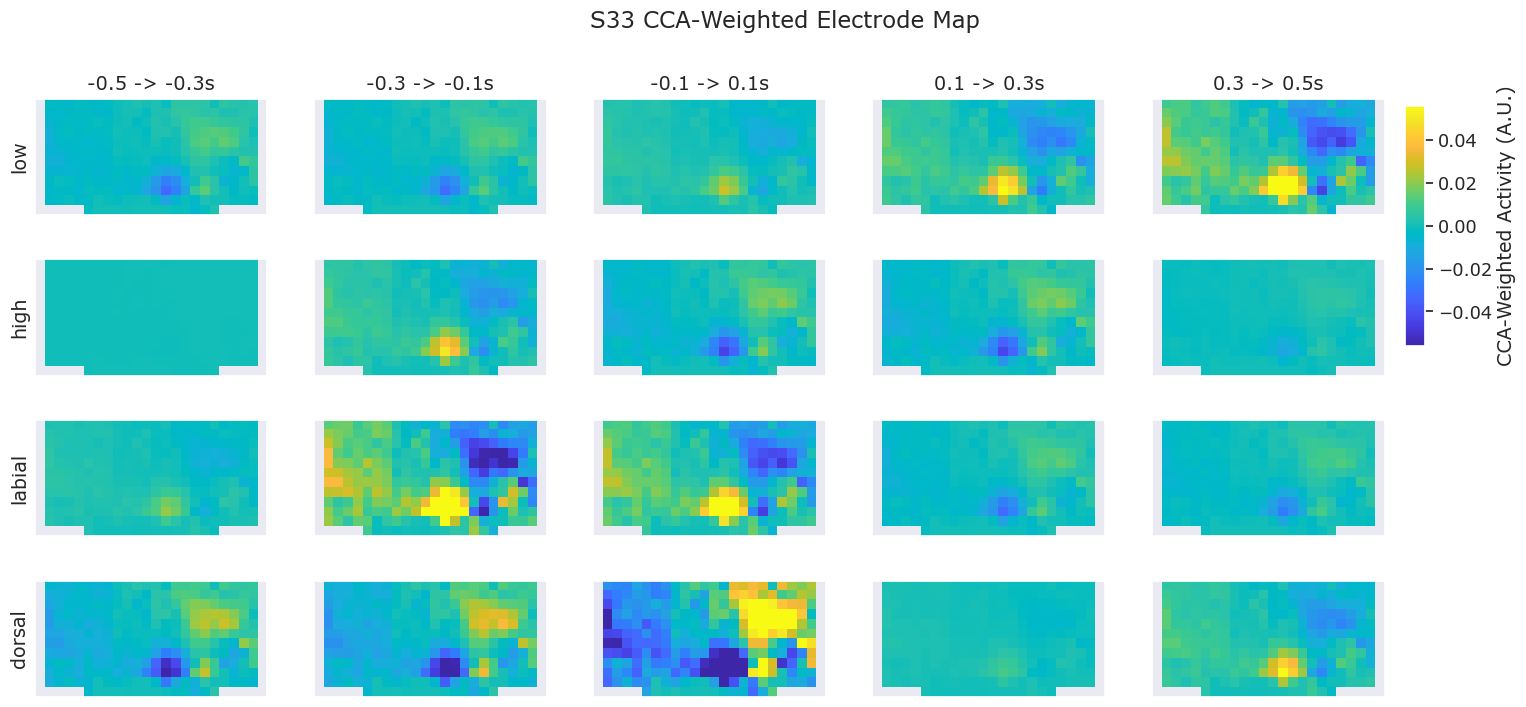

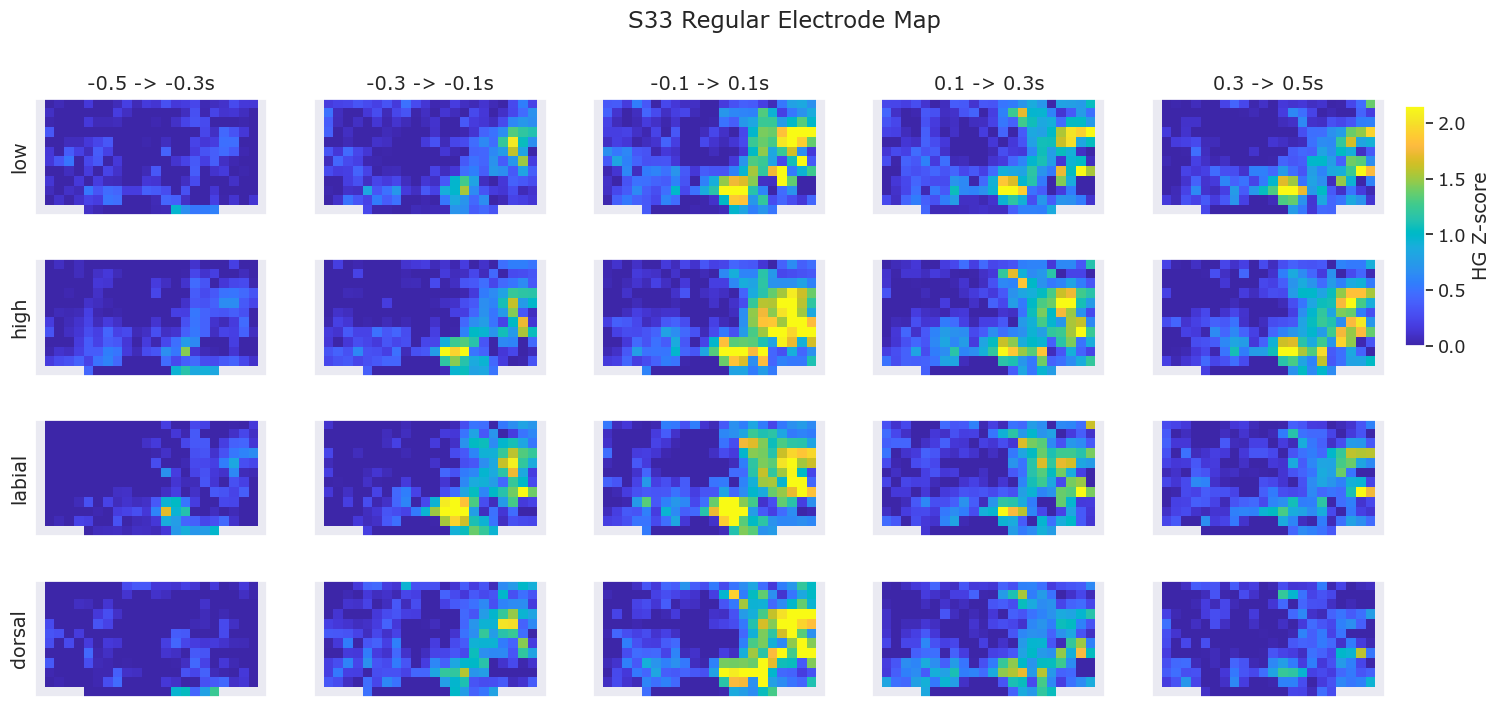

In [431]:
sns.set_theme(context='notebook', font='Verdana', font_scale=1.15)

pt = 'S33'
# cnd_labels = all_pt_phon_labels[pt]; lab_names = phon_labels
cnd_labels = all_pt_artic_labels[pt]; lab_names = artic_labels
# cnd_labels = all_pt_cv_labels[pt]; lab_names = ['CVC', 'VCV']
# cnd_labels = np.ones(all_pt_cv_labels[pt].shape); lab_names = ['All Trials']
cca_avg = cnd_avg(pt_cca_timeseries[pt]['CCA'], cnd_labels)
reg_avg = cnd_avg(pt_cca_timeseries[pt]['Reg'], cnd_labels)


t_ranges = [[-0.5, -0.3], [-0.3, -0.1], [-0.1, 0.1], [0.1, 0.3], [0.3, 0.5]]

if all_pt_chan_data[pt]['map'].size == 128:
    # chan_map = all_pt_chan_data[pt]['map'].T
    chan_map = np.arange(128).reshape(8,16).T+1
    figsize=(2,3.5)
    cbar_pos = [0.81, 0.58, 0.015, 0.3]
    sup_pos = 0.94
else:
    # chan_map = np.flipud(all_pt_chan_data[pt]['map'])-1
    if pt == 'S33':
        chan_map = np.fliplr(np.flipud(np.arange(288).reshape(12,24)))+1
    elif pt == 'S39':
        chan_map = np.arange(288).reshape(24,12).T+1
    else:
        chan_map = np.flipud(np.arange(288).reshape(24,12).T)+1
    figsize=(4,2)
    cbar_pos = [0.81, 0.56, 0.01, 0.3]
    sup_pos = 0.98
chan_disp_seq(cca_avg, chan_map, t, t_ranges, lab_names, f'{pt} CCA-Weighted Electrode Map', 'CCA-Weighted Activity (A.U.)', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos)
chan_disp_seq(reg_avg, chan_map, t, t_ranges, lab_names, f'{pt} Regular Electrode Map', 'HG Z-score', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos, cbar_lower=0)

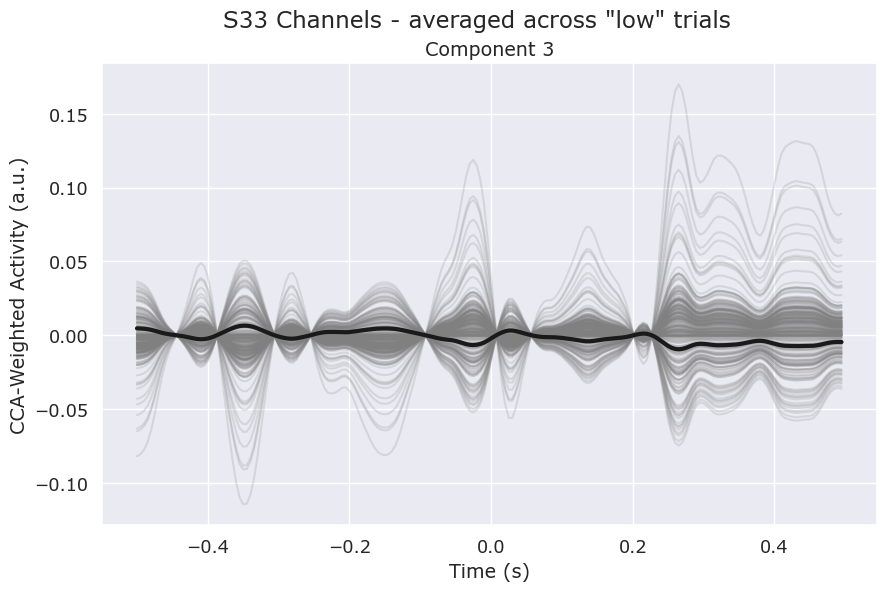

In [436]:
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
f, ax1 = plt.subplots(1, 1, figsize=(10,6))

label_ind = 0

ax1.plot(t, cca_avg[label_ind], 'gray', alpha=0.2)
ax1.plot(t, cca_avg[label_ind][:,5], 'k', linewidth=3)
# ax1.plot(t, np.nanmean(reg_avg[label_ind],axis=-1) - np.nanmean(np.nanmean(reg_avg[label_ind],axis=-1)), 'blue', linewidth=4, label='HG Z-Score (mean subtracted)')
# ax1.plot(t, np.nanmean(cca_avg[label_ind], axis=-1), 'red', linewidth=4, label='CCA-Weighted Mean')
ax1.set_ylabel('CCA-Weighted Activity (a.u.)')
ax1.set_xlabel('Time (s)')
# ax1.legend()
ax1.set_title('Component 3')

# ax2.plot(t, reg_avg[label_ind] - np.nanmean(reg_avg[label_ind]), 'gray', alpha=0.2)
# ax2.plot(t, np.nanmean(reg_avg[label_ind],axis=-1) - np.nanmean(np.nanmean(reg_avg[label_ind],axis=-1)), 'blue', linewidth=4, label='HG Z-Score (mean subtracted)')
# # ax2.plot(t, np.mean(reg_avg[label_ind] - np.nanmean(reg_avg[label_ind]).T))
# # ax2.plot(t, np.mean(reg_avg[label_ind],axis=-1))
# ax2.set_ylabel('HG Z-Score')
# ax2.set_xlabel('Time (s)')
# ax2.set_title('HG Z-Score')

plt.suptitle(f'{pt} Channels - averaged across "{lab_names[label_ind]}" trials', y=0.97)
plt.show()

#### CCA correlation with HG Z-Score

In [268]:
t_range = [-0.3, 0.3]
t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
cca_corr_data = []
reg_corr_data = []
# for pt in ['S14', 'S26', 'S23', 'S33']:
for pt in pt_names:
    d_cca = np.mean(np.mean(pt_cca_timeseries[pt]['CCA'][:,t_inds,:], axis=1), axis=0).flatten()

    # remove nans
    d_cca = d_cca[~np.isnan(d_cca)]
    

    d_reg = np.mean(np.mean(pt_cca_timeseries[pt]['Reg'][:,t_inds,:], axis=1), axis=0).flatten()
    d_reg -= np.nanmean(d_reg)

    # remove nans
    d_reg = d_reg[~np.isnan(d_reg)]

    # # remove reg outliers (3 standard deviations from mean)
    # d_reg = d_reg[np.abs(d_reg - np.nanmean(d_reg)) < 3*np.nanstd(d_reg)]

    # remove mcca outliers (3 standard deviations from mean)
    outlier_idx_cca = np.abs(d_cca - np.mean(d_cca)) >= 3*np.std(d_cca)
    outlier_idx_reg = np.abs(d_reg - np.mean(d_reg)) >= 3*np.std(d_reg)
    outlier_idx = np.logical_or(outlier_idx_cca, outlier_idx_reg)
    d_cca = d_cca[~outlier_idx]
    d_reg = d_reg[~outlier_idx]

    # mcca_corr_data.append(d_mcca[d_mcca != 0])
    cca_corr_data.append(d_cca)

    # reg_corr_data.append(d_reg[d_reg != 0])
    reg_corr_data.append(d_reg)

# mcca_corr_data = np.array(mcca_corr_data)
# reg_corr_data = np.array(reg_corr_data)

print([x.shape for x in cca_corr_data])
print([x.shape for x in reg_corr_data])

[(127,), (125,), (126,), (250,), (120,), (250,), (253,), (247,)]
[(127,), (125,), (126,), (250,), (120,), (250,), (253,), (247,)]


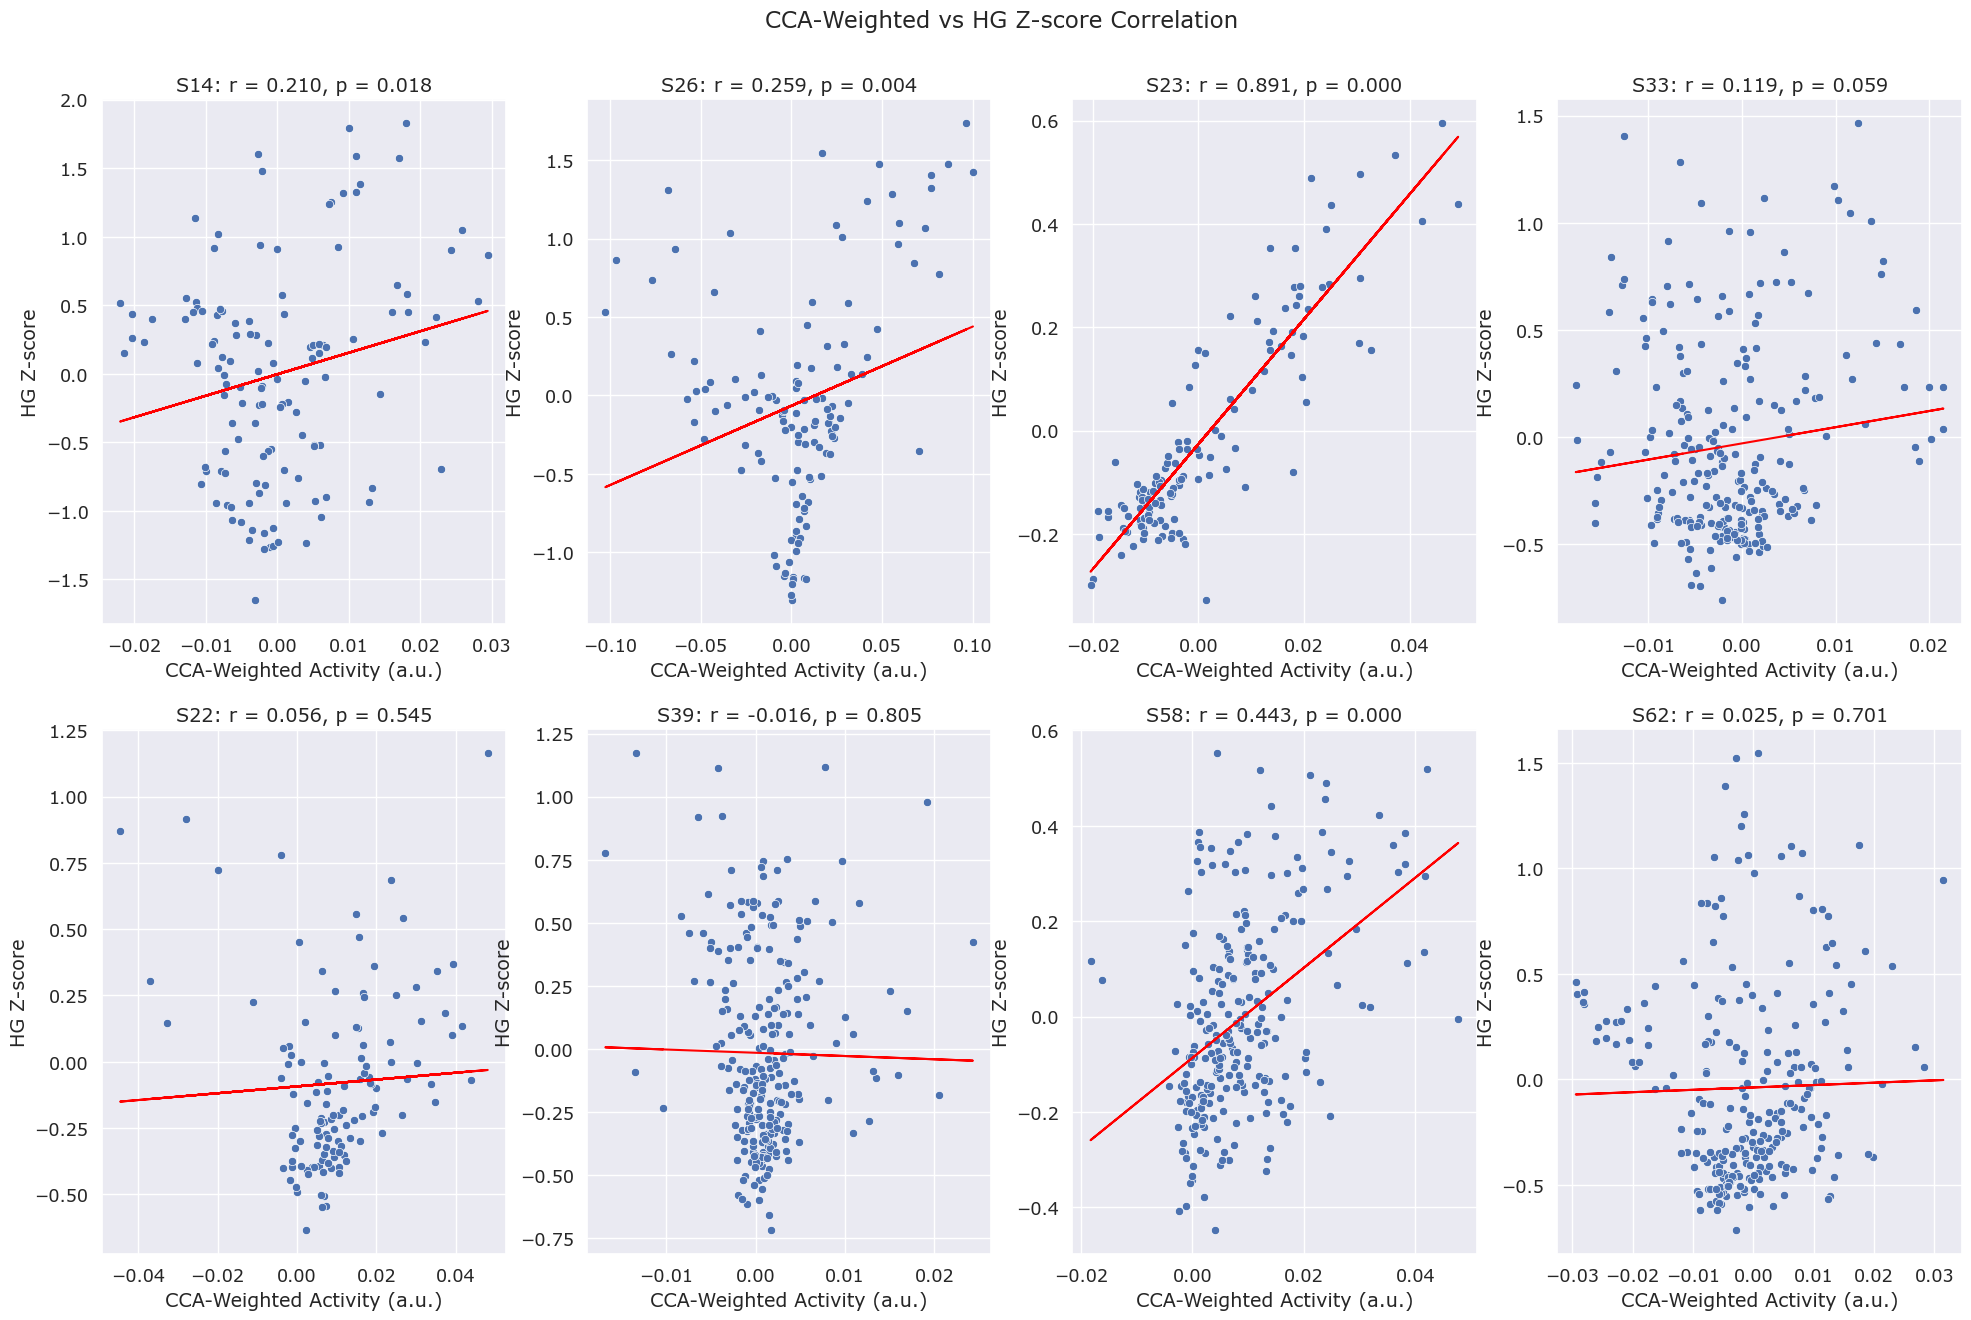

In [269]:
from scipy.stats import linregress

f, axs = plt.subplots(2, int(len(pt_names)/2), figsize=(6*len(pt_names)/2, 15))
axs = axs.flatten()
for i, pt in enumerate(pt_names):
    # calculate relationship between MCCA-Weighted and Regular HG Z-score
    slope, intercept, r_value, p_value, std_err = linregress(cca_corr_data[i], reg_corr_data[i])
    # print(slope, intercept, r_value, p_value, std_err)
    sns.scatterplot(x=cca_corr_data[i], y=reg_corr_data[i], ax=axs[i])
    axs[i].plot(cca_corr_data[i], slope*cca_corr_data[i] + intercept, color='red')
    axs[i].set_xlabel('CCA-Weighted Activity (a.u.)')
    axs[i].set_ylabel('HG Z-score')
    axs[i].set_title(f'{pt}: r = {r_value:.3f}, p = {p_value:.3f}')
plt.suptitle('CCA-Weighted vs HG Z-score Correlation', y=0.94)
plt.show()

#### Similarity between CCA components and articulator maps

In [390]:
artic_maps = sio.loadmat('../data/articulator_maps/S33/S33_articulator_maps.mat')
low_map = artic_maps['lowMap']
high_map = artic_maps['highMap']
labial_map = artic_maps['labialMap']
dorsal_map = artic_maps['dorsalMap']
artic_maps = [low_map, high_map, labial_map, dorsal_map]

In [373]:
def cos_sim(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

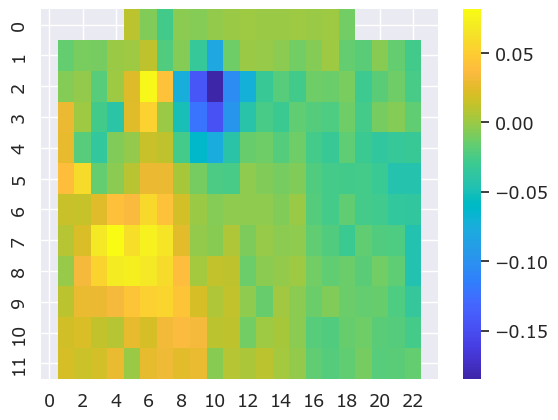

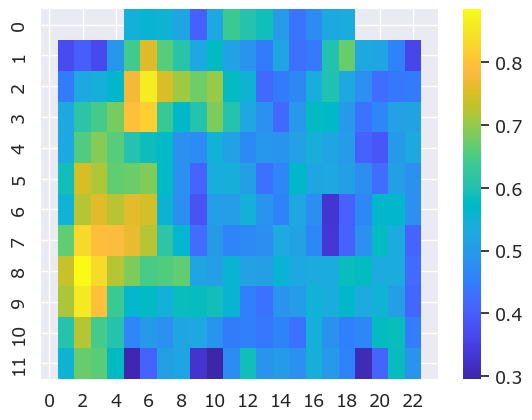

In [438]:
from sklearn.metrics.pairwise import cosine_similarity

# cca_data = cca_avg[2][~np.isnan(cca_avg[2])].reshape(len(t),-1)
# # repeat the labial map vector for all 200 timepoints
# artic_map_data = np.tile(labial_map.flatten()[:,None].T, (cca_data.shape[0],1))[~np.isnan(cca_avg[2])].reshape(len(t),-1)

# sim = np.mean(cos_sim(cca_data, artic_map_data.T), axis=1)
reg_trials = pt_cca_timeseries[pt]['Reg']
reg_mean = np.mean(reg_trials, axis=0)
reg_mean = reg_mean[~np.isnan(reg_mean)].reshape(len(t),-1)

# artic_sim_timeseries = np.zeros((len(artic_maps), len(t_ranges)))
artic_sim_timeseries_filt = np.zeros((len(artic_maps), len(t)))
artic_sim_timeseries_reg = np.zeros((len(artic_maps), len(t)))
for i, am in enumerate(artic_maps):
    flip_am = np.fliplr(am).flatten()
    speech_t_inds = np.where((t >= -0.1) & (t < 0.1))[0]
    cca_filter = cca_avg[i, speech_t_inds, :].mean(axis=0)
    cca_filter = cca_filter[~np.isnan(cca_filter)]
    # cca_filter += np.abs(np.min(cca_filter))

    # cca_data = cca_avg[i][~np.isnan(cca_avg[i])].reshape(len(t),-1)
    # cca_data += np.abs(np.min(cca_data))
    
    # for j, tr in enumerate(t_ranges):
    #     t_inds = np.where((t >= tr[0]) & (t < tr[1]))[0]
    #     cca_data = cca_avg[i, t_inds, :].mean(axis=0)
    #     cca_data = cca_data[~np.isnan(cca_data)]
    #     # cca_data = np.abs(cca_data)

    #     artic_map_data = flip_am[~np.isnan(flip_am)]

    #     sim = cos_sim(cca_data, artic_map_data)
    #     artic_sim_timeseries[i,j] = sim

    cca_data = cca_avg[i][~np.isnan(cca_avg[i])].reshape(len(t),-1)
    # cca_data += np.abs(np.min(cca_data))
    # reg_data = reg_avg[i][~np.isnan(reg_avg[i])].reshape(len(t),-1)
    # reg_filt = reg_data*cca_data
    # reg_filt = reg_data*cca_filter
    # reg_filt = reg_data
    reg_filt = reg_mean*cca_filter
    

    # cca_data = cca_avg[i][~np.isnan(cca_avg[i])].reshape(len(t),-1)

    artic_map_data = np.tile(flip_am[~np.isnan(flip_am),None].T, (reg_mean.shape[0],1)).reshape(len(t),-1)
    # sim_filt = cosine_similarity(reg_filt, artic_map_data)
    # sim_reg = cosine_similarity(reg_mean, artic_map_data)
    # sim = cosine_similarity(cca_filter[None,:], flip_am[~np.isnan(flip_am),None].T)
    sim_filt = cosine_similarity(cca_data, artic_map_data)

    # sim = cosine_similarity(reg_filt, artic_map_data)
    artic_sim_timeseries_filt[i] = np.mean(np.abs(sim_filt), axis=1)
    # artic_sim_timeseries_reg[i] = np.mean(np.abs(sim_reg), axis=1)

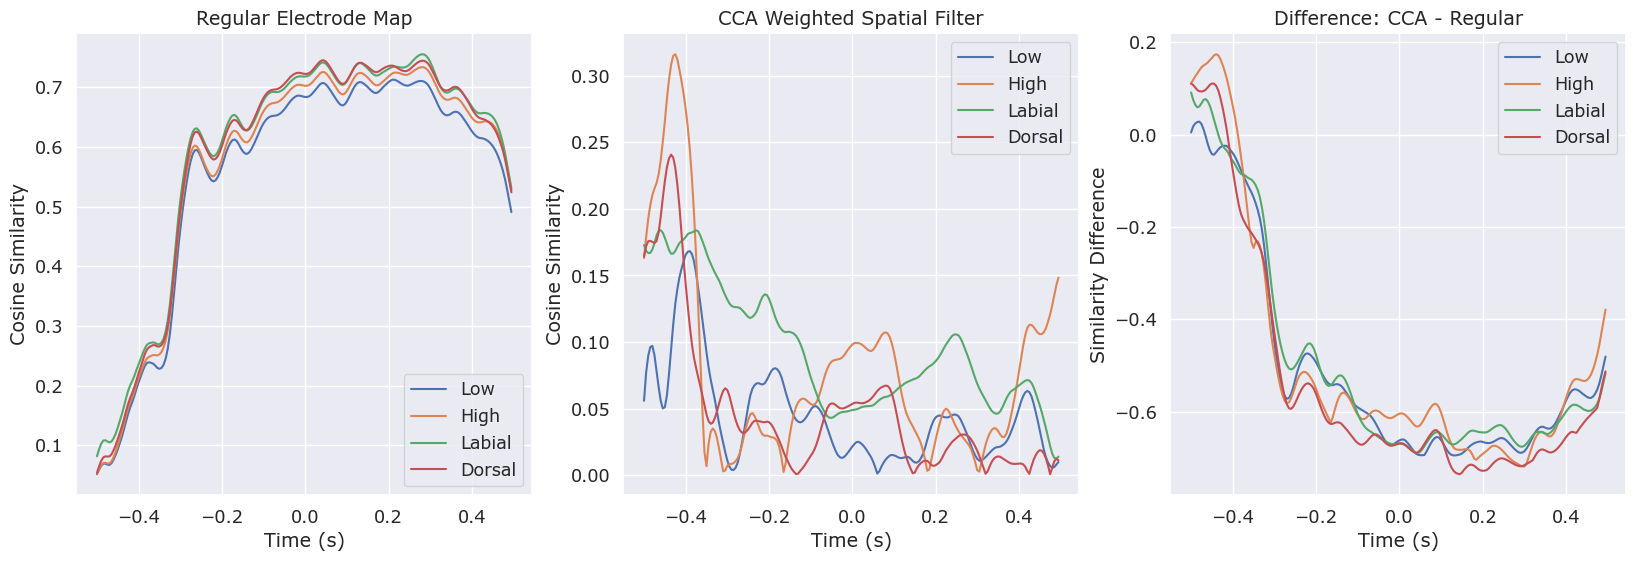

In [419]:
# f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))

# ax1.plot(t, artic_sim_timeseries_reg.T)
# ax1.set_xlabel('Time (s)')
# ax1.set_ylabel('Cosine Similarity')
# ax1.legend(['Low', 'High', 'Labial', 'Dorsal'])
# ax1.set_title('Regular Electrode Map')

# ax2.plot(t, artic_sim_timeseries_filt.T)
# ax2.set_xlabel('Time (s)')
# ax2.set_ylabel('Cosine Similarity')
# ax2.legend(['Low', 'High', 'Labial', 'Dorsal'])
# ax2.set_title('CCA Weighted Spatial Filter')

# ax3.plot(t, artic_sim_timeseries_filt.T - artic_sim_timeseries_reg.T)
# ax3.set_xlabel('Time (s)')
# ax3.set_ylabel('Similarity Difference')
# ax3.legend(['Low', 'High', 'Labial', 'Dorsal'])
# ax3.set_title('Difference: CCA - Regular')

# plt.show()


plt.figure()
plt.plot(t, artic_sim_timeseries_filt.T)
# plt.plot(np.mean(t_ranges, axis=1), artic_sim_timeseries.T, '-o')
plt.xlabel('Time (s)')
plt.ylabel('Cosine Similarity')
plt.legend(['Low', 'High', 'Labial', 'Dorsal'])
plt.title('CCA-Weighted Articulator Map Similarity')
plt.show()

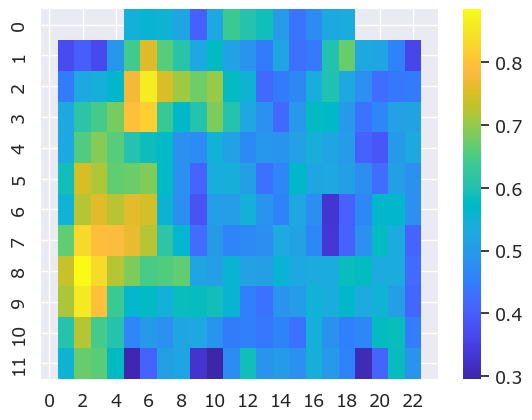

In [119]:
sns.heatmap(np.fliplr(artic_maps[3]), cmap=parula_map)
plt.show()

In [519]:
test_dict = utils.load_pkl(data_filename)

## PCA Channel Permutation Analysis

In [17]:
from sklearn.decomposition import PCA

from alignment.AlignCCA import CCA_align, extract_latent_dynamics_by_class

In [23]:
n_comp_pca = 0.9
n_comp_cca = 10
n_repeats = 100
n_comp_corr = 3

In [24]:
S14_data, S14_labels = all_pt_traces['S14'], all_pt_phon_seqs_str['S14']
S26_data, S26_labels = all_pt_traces['S26'], all_pt_phon_seqs_str['S26']

In [39]:
PCA_S14 = PCA(n_components=n_comp_pca)
PCA_S26 = PCA(n_components=n_comp_pca)

S14_data_cnd_avg = utils.cnd_avg(S14_data, S14_labels)
S26_data_cnd_avg = utils.cnd_avg(S26_data, S26_labels)

# decmopose channels (trial*time, channels)
# S14_2d = S14_data_cnd_avg.reshape(-1, S14_data.shape[-1])
# S26_2d = S26_data_cnd_avg.reshape(-1, S26_data.shape[-1])

# decompose time (trial*channel, time)
S14_2d = S14_data_cnd_avg.transpose(0,2,1).reshape(-1, S14_data.shape[1])
S26_2d = S26_data_cnd_avg.transpose(0,2,1).reshape(-1, S26_data.shape[1])

latDyn_S14 = PCA_S14.fit_transform(S14_2d)
latDyn_S26 = PCA_S26.fit_transform(S26_2d)

S14_decomp_matrix = PCA_S14.components_

In [40]:
_,_,CCs_S14_S26 = CCA_align(latDyn_S14.T, latDyn_S26.T)
CCs_S14_S26 = CCs_S14_S26[:n_comp_cca]
corr_S14_S26 = np.mean(CCs_S14_S26[:n_comp_corr])

Permute decomposition vectors

In [42]:
null_corrs = []
for i in range(n_repeats):
    S14_decomp_perm = np.zeros(S14_decomp_matrix.shape)
    for i in range(S14_decomp_matrix.shape[0]):
        perm_inds = np.random.permutation(S14_decomp_matrix.shape[1])
        S14_decomp_perm[i] = S14_decomp_matrix[i, perm_inds]
    
    # latDyn_S14_perm = np.dot(S14_data_cnd_avg.reshape(-1, S14_data.shape[-1]), S14_decomp_perm.T)
    latDyn_S14_perm = np.dot(S14_data_cnd_avg.transpose(0,2,1).reshape(-1, S14_data.shape[1]), S14_decomp_perm.T)    
        
    _,_,CCs_S14_S26_perm = CCA_align(latDyn_S14_perm.T, latDyn_S26.T)
    CCs_S14_S26_perm = CCs_S14_S26_perm[:n_comp_cca]
    
    avg_corrs = np.mean(CCs_S14_S26_perm[:n_comp_corr])
    null_corrs.append(avg_corrs)
    

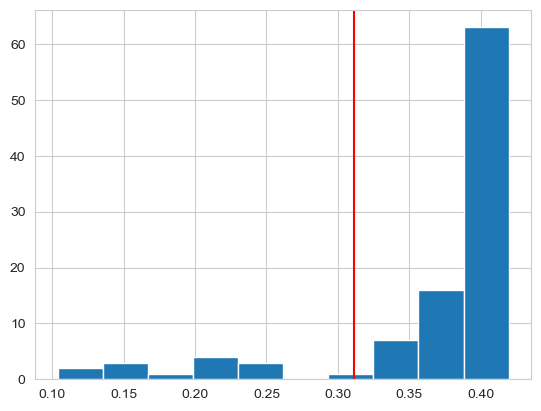

In [43]:
plt.figure()
plt.hist(null_corrs)
plt.axvline(corr_S14_S26, color='r')
plt.show()

In [44]:
from scipy.stats import ttest_1samp

res = ttest_1samp(null_corrs, corr_S14_S26, alternative='less')
print(res)

TtestResult(statistic=7.207273493240934, pvalue=0.99999999994269, df=99)


In [45]:
res.pvalue

0.99999999994269

# Articulator Maps from PCA-LDA decoder

##### Patient S14 #####


100%|██████████| 128/128 [02:52<00:00,  1.35s/it]


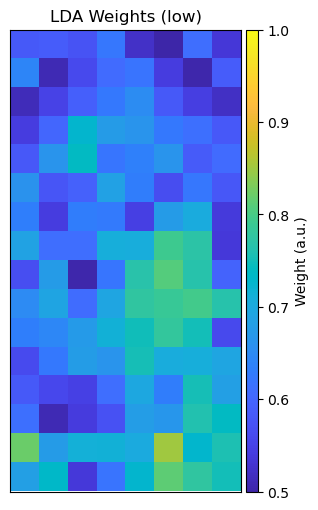

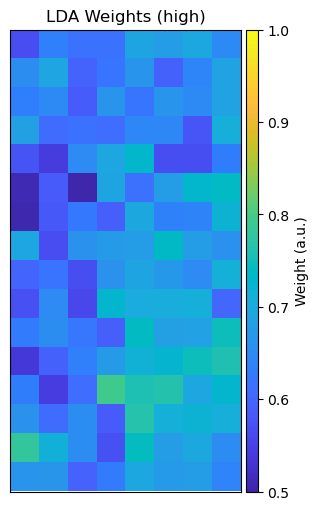

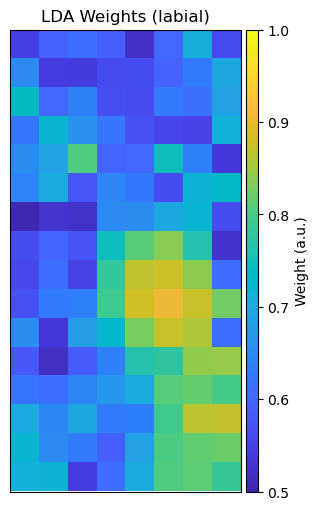

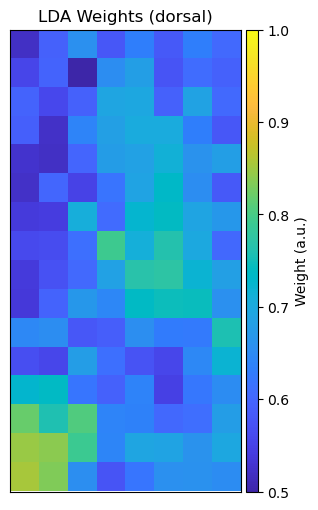

##### Patient S26 #####


100%|██████████| 128/128 [02:57<00:00,  1.38s/it]


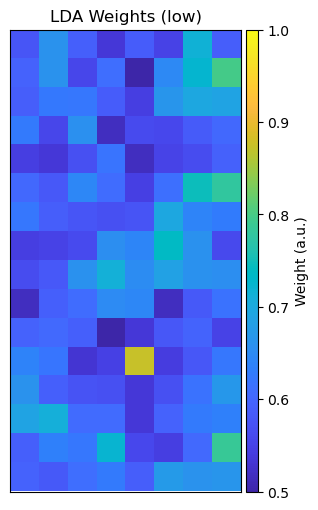

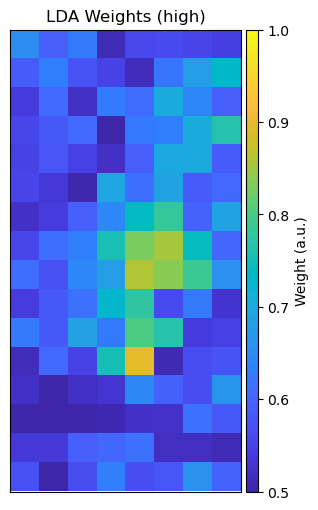

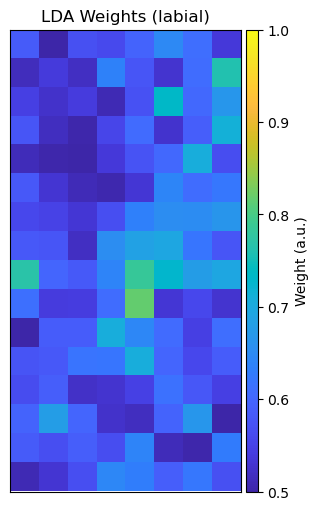

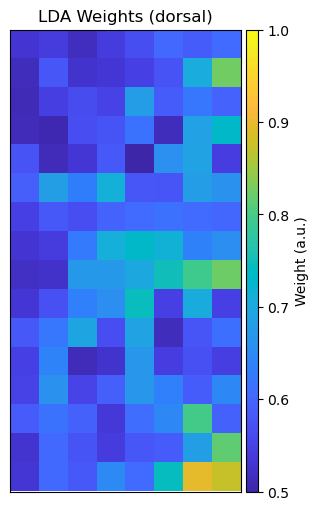

##### Patient S23 #####


100%|██████████| 128/128 [03:02<00:00,  1.42s/it]


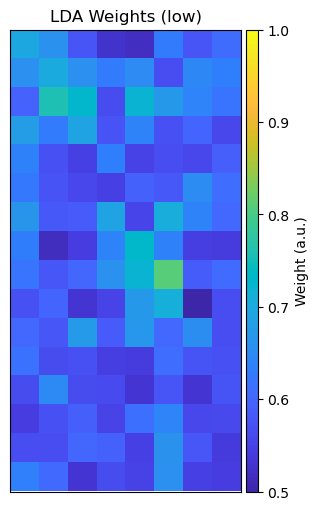

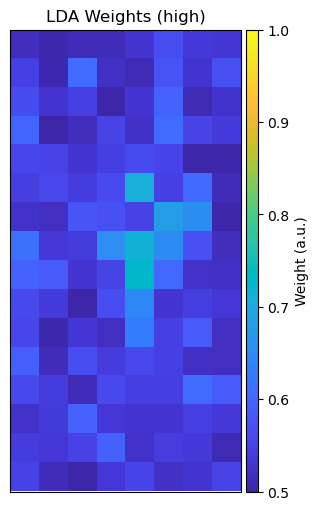

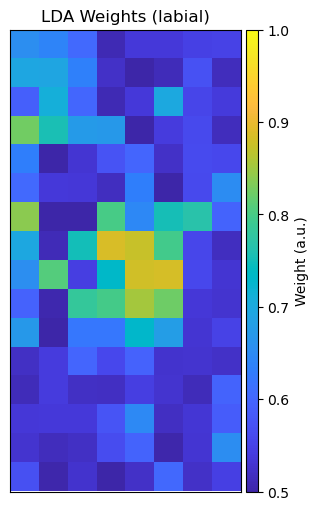

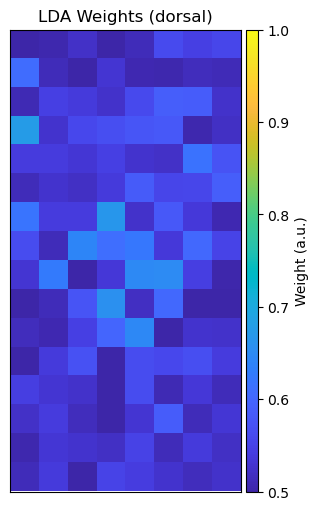

##### Patient S33 #####


100%|██████████| 256/256 [05:06<00:00,  1.20s/it]


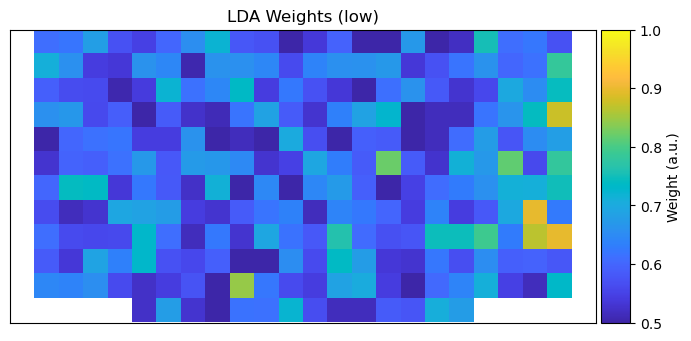

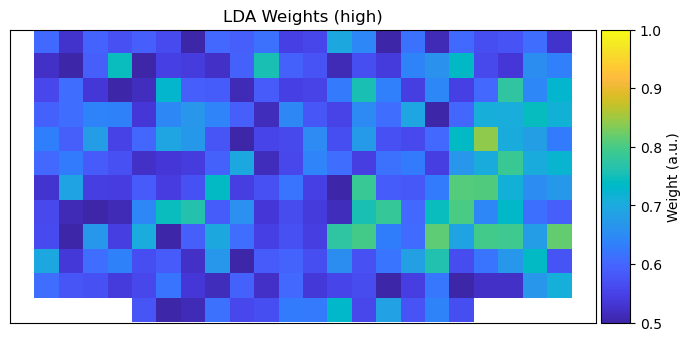

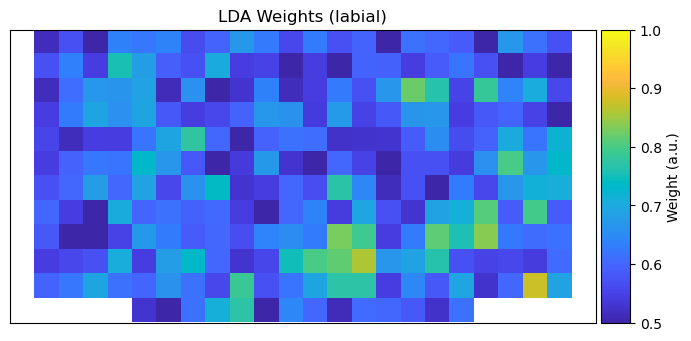

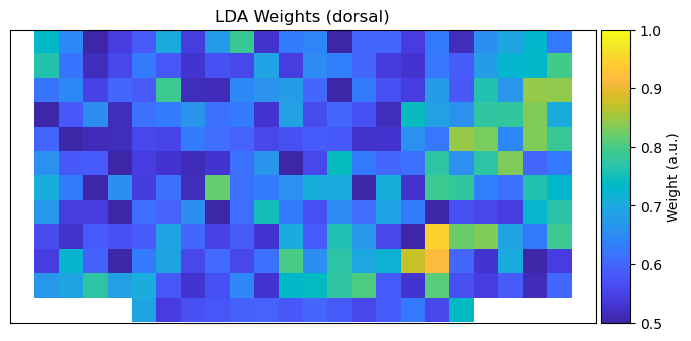

##### Patient S22 #####


100%|██████████| 128/128 [03:00<00:00,  1.41s/it]


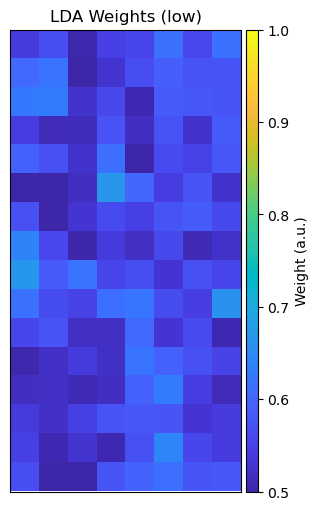

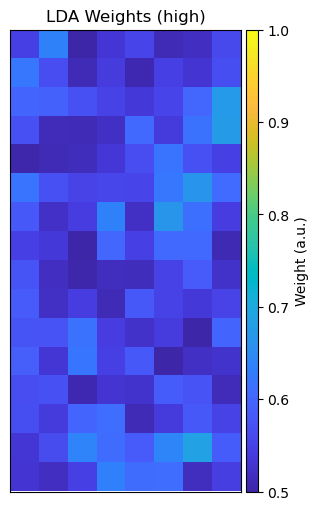

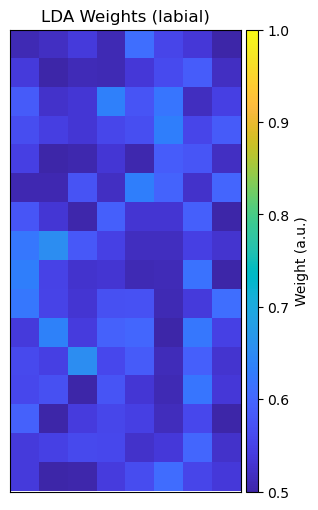

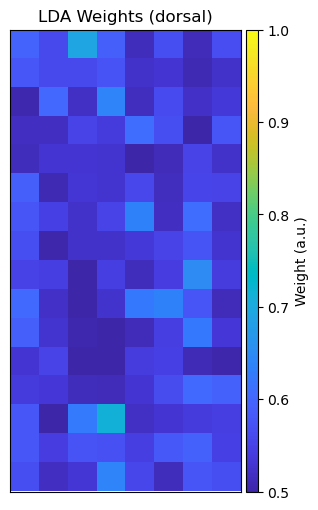

##### Patient S39 #####


100%|██████████| 256/256 [05:59<00:00,  1.40s/it]


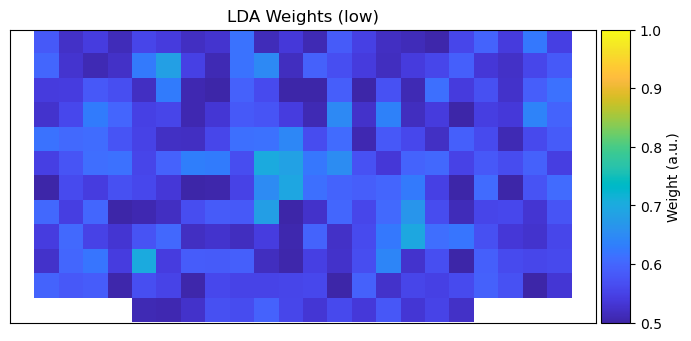

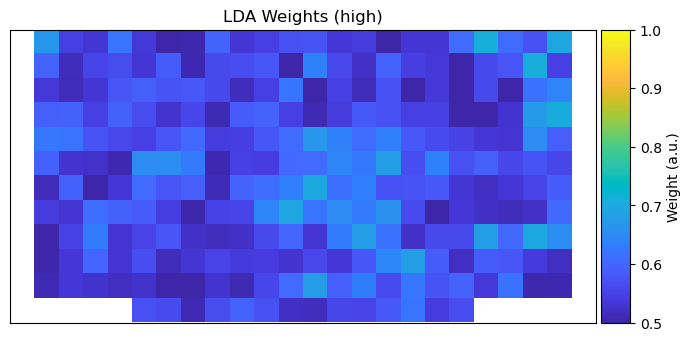

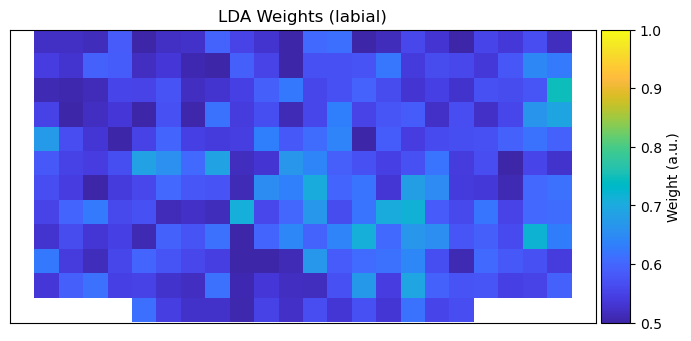

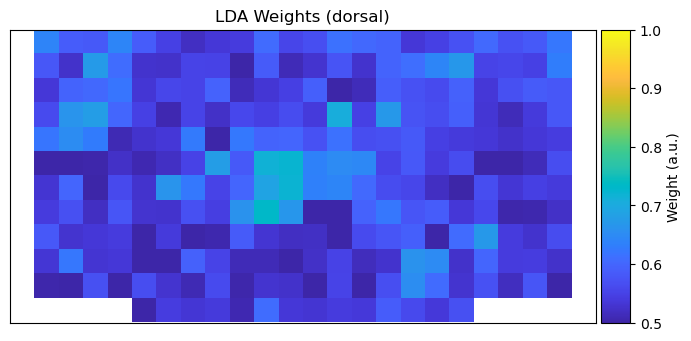

##### Patient S58 #####


100%|██████████| 256/256 [06:05<00:00,  1.43s/it]


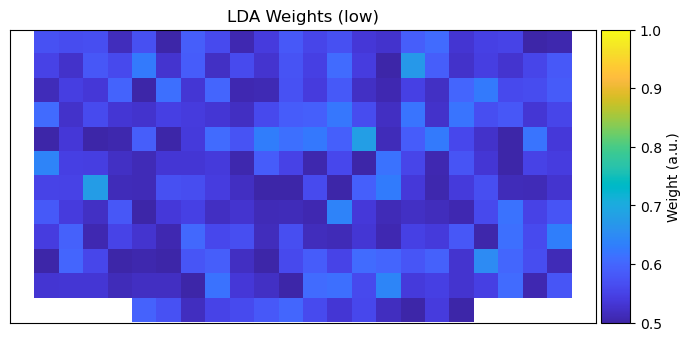

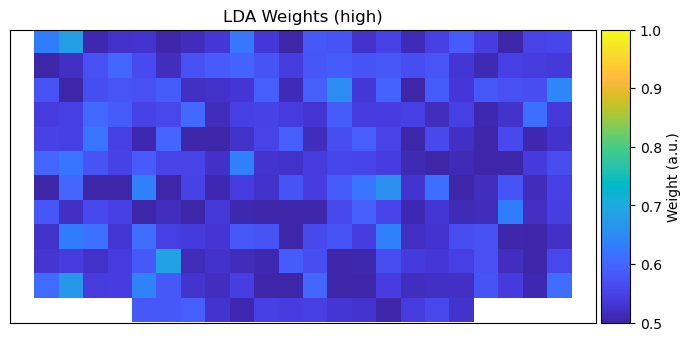

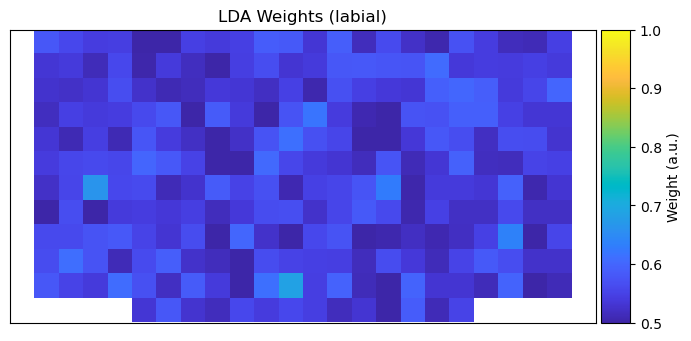

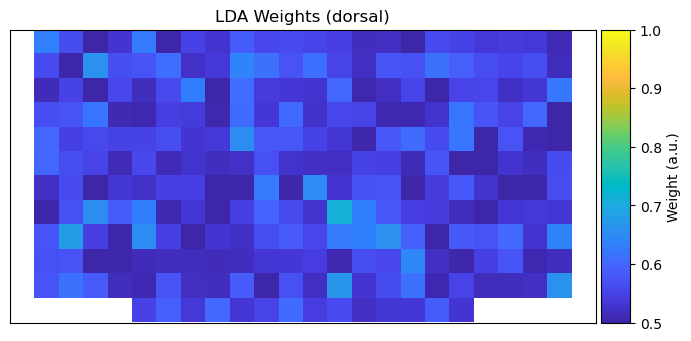

##### Patient S62 #####


100%|██████████| 256/256 [06:47<00:00,  1.59s/it]


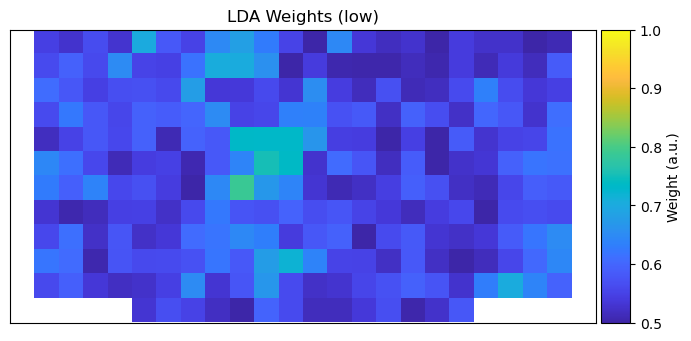

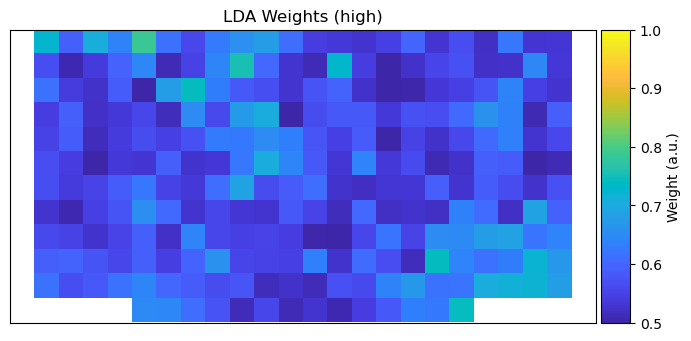

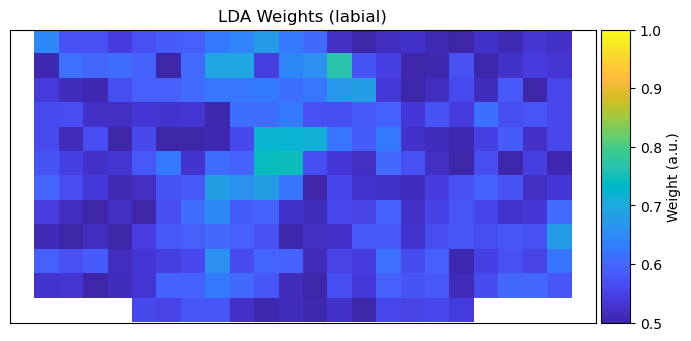

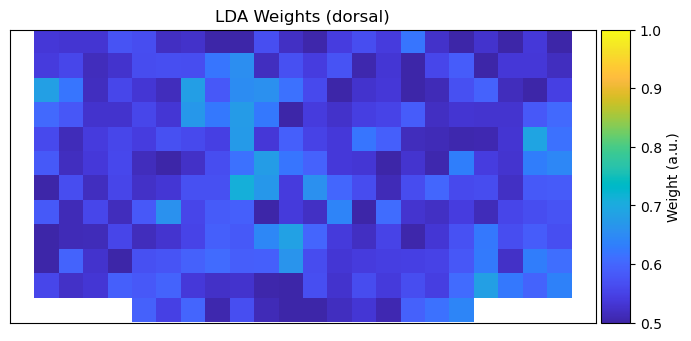

In [28]:
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import warnings
import h5py
from decomposition.NoCenterPCA import NoCenterPCA

warnings.filterwarnings('ignore')

for pt in pt_names:
# for pt in ['S14']:
    print(f'##### Patient {pt} #####')

# pt = 'S14'
    pt_ind = pt_names.index(pt)
    # feats = all_pt_dict[pt]['X1_map'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1)
    # feats = all_pt_elec_data[pt_ind].reshape(all_pt_elec_data[pt_ind].shape[0], -1)
    feats = all_pt_elec_data[pt_ind]
    labs = all_pt_artic_labels[pt]

    pc_vars = np.arange(0.1, 1.0, 0.05)
    # dr = PCA
    dr = NoCenterPCA

    n_folds = 5
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True)
    # cv = KFold(n_splits=n_folds, shuffle=True)

    elec_weights_roc = np.zeros((n_folds, len(np.unique(labs)), feats.shape[-1]))
    for i_elec in tqdm(range(feats.shape[-1])):
        feats_elec = feats[:,:,i_elec].reshape(feats.shape[0], -1)

        for i_fold, (train_idx, test_idx) in enumerate(cv.split(feats_elec, labs)):
            feats_train, feats_test = feats_elec[train_idx], feats_elec[test_idx]
            labs_train, labs_test = labs[train_idx], labs[test_idx]
                   
            model = Pipeline([
                ('pca', dr()),
                ('clf', LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')),
            ])

            param_grid = {'pca__n_components': pc_vars}
            grid = GridSearchCV(model, param_grid, cv=n_folds, n_jobs=-1)
            grid.fit(feats_train, labs_train)
            # print(grid.best_params_)
            y_score = grid.predict_proba(feats_test)

            # model.fit(feats_train, labs_train)
            # y_score = model.predict_proba(feats_test)

            labs_onehot_test = np.eye(len(np.unique(labs)), dtype=int)[labs_test-1]
            for class_id in np.unique(labs):
                roc_auc = roc_auc_score(labs_onehot_test[:,class_id-1], y_score[:,class_id-1])
                if roc_auc < 0.5:
                    # roc_auc = 1 - roc_auc
                    roc_auc = 0.5
                elec_weights_roc[i_fold, class_id-1, i_elec] = roc_auc
    elec_weights_roc_mean = np.mean(elec_weights_roc, axis=0)

    elec_weights_roc_mean_full = np.full((elec_weights_roc_mean.shape[0],
                                    np.prod(all_pt_chan_data[pt]['map'].shape)),
                                    np.nan)
    elec_weights_roc_mean_full[:,all_pt_good_chans[pt_ind]] = elec_weights_roc_mean

    weight_map = get_pt_map_from_flat(pt)
    for map, lab in zip(elec_weights_roc_mean_full, artic_labels):
        chan_disp(map, weight_map, f'LDA Weights ({lab})', 'Weight (a.u.)', cbar_lower=0.5, cbar_upper=1.0)

    with h5py.File(f'../data/articulator_maps/new/{pt}/{pt}_artic_elec_weights.h5', 'w') as f:
        f.create_dataset('weights', data=elec_weights_roc_mean_full)
        f.create_dataset('weight_map', data=weight_map)

In [147]:
elec_weights_roc_mean_full = np.full((elec_weights_roc_mean.shape[0],
                                     np.prod(all_pt_chan_data[pt]['map'].shape)),
                                     np.nan)
elec_weights_roc_mean_full[:,all_pt_good_chans[pt_ind]] = elec_weights_roc_mean
# elec_weights_roc_mean_full[:,:elec_weights_roc_mean.shape[1]] = elec_weights_roc_mean

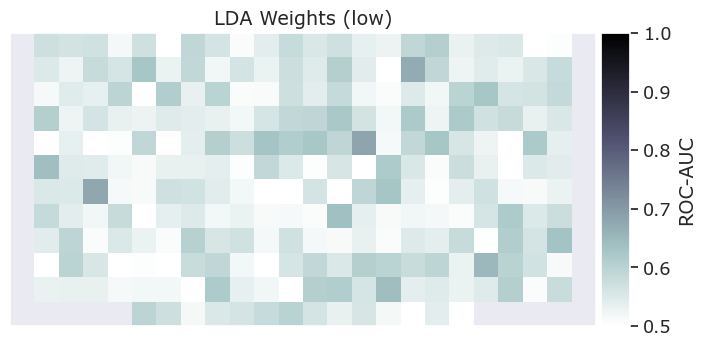

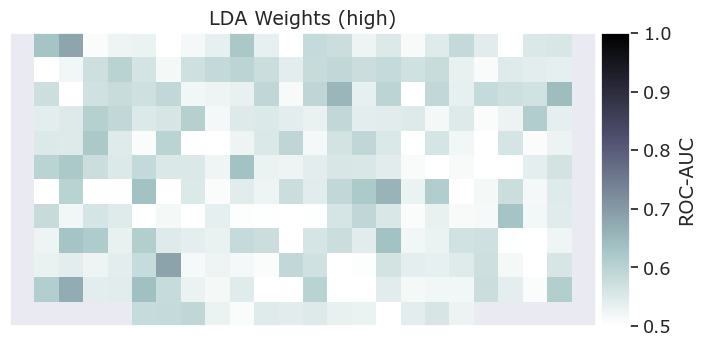

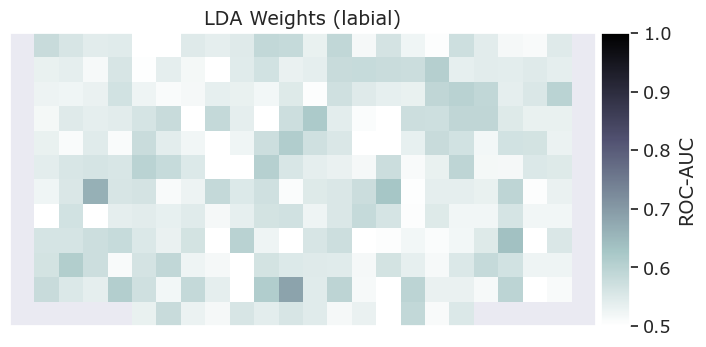

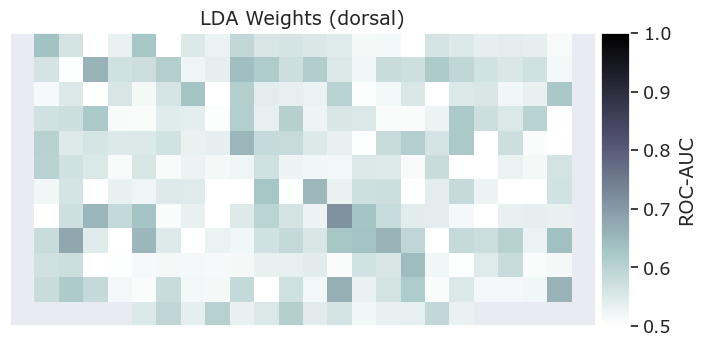

In [143]:
pt = 'S58'

h5py_filename = f'../data/articulator_maps/new/{pt}/{pt}_artic_elec_weights.h5'

# load h5py file
with h5py.File(h5py_filename, 'r') as f:
    weights = f['weights'][()]
    weight_map = f['weight_map'][()]
    
weight_map = get_pt_map_from_flat(pt)
for map, lab in zip(weights, artic_labels):
    chan_disp(map, weight_map, f'LDA Weights ({lab})', 'ROC-AUC', cbar_lower=0.5, cbar_upper=1.0, cmap='bone_r')

In [130]:
import h5py

with h5py.File(f'../data/articulator_maps/new/{pt}/{pt}_artic_elec_weights.h5', 'w') as f:
    f.create_dataset('weights', data=elec_weights_roc_mean_full)
    f.create_dataset('weight_map', data=weight_map)

In [ ]:
h5py_filename = f'../data/articulator_maps/new/{pt}/{pt}_artic_elec_weights.h5'

# load h5py file
with h5py.File(h5py_filename, 'r') as f:
    weights = f['weights'][()]
    weight_map = f['weight_map'][()]
    